# Crypto data Collection

In [25]:
import pandas as pd
from binance.spot import Spot

client = Spot()
AUTHORIZED_PAIRS = {"USDT", "BTC"}
def get_spot_pairs():
    infos = client.list_all_convert_pairs()

    cryptos = {} 

    for info in infos:
        if info["toAsset"] in AUTHORIZED_PAIRS:
            cryptos[info["fromAsset"]] = info["toAsset"]
    return [f"{key}{value}" for key, value in cryptos.items()] 
cryptos = get_spot_pairs()


In [26]:
def get_pair_df(pair="BTCUSDT", limit=400, frequency="1w"):
    columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 
            'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume',
            'Taker Buy Quote Asset Volume', 'Ignore']
    try:
        df = pd.DataFrame(data=client.klines(pair, "1w", limit=limit), columns=columns)
    except Exception:
        return pd.DataFrame(columns=columns)
        
    df = df.iloc[:, 0:7]
    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')
    df["Open"] = pd.to_numeric(df['Open'], errors='coerce')
    df["High"] = pd.to_numeric(df['High'], errors='coerce')
    df["Low"] = pd.to_numeric(df['Low'], errors='coerce')
    df["Close"] = pd.to_numeric(df['Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    return df

df = get_pair_df(pair="LTCUSDT")
df.head()

Open Time    Open    High     Low   Close        Volume  \
0 2017-12-11  272.00  330.00  239.99  311.40   59561.28759   
1 2017-12-18  311.23  366.96  177.58  262.90  251577.24855   
2 2017-12-25  262.90  284.34  193.20  223.69  223926.94979   
3 2018-01-01  223.69  315.00  212.74  269.01  442699.93154   
4 2018-01-08  269.01  271.82  195.03  234.12  435643.98700   

               Close Time  
0 2017-12-17 23:59:59.999  
1 2017-12-24 23:59:59.999  
2 2017-12-31 23:59:59.999  
3 2018-01-07 23:59:59.999  
4 2018-01-14 23:59:59.999

# Stocks data collection

In [27]:
MARKET_SHORTNAME = {
    "Euronext Growth Paris": "PA",
    "Euronext Brussels, Paris": "BR",
    "Euronext Paris": "PA",
    "Euronext Amsterdam, Paris": "AS",
    "Euronext Access Paris": "PA",
    "Euronext Paris, Brussels": "PA",
    "Euronext Paris, Amsterdam, Brussels": "PA",
    "Euronext Amsterdam, Brussels, Paris": "AS",
    "Euronext Paris, Amsterdam": "PA",
}

def get_ticker_names():
    df = pd.read_csv("stock_list.csv", sep=";")
    df["ticker_eodhd"] = df["Symbol"] + "." + df["Market"].map(MARKET_SHORTNAME)
    return df["ticker_eodhd"]

tickers = get_ticker_names()
# get_ticker_names()

In [28]:

API_TOKEN = "6614351c645f34.55152589"

def get_stock_data(ticker):
    url = f'https://eodhd.com/api/eod/{ticker}?period=w&from=2020-01-05&api_token={API_TOKEN}&fmt=csv'
    try:
        df = pd.read_csv(url)
    except:
        return pd.DataFrame()
    if not len(df):
        return pd.DataFrame()
    df["Close Time"] = df["Date"]
    return df 

df = get_stock_data(tickers[0])
# df

# Compute and analysis

In [29]:

def compute_rsi(df):
    if len(df) == 0:
        return pd.DataFrame()
        
    df['Change'] = df['Close'].diff()

    df['Gain'] = df['Change'].mask(df['Change'] < 0, 0)
    df['Loss'] = -df['Change'].mask(df['Change'] > 0, 0)

    window_length = 14
    df['Avg Gain'] = df['Gain'].ewm(alpha=1/window_length, adjust=False).mean()
    df['Avg Loss'] = df['Loss'].ewm(alpha=1/window_length, adjust=False).mean()

    df['RS'] = df['Avg Gain'] / df['Avg Loss']
    df["ema5"] = df['Close'].ewm(span=5, adjust=False).mean()

    df['RSI'] = 100 - (100 / (1 + df['RS']))
    df['Volume_MA'] = df['Volume'].rolling(window=20).mean()
    return df

df_rsi = compute_rsi(df)

df_rsi.tail()

Date  Open  High   Low  Close  Adjusted_close  Volume  Close Time  \
215  2024-03-11  26.2  26.6  25.4   26.2            26.2     435  2024-03-11   
216  2024-03-18  26.0  26.2  25.2   25.2            25.2     420  2024-03-18   
217  2024-03-25  26.2  26.2  25.2   26.0            26.0     128  2024-03-25   
218  2024-04-02  25.2  26.2  25.0   25.0            25.0    1054  2024-04-02   
219  2024-04-08  26.0  26.2  25.0   26.0            26.0     143  2024-04-08   

     Change  Gain  Loss  Avg Gain  Avg Loss        RS       ema5        RSI  \
215     0.0   0.0  -0.0  0.344328  0.329687  1.044408  26.088532  51.086092   
216    -1.0   0.0   1.0  0.319733  0.377566  0.846826  25.792355  45.853034   
217     0.8   0.8  -0.0  0.354038  0.350597  1.009813  25.861570  50.244120   
218    -1.0   0.0   1.0  0.328749  0.396983  0.828119  25.574380  45.298956   
219     1.0   1.0  -0.0  0.376696  0.368627  1.021888  25.716253  50.541271   

     Volume_MA  
215     292.90  
216     308.55  
217     291.65  
218     342.30  
219     333.65

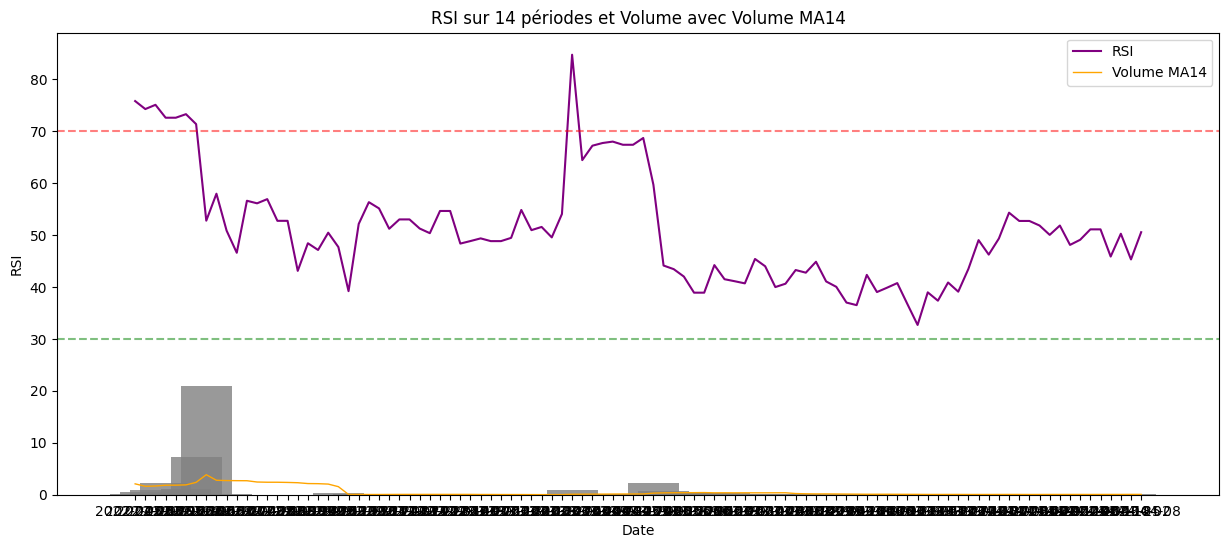

In [30]:
import matplotlib.pyplot as plt

def plot_rsi(df_rsi, limit=30):
    # Calcul de la moyenne mobile sur 14 périodes pour le volume
    df_rsi['Volume_MA14'] = df_rsi['Volume'].rolling(window=14).mean()

    fig, ax = plt.subplots(figsize=(15, 6))

    # Tracé du RSI
    ax.plot(df_rsi.iloc[-limit:]["Close Time"], df_rsi.iloc[-limit:]['RSI'], label='RSI', color='purple')
    ax.axhline(70, linestyle='--', alpha=0.5, color='red')
    ax.axhline(30, linestyle='--', alpha=0.5, color='green')

    # Mise à l'échelle des volumes pour l'affichage
    base_line = 0
    scaled_volume = (df_rsi.iloc[-limit:]['Volume'] / df_rsi.iloc[-limit:]['Volume'].max()) * (70 * 0.3)  # Ajustement pour l'affichage

    # Tracé des volumes
    ax.bar(df_rsi.iloc[-limit:]["Close Time"], scaled_volume, width=5, bottom=base_line, color='grey', alpha=0.8)

    # Mise à l'échelle de la moyenne mobile du volume pour l'affichage
    scaled_volume_MA = (df_rsi.iloc[-limit:]['Volume_MA14'] / df_rsi.iloc[-limit:]['Volume'].max()) * (70 * 0.3)

    # Tracé de la moyenne mobile du volume
    ax.plot(df_rsi.iloc[-limit:]["Close Time"], scaled_volume_MA + base_line, label='Volume MA14', color='orange', linewidth=1)

    # Configuration du graphique
    ax.set_title('RSI sur 14 périodes et Volume avec Volume MA14')
    ax.set_xlabel('Date')
    ax.set_ylabel('RSI')
    ax.legend()

    plt.show()

plot_rsi(df_rsi=df_rsi, limit=100)


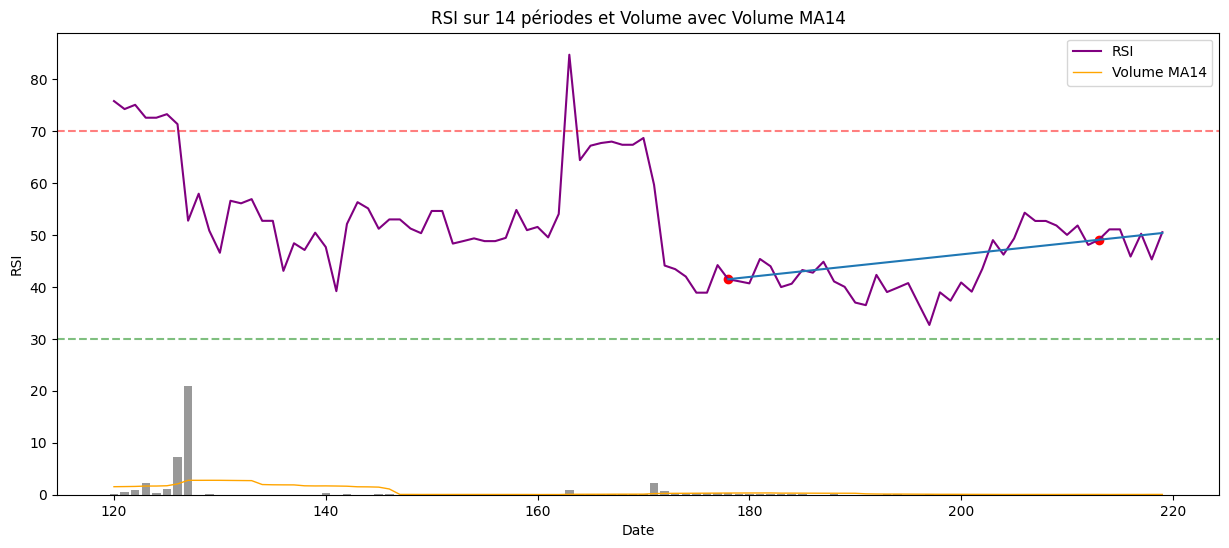

In [31]:
import numpy as np

def compute_line(x_1, x_2, y_1, y_2):
    a = (y_2 - y_1) / (x_2 - x_1)
    b = y_1 - a * x_1 
    return a, b 


def draw_line(a, b, start_point, max_size):
    def equation(x):
        return a * x + b

    x = np.array(range(start_point  , max_size))
    y = equation(x)

    filtered_x, filtered_y = [], []

    for x_, y_ in zip(x, y):
        if y_ > 0 and y_ < 100:
            filtered_x.append(x_)
            filtered_y.append(y_)
    plt.plot(filtered_x, filtered_y)


def plot_rsi_with_line(x_1, x_2, y_1, y_2, df_rsi=df_rsi, limit=100):
    fig, ax = plt.subplots(figsize=(15, 6))

    # Tracé du RSI
    ax.plot(df_rsi.iloc[-limit:].index, df_rsi.iloc[-limit:]['RSI'], label='RSI', color='purple')
    ax.axhline(70, linestyle='--', alpha=0.5, color='red')
    ax.axhline(30, linestyle='--', alpha=0.5, color='green')

    # Mise à l'échelle des volumes pour l'affichage
    base_line = 0
    scaled_volume = (df_rsi.iloc[-limit:]['Volume'] / df_rsi.iloc[-limit:]['Volume'].max()) * (70 * 0.3)  # Ajustement pour l'affichage

    # Tracé des volumes
    ax.bar(df_rsi.iloc[-limit:].index, scaled_volume, width=0.8, bottom=base_line, color='grey', alpha=0.8)

    # Mise à l'échelle de la moyenne mobile du volume pour l'affichage
    scaled_volume_MA = (df_rsi.iloc[-limit:]['Volume_MA'] / df_rsi.iloc[-limit:]['Volume'].max()) * (70 * 0.3)

    # Tracé de la moyenne mobile du volume
    ax.plot(df_rsi.iloc[-limit:].index, scaled_volume_MA + base_line, label='Volume MA14', color='orange', linewidth=1)

    # Configuration du graphique
    ax.set_title('RSI sur 14 périodes et Volume avec Volume MA14')
    ax.set_xlabel('Date')
    ax.set_ylabel('RSI')
    ax.legend()

    a, b = compute_line(x_1, x_2, y_1, y_2)
    draw_line(a, b, x_1, len(df_rsi))
    plt.scatter(df_rsi.index[[x_1, x_2]], [y_1, y_2], color='red', label='Points spécifiques')

    plt.show()


def get_x_y_from_df(df_rsi, i_1, i_2):
    x_1 = df_rsi.index[-i_1]  
    x_2 = df_rsi.index[-i_2] 

    y_1 = df_rsi.loc[x_1, "RSI"]
    y_2 = df_rsi.loc[x_2, "RSI"]
    return x_2, x_1, y_2, y_1

plot_rsi_with_line(*get_x_y_from_df(df_rsi, 7, 42), limit=100)


In [32]:
import itertools

from dataclasses import dataclass

THRESHOLD_CROSS = 1
NB_LAST_POINT_AUTHORIZED = 3
NB_PREVIOUS_POINT_NO_CROSS = 0
MAX_SLOPE_POSITIVE = 0.10
MIN_SLOPE_NEGATIVE = -0.50
HISTORY_LIMIT = 200
MINIMAL_SPACE_LINE_POINTS = 2
VOLATILITY_COMPRESSION_HISTORY = 10 
VOLATILITY_COMPRESSION_THRESHOLD = 0.5

@dataclass
class Line:
    x_1: float
    x_2: float
    y_1: float
    y_2: float
    score: float
    a: float = 0.0 
    b: float = 0.0
    

def is_valid_magic_line(x_1, x_2, y_1, y_2, df_rsi=df_rsi, limit=30) -> Line:
    a, b = compute_line(x_1, x_2, y_1, y_2)
    if a > MAX_SLOPE_POSITIVE or a < MIN_SLOPE_NEGATIVE:
        return Line(x_1=0, x_2=0, y_1=0, y_2=0, a=0, score=0, b=0)
    start_point = max(x_1 - NB_PREVIOUS_POINT_NO_CROSS, 0)
    total_points = len(df_rsi.loc[start_point:])

    points = 0
    previous_touching_point = False

    for i, (x, y) in enumerate(zip(df_rsi.loc[start_point:].index, df_rsi.loc[start_point:]["RSI"])):
        position_from_end = total_points - i - 1
        if y > a*x+b + THRESHOLD_CROSS:
            if position_from_end > NB_LAST_POINT_AUTHORIZED or y < df.iloc[i]["ema5"]: 
                return Line(x_1=0, x_2=0, y_1=0, y_2=0, a=0, score=0, b=0)
            else:
                return Line(x_1=x_1, x_2=x_2, y_1=y_1, y_2=y_2, a=a, score=points, b=b)
     
        if abs(a*x - y + b) / np.sqrt(a**2 + 1) <= THRESHOLD_CROSS and not previous_touching_point:
            points += 1
            previous_touching_point = True
        else:
            previous_touching_point = False
        
        
    return Line(x_1=0, x_2=0, y_1=0, y_2=0, a=0, score=0, b=0)

def display_top_k_lines(lines, top_k=3, limit=40):
    for line in lines[:top_k]:
        plot_rsi_with_line(line.x_1, line.x_2, line.y_1, line.y_2, limit=limit)
        
def filter_similar_lines(lines, tolerance=1):
    filtered_lines = []

    for new_line in lines:
        similar_exists = False
        for existing_line in filtered_lines:
            if abs(new_line.a - existing_line.a) < tolerance and abs(new_line.b - existing_line.b) < 10 * tolerance:
                similar_exists = True
                break
        if not similar_exists:
            filtered_lines.append(new_line)

    return filtered_lines

def calculate_local_tops(df_rsi):
    is_higher_than_prev = df_rsi['RSI'] > df_rsi['RSI'].shift(1)
    is_higher_than_next = df_rsi['RSI'] > df_rsi['RSI'].shift(-1)
    
    local_tops = is_higher_than_prev & is_higher_than_next
    
    return local_tops

def is_invalid_setup(local_tops, idx1, row1, idx2):
    return pd.isna(row1.RSI) or idx2 - idx1 < MINIMAL_SPACE_LINE_POINTS or not local_tops[idx1] or not local_tops[idx2]

def compute_and_validate_2_combinations(df_rsi, limit=100): 
    if not len(df_rsi):
        return None
    
    df_rsi = df_rsi.iloc[-limit:]
    pairs = list(itertools.combinations(list(df_rsi.iterrows()), 2))
    best_lines = list()
    local_tops = calculate_local_tops(df_rsi)

    for (idx1, row1), (idx2, row2) in pairs:
        if is_invalid_setup(local_tops, idx1, row1, idx2):
            continue

        line = is_valid_magic_line(idx1, idx2, row1.RSI, row2.RSI, df_rsi, limit=limit)
        if line.score > 0:
            best_lines.append(line)

    best_lines.sort(key=lambda x: x.score, reverse=True)
    best_lines_filtered = filter_similar_lines(best_lines)

    if best_lines_filtered:
        return best_lines_filtered[0]
    else:
        return None


compute_and_validate_2_combinations(df_rsi.iloc[-100:])

Line(x_1=170, x_2=206, y_1=68.67686686767848, y_2=54.29585931024994, score=6, a=-0.399472432150793, b=136.58718033331328)

In [33]:
def get_sum_line_distances(df, a, b):
    y_line = a * df.index + b
    is_below = df['RSI'] <= y_line
    df['distances'] = np.where(is_below, abs(a * df.index - df['RSI'] + b) / np.sqrt(a**2 + 1), 0)

    df['Volatility'] = df['distances'].rolling(window=10).sum()
    df['Volatility_tendency'] = df['Volatility'].diff()

    return df

get_sum_line_distances(df_rsi, -0.2185110685963875, 95.51238433358529).tail(20)

Date  Open  High   Low  Close  Adjusted_close  Volume  Close Time  \
200  2023-11-27  22.2  23.8  22.0   23.8            23.8     448  2023-11-27   
201  2023-12-04  23.0  23.8  22.0   23.2            23.2     116  2023-12-04   
202  2023-12-11  23.0  24.2  22.2   24.2            24.2     124  2023-12-11   
203  2023-12-18  24.2  26.0  22.8   25.6            25.6     267  2023-12-18   
204  2023-12-27  25.6  26.0  23.8   24.8            24.8     230  2023-12-27   
205  2024-01-02  25.0  25.6  24.6   25.6            25.6     310  2024-01-02   
206  2024-01-08  24.8  27.4  24.6   27.0            27.0     519  2024-01-08   
207  2024-01-15  25.0  26.8  25.0   26.6            26.6     228  2024-01-15   
208  2024-01-22  26.0  27.0  25.0   26.6            26.6     445  2024-01-22   
209  2024-01-29  26.6  26.6  25.8   26.4            26.4     126  2024-01-29   
210  2024-02-05  25.4  26.8  24.8   26.0            26.0     657  2024-02-05   
211  2024-02-12  27.0  27.0  25.4   26.4            26.4     259  2024-02-12   
212  2024-02-19  26.8  26.8  25.4   25.6            25.6     383  2024-02-19   
213  2024-02-26  26.8  26.8  25.4   25.8            25.8     298  2024-02-26   
214  2024-03-04  25.8  26.2  25.4   26.2            26.2      83  2024-03-04   
215  2024-03-11  26.2  26.6  25.4   26.2            26.2     435  2024-03-11   
216  2024-03-18  26.0  26.2  25.2   25.2            25.2     420  2024-03-18   
217  2024-03-25  26.2  26.2  25.2   26.0            26.0     128  2024-03-25   
218  2024-04-02  25.2  26.2  25.0   25.0            25.0    1054  2024-04-02   
219  2024-04-08  26.0  26.2  25.0   26.0            26.0     143  2024-04-08   

     Change  Gain  ...  Avg Gain  Avg Loss        RS       ema5        RSI  \
200     0.8   0.8  ...  0.417372  0.604163  0.690826  23.625880  40.857310   
201    -0.6   0.0  ...  0.387559  0.603866  0.641797  23.483920  39.091138   
202     1.0   1.0  ...  0.431305  0.560733  0.769182  23.722614  43.476689   
203     1.4   1.4  ...  0.500498  0.520680  0.961238  24.348409  49.011798   
204    -0.8   0.0  ...  0.464748  0.540632  0.859639  24.498939  46.226110   
205     0.8   0.8  ...  0.488694  0.502015  0.973466  24.865960  49.327719   
206     1.4   1.4  ...  0.553788  0.466157  1.187986  25.577306  54.295859   
207    -0.4   0.0  ...  0.514231  0.461431  1.114427  25.918204  52.705853   
208     0.0   0.0  ...  0.477501  0.428472  1.114427  26.145470  52.705853   
209    -0.2   0.0  ...  0.443393  0.412153  1.075799  26.230313  51.825782   
210    -0.4   0.0  ...  0.411722  0.411285  1.001065  26.153542  50.026604   
211     0.4   0.4  ...  0.410885  0.381907  1.075877  26.235695  51.827594   
212    -0.8   0.0  ...  0.381536  0.411771  0.926574  26.023796  48.094391   
213     0.2   0.2  ...  0.368569  0.382359  0.963936  25.949198  49.081847   
214     0.4   0.4  ...  0.370814  0.355047  1.044408  26.032798  51.086092   
215     0.0   0.0  ...  0.344328  0.329687  1.044408  26.088532  51.086092   
216    -1.0   0.0  ...  0.319733  0.377566  0.846826  25.792355  45.853034   
217     0.8   0.8  ...  0.354038  0.350597  1.009813  25.861570  50.244120   
218    -1.0   0.0  ...  0.328749  0.396983  0.828119  25.574380  45.298956   
219     1.0   1.0  ...  0.376696  0.368627  1.021888  25.716253  50.541271   

     Volume_MA  Volume_MA14  distances  Volatility  Volatility_tendency  
200     460.20   328.000000  10.700383  139.657700            -5.910889  
201     422.20   328.642857  12.212369  134.988020            -4.669680  
202     383.55   271.857143   7.714436  131.725696            -3.262324  
203     349.05   277.142857   2.093444  119.827681           -11.898016  
204     296.65   284.142857   4.601445  111.474474            -8.353207  
205     291.50   301.714286   1.357858  100.952744           -10.521729  
206     307.90   324.642857   0.000000   85.324395           -15.628349  
207     313.95   310.214286   0.000000   65.997630           -19.326765  
208     290.25   260.7857

In [34]:
def get_best_valid_line(best_lines, asset, df, limit):
    df_rsi = compute_rsi(df)
    best_line = compute_and_validate_2_combinations(df_rsi.iloc[-limit:])

    if best_line:
        get_sum_line_distances(df, best_line.a, best_line.b)
        diminish_tendency =  (df_rsi['Volatility_tendency'][-10:] < 0).mean() > VOLATILITY_COMPRESSION_THRESHOLD
        if best_line.score > 1 and diminish_tendency:
            best_lines.append((best_line, asset, df_rsi))

# Visualisation
## Cryptos

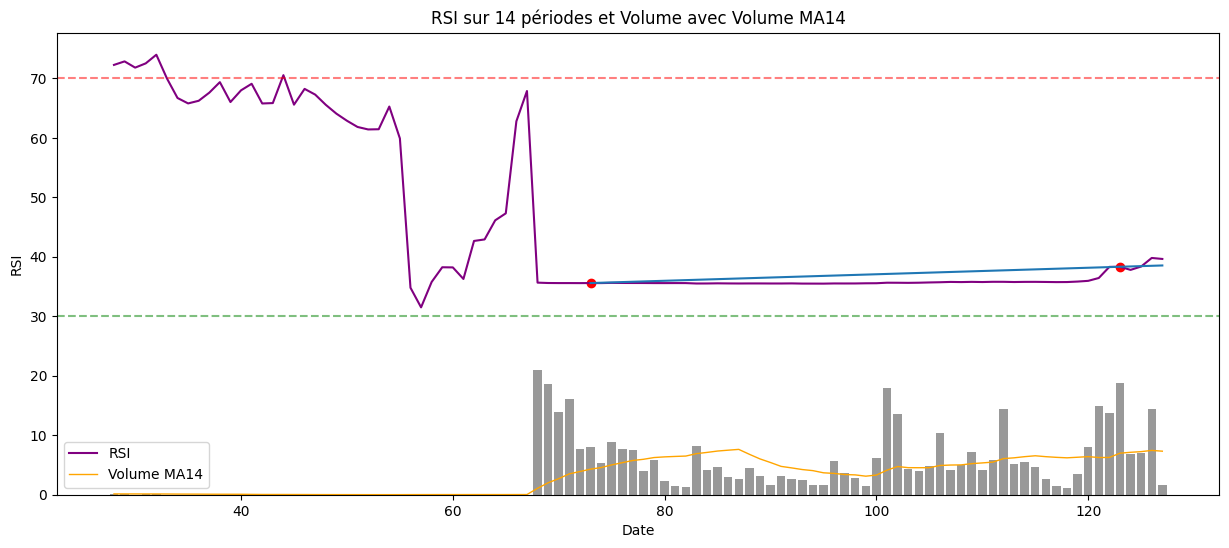

Asset: BNXUSDT, Score: 11, URL: https://www.tradingview.com/chart/?symbol=BINANCE:BNXUSDT&interval=1W


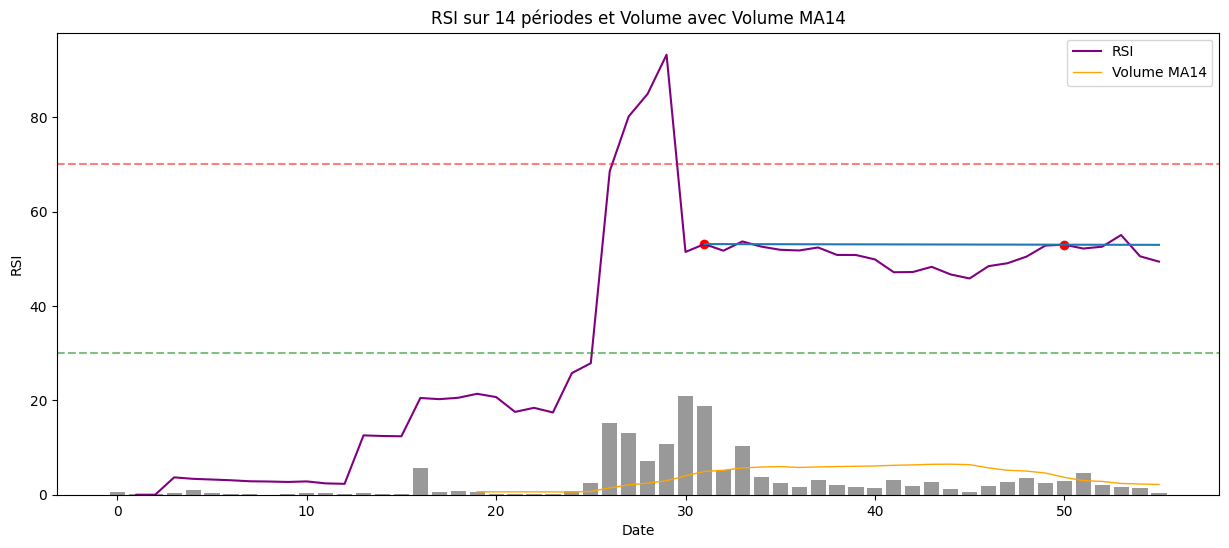

Asset: LOOMUSDT, Score: 5, URL: https://www.tradingview.com/chart/?symbol=BINANCE:LOOMUSDT&interval=1W


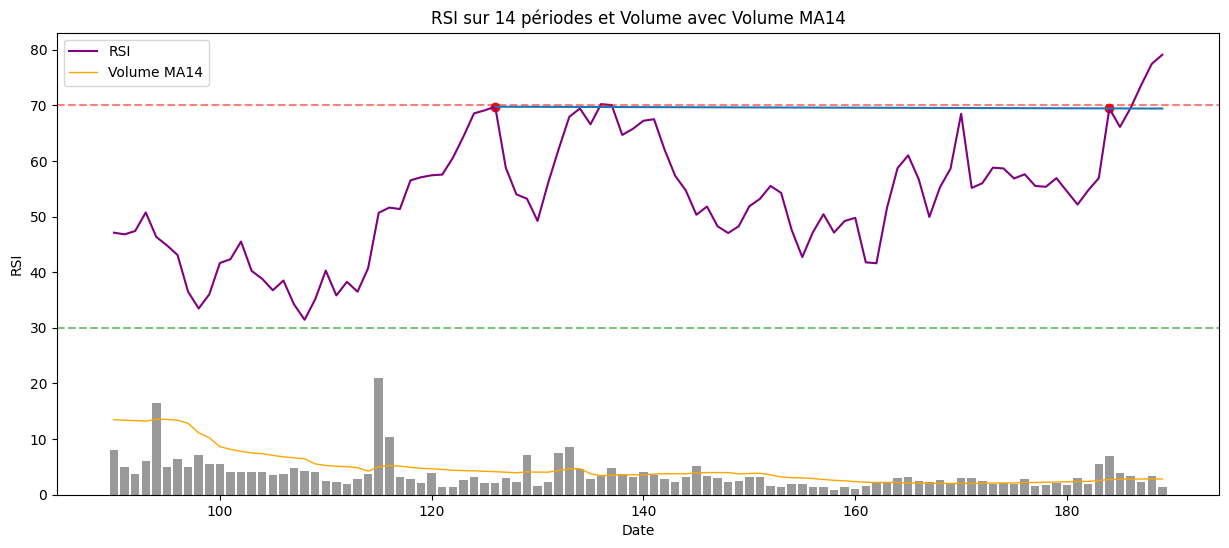

Asset: PAXGUSDT, Score: 5, URL: https://www.tradingview.com/chart/?symbol=BINANCE:PAXGUSDT&interval=1W


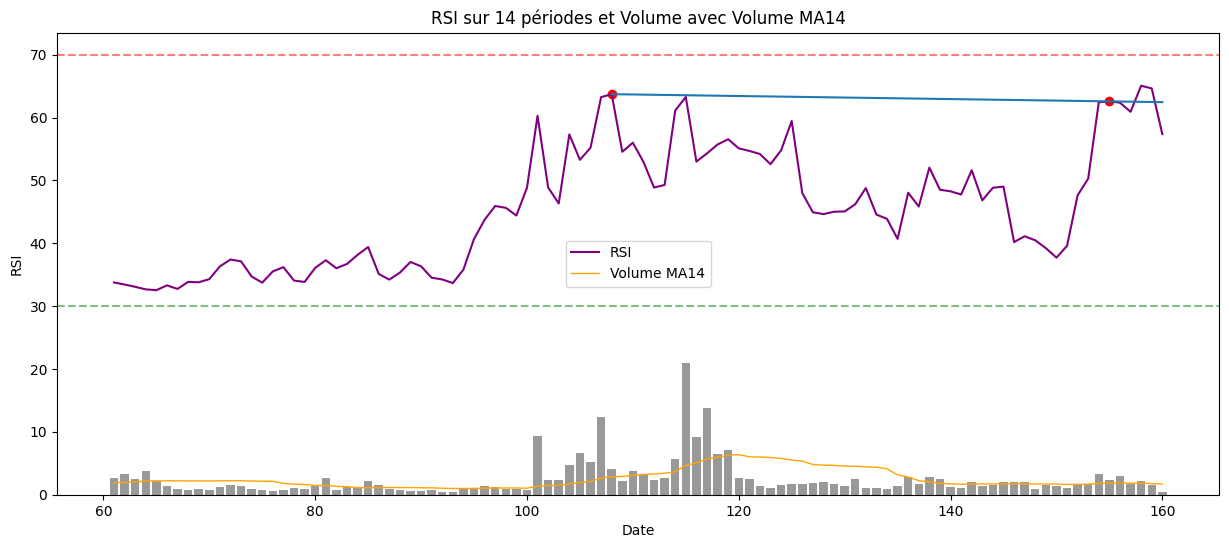

Asset: LINAUSDT, Score: 4, URL: https://www.tradingview.com/chart/?symbol=BINANCE:LINAUSDT&interval=1W


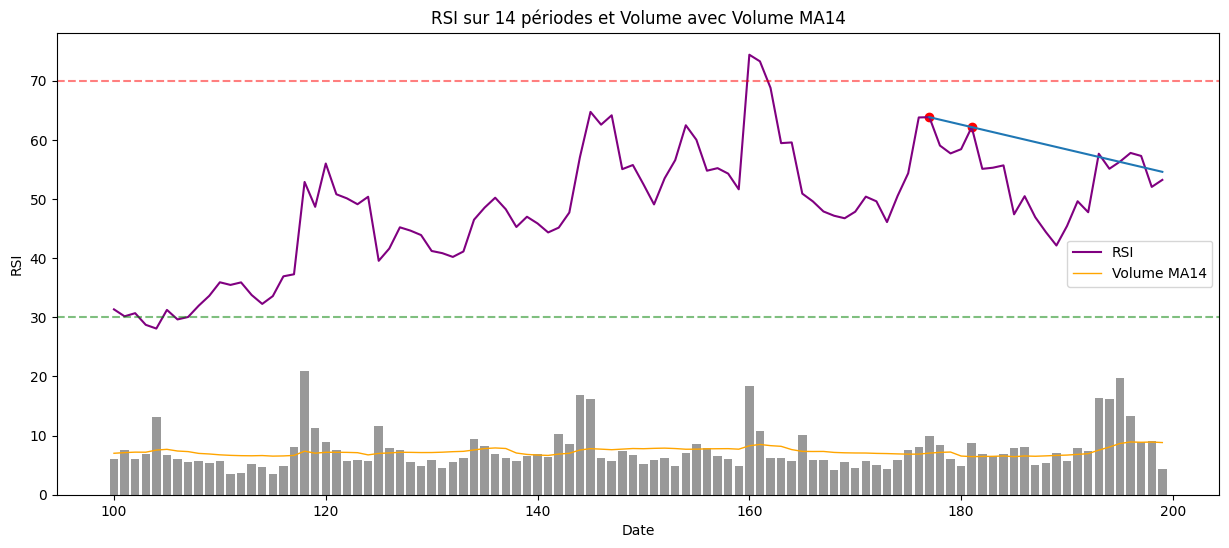

Asset: XRPUSDT, Score: 4, URL: https://www.tradingview.com/chart/?symbol=BINANCE:XRPUSDT&interval=1W


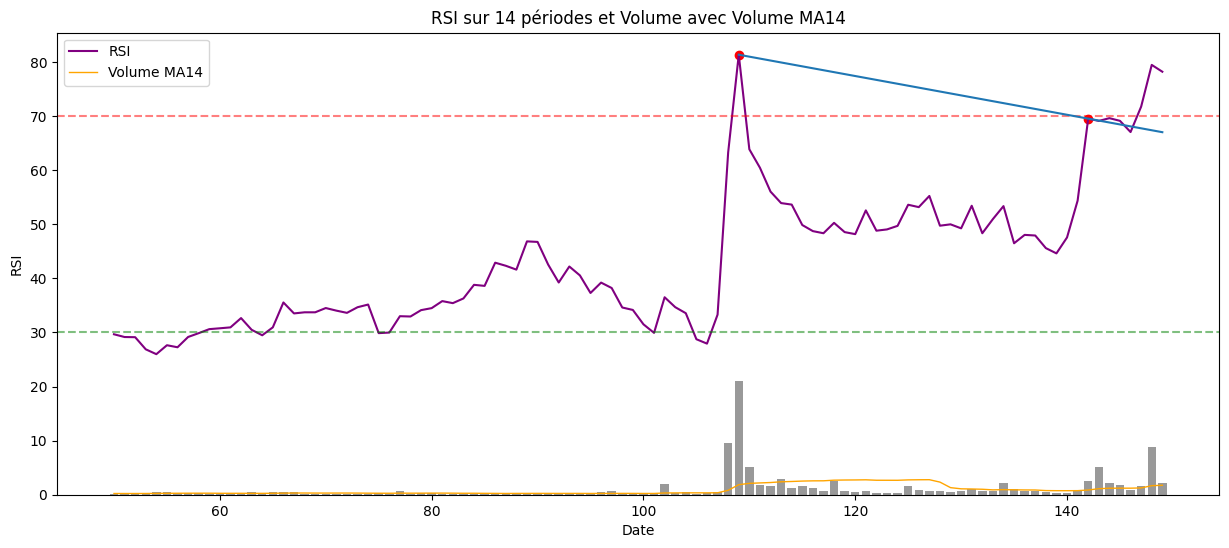

Asset: XVGUSDT, Score: 4, URL: https://www.tradingview.com/chart/?symbol=BINANCE:XVGUSDT&interval=1W


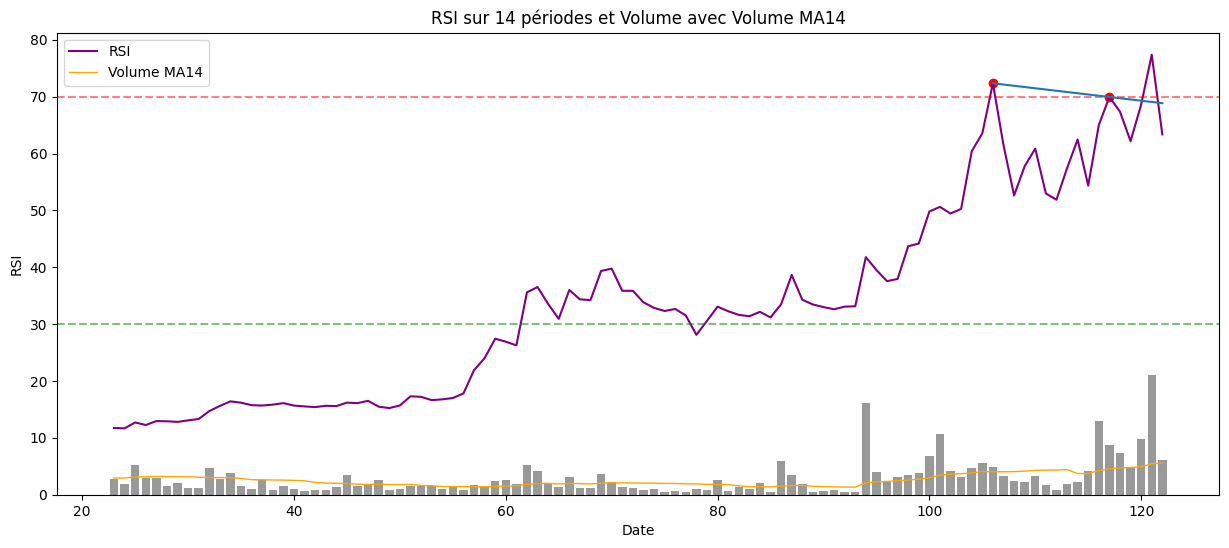

Asset: BICOUSDT, Score: 3, URL: https://www.tradingview.com/chart/?symbol=BINANCE:BICOUSDT&interval=1W


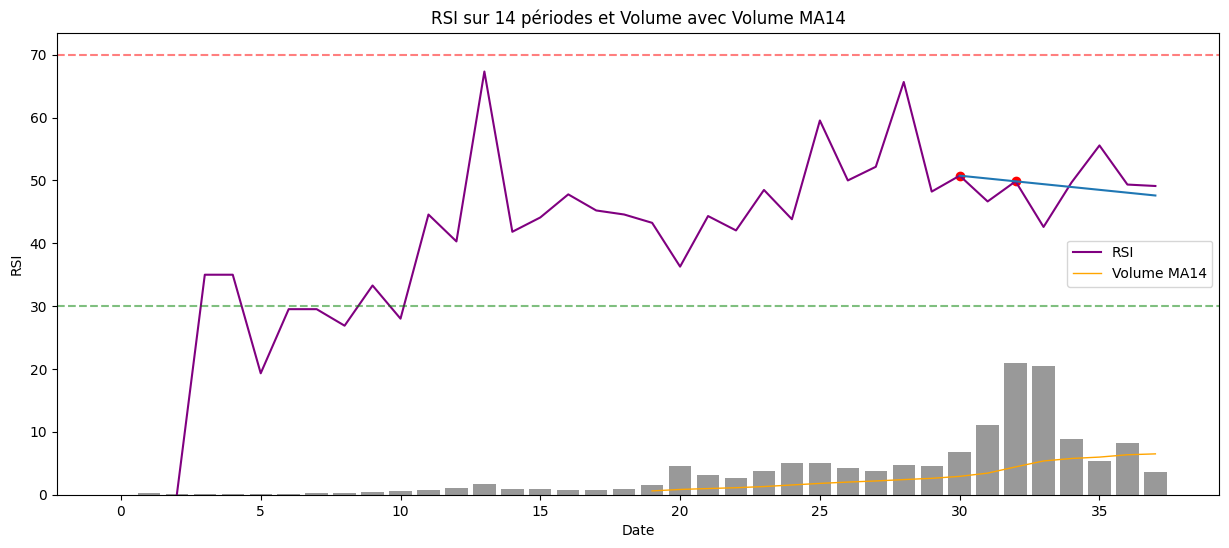

Asset: FDUSDUSDT, Score: 3, URL: https://www.tradingview.com/chart/?symbol=BINANCE:FDUSDUSDT&interval=1W


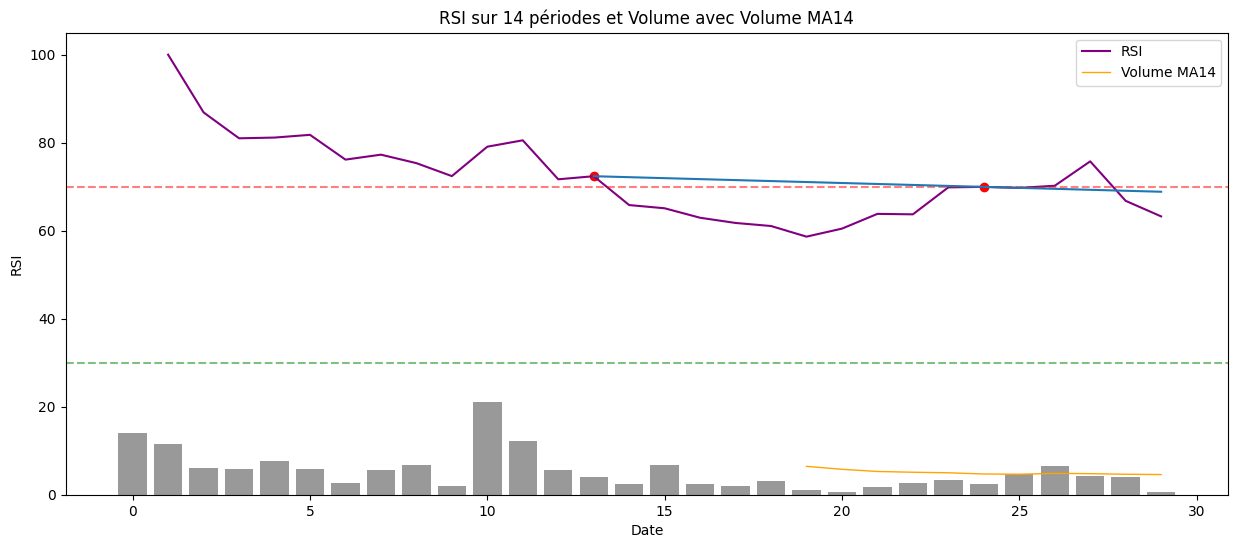

Asset: GFTUSDT, Score: 3, URL: https://www.tradingview.com/chart/?symbol=BINANCE:GFTUSDT&interval=1W


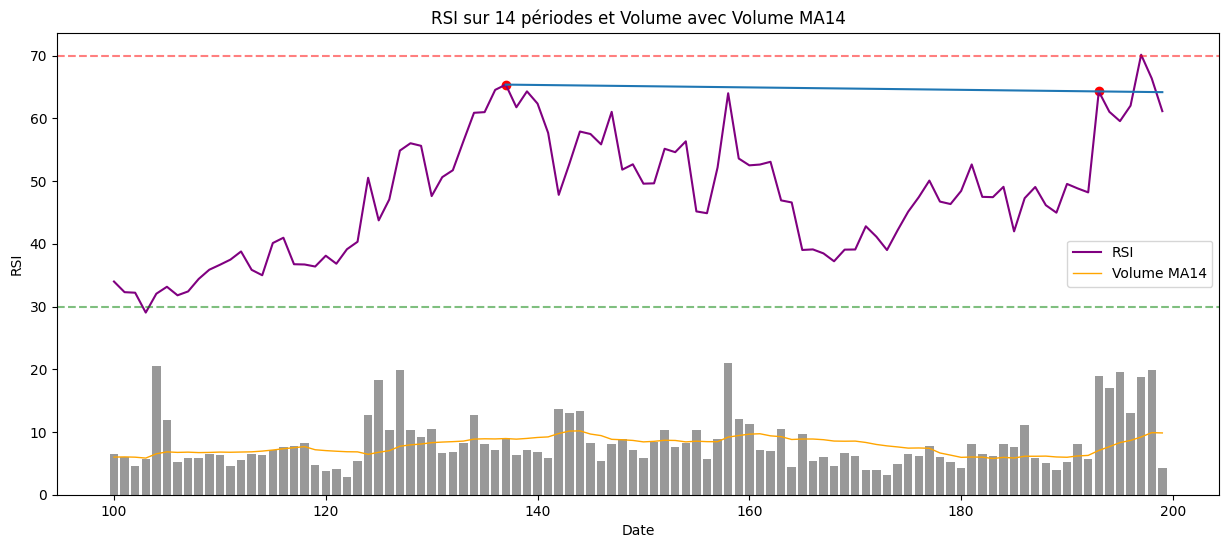

Asset: LTCUSDT, Score: 3, URL: https://www.tradingview.com/chart/?symbol=BINANCE:LTCUSDT&interval=1W


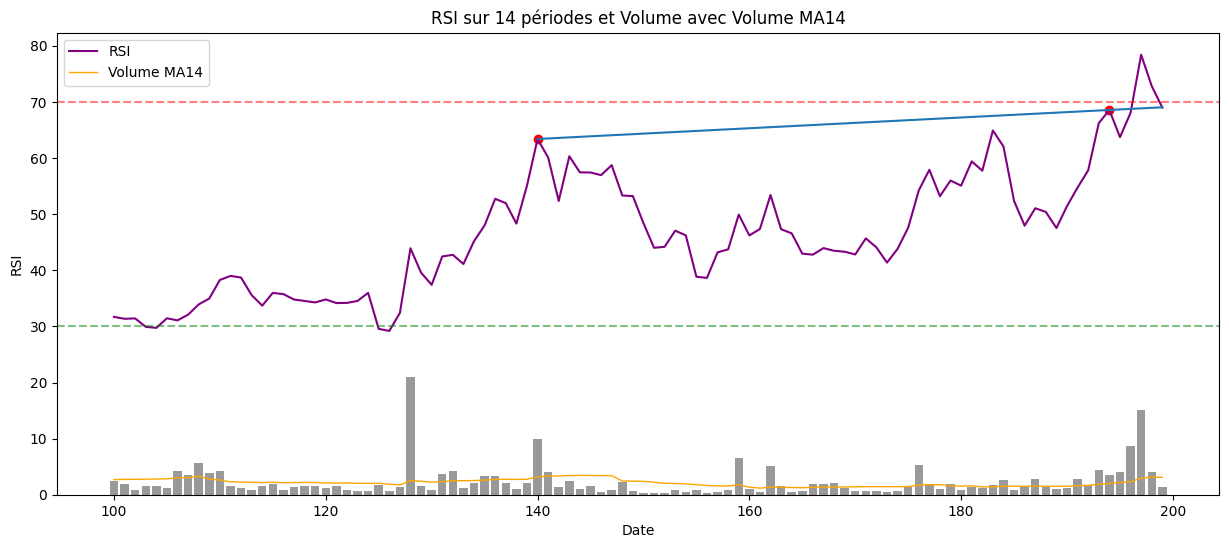

Asset: WANUSDT, Score: 3, URL: https://www.tradingview.com/chart/?symbol=BINANCE:WANUSDT&interval=1W


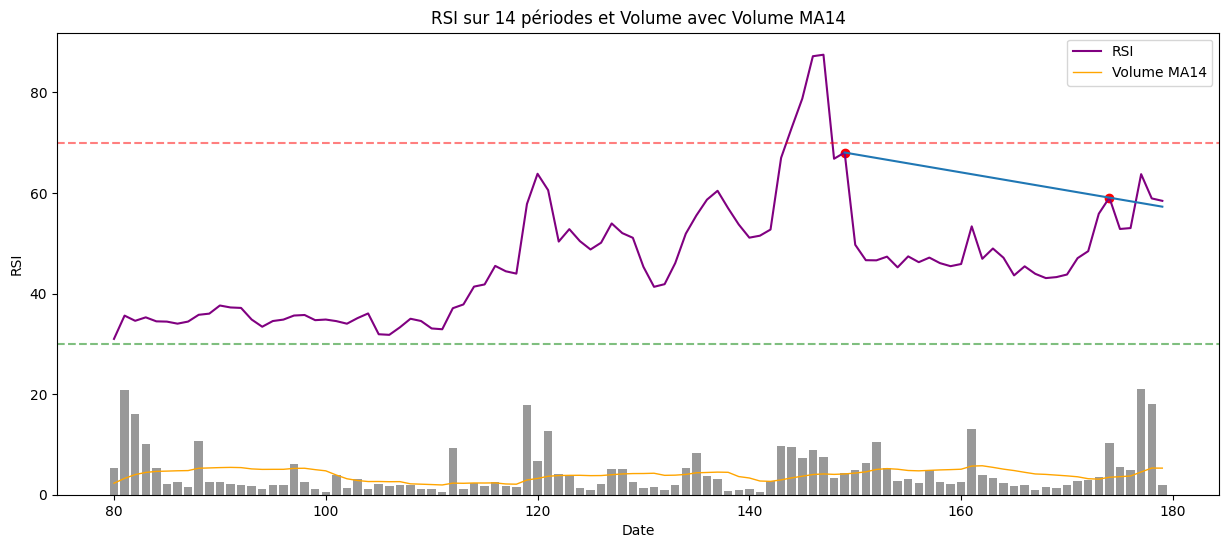

Asset: AKROUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:AKROUSDT&interval=1W


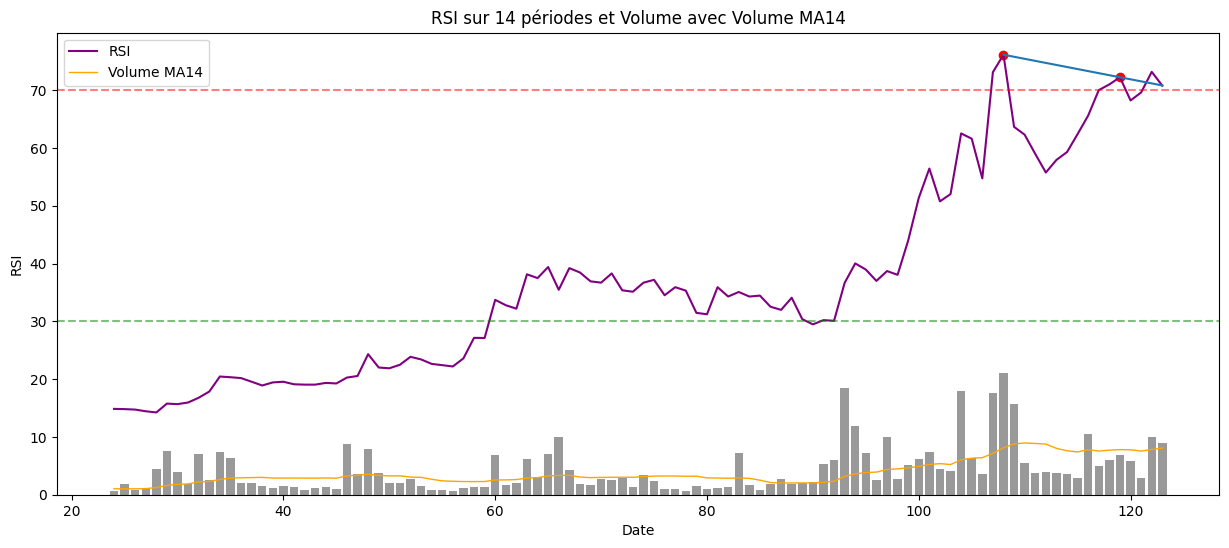

Asset: ALCXUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:ALCXUSDT&interval=1W


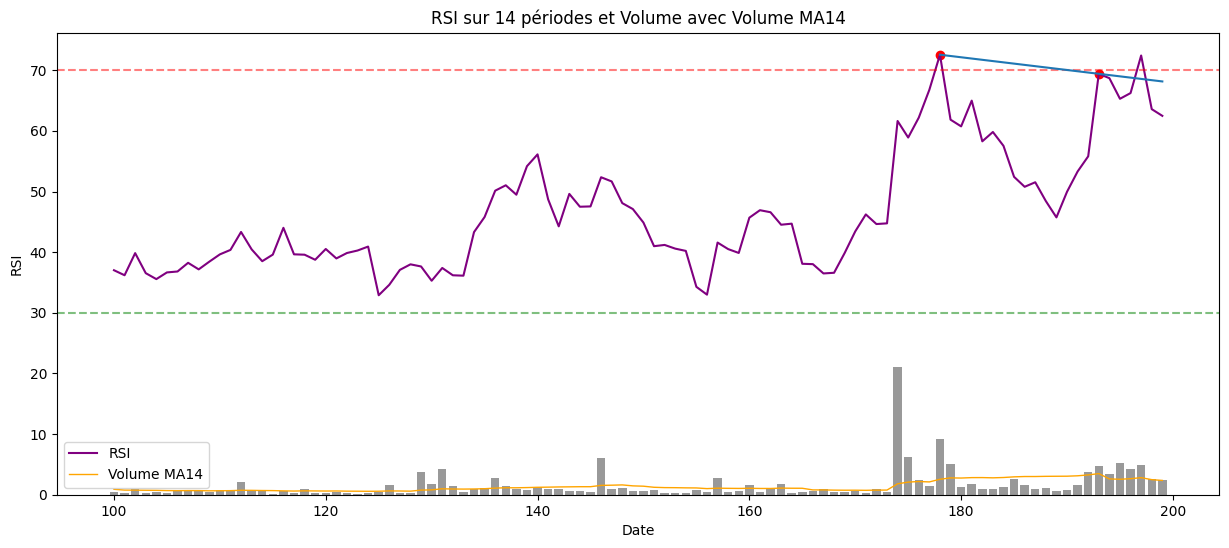

Asset: ARDRUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:ARDRUSDT&interval=1W


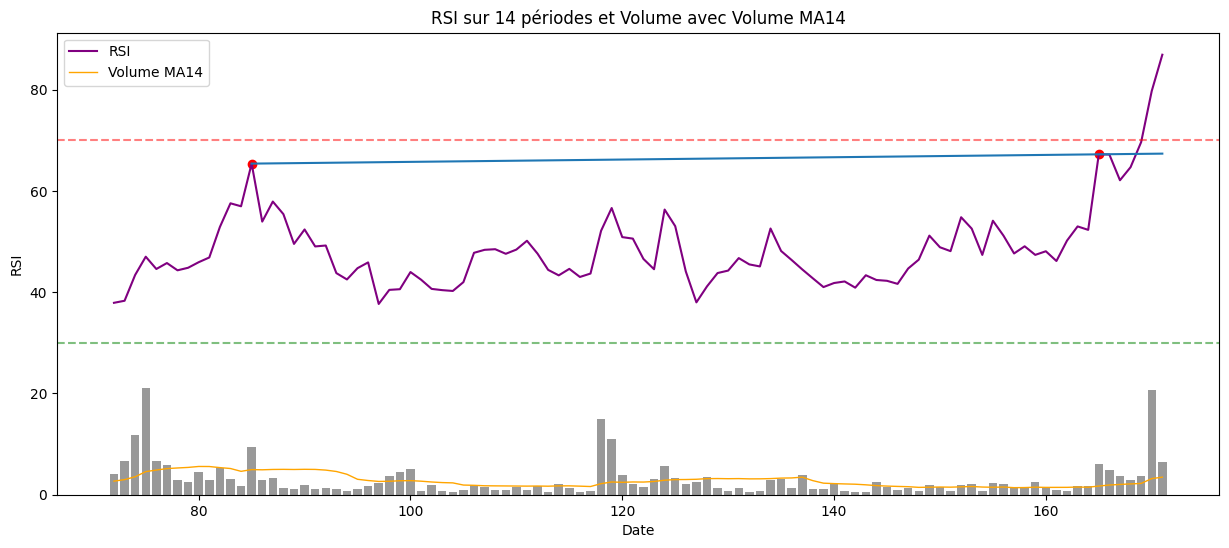

Asset: ASRUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:ASRUSDT&interval=1W


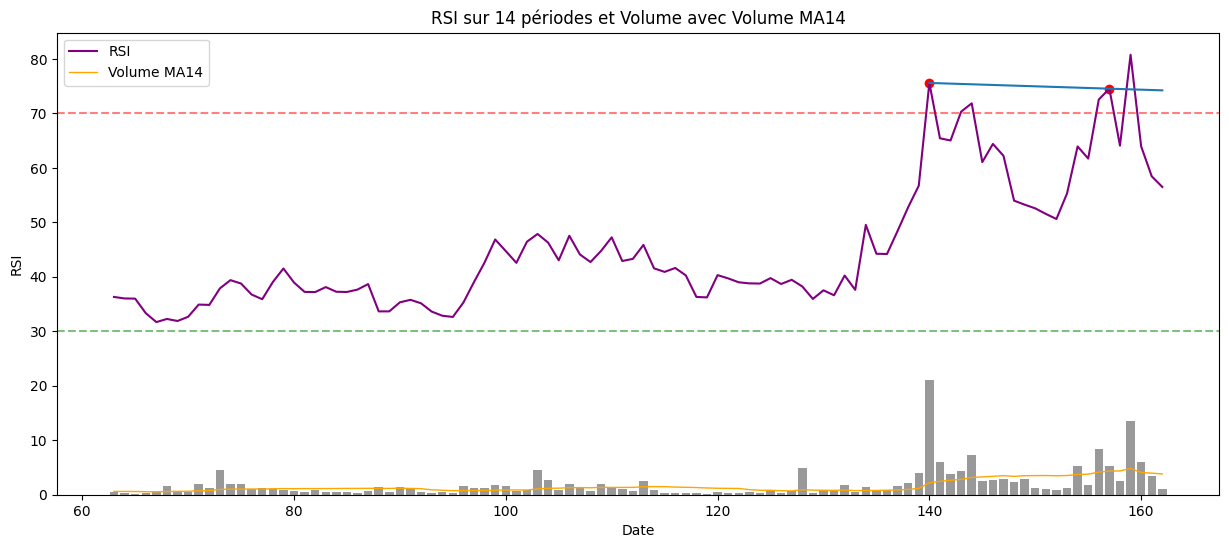

Asset: BADGERUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:BADGERUSDT&interval=1W


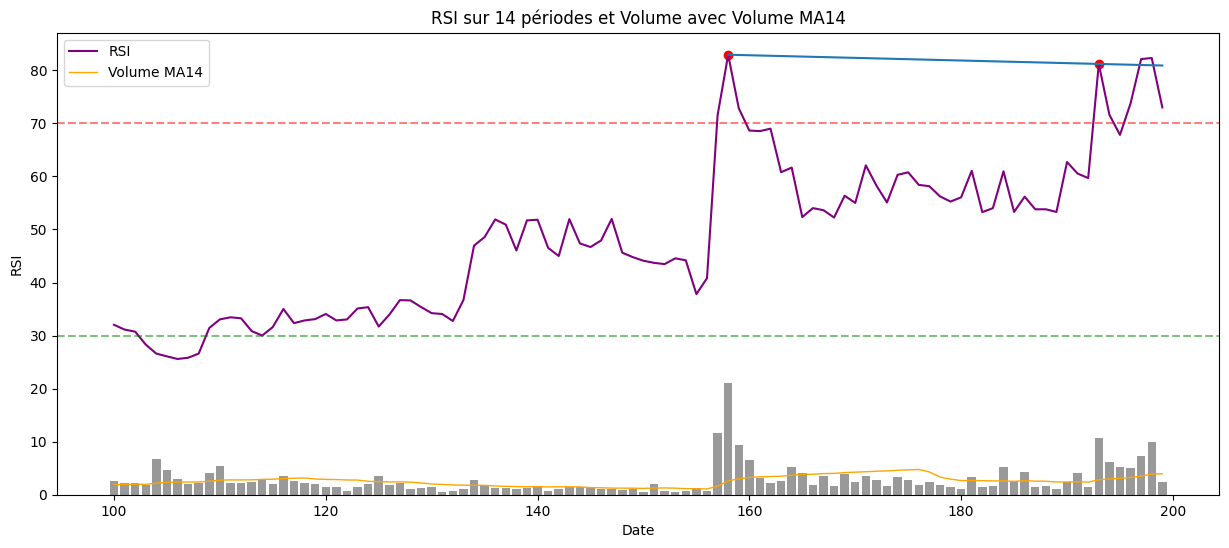

Asset: BCHUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:BCHUSDT&interval=1W


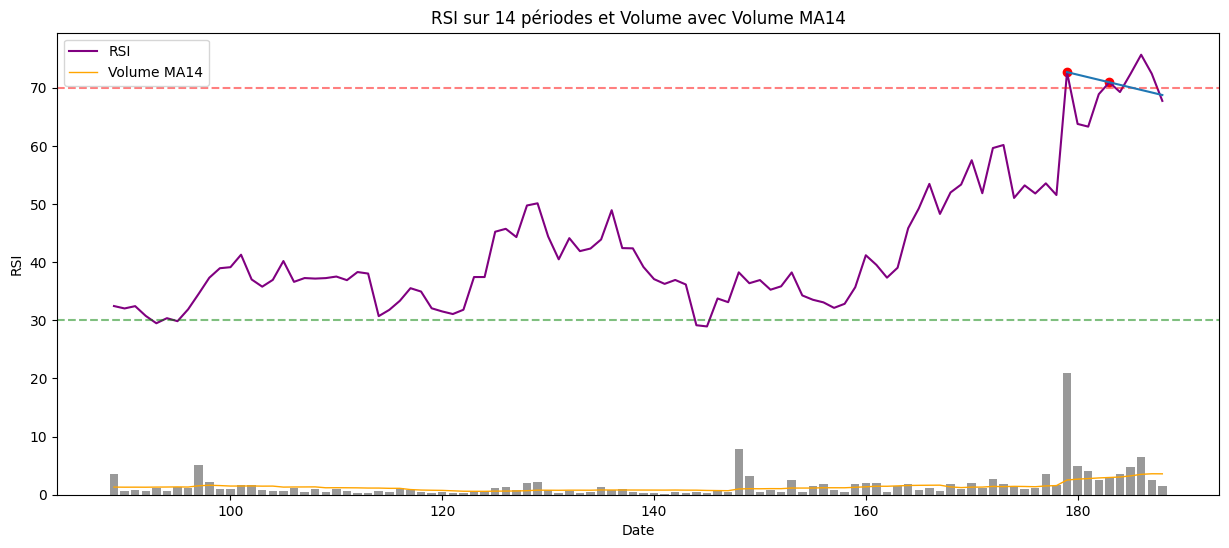

Asset: FIOUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:FIOUSDT&interval=1W


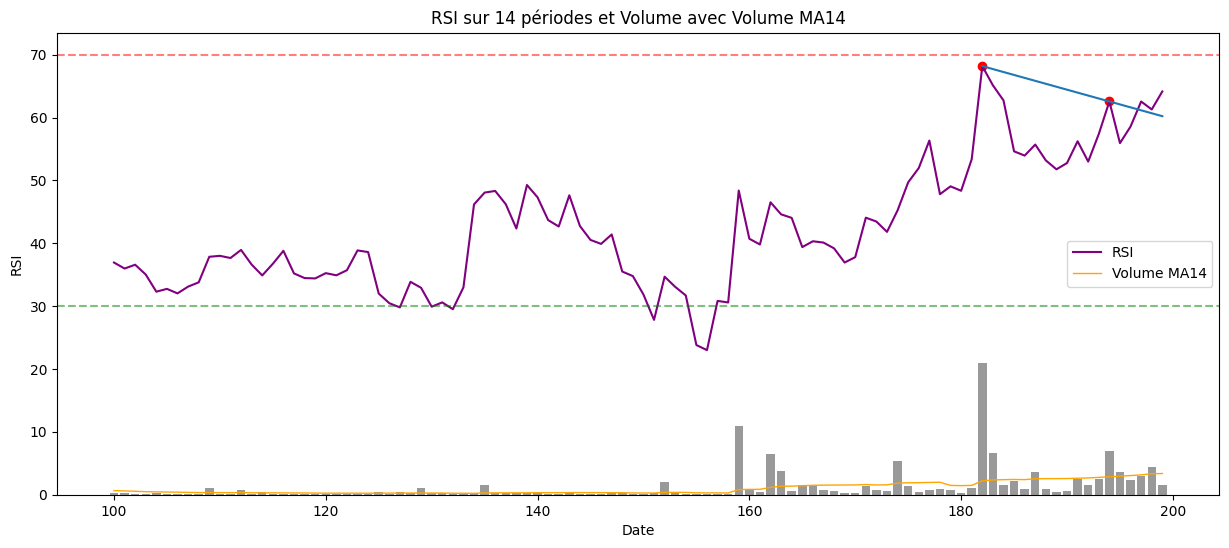

Asset: FUNUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:FUNUSDT&interval=1W


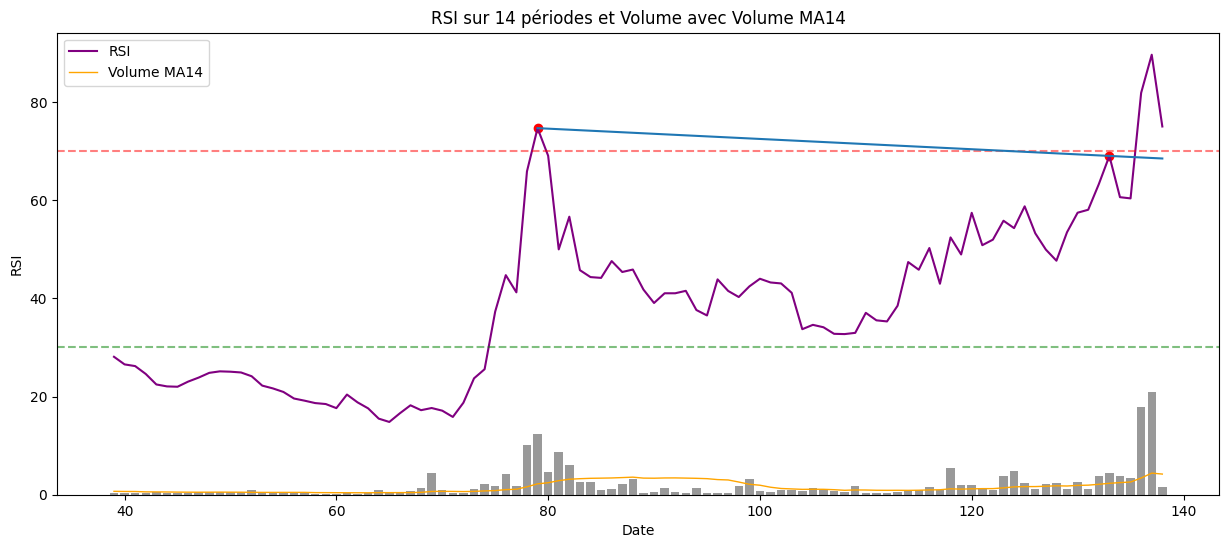

Asset: GHSTUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:GHSTUSDT&interval=1W


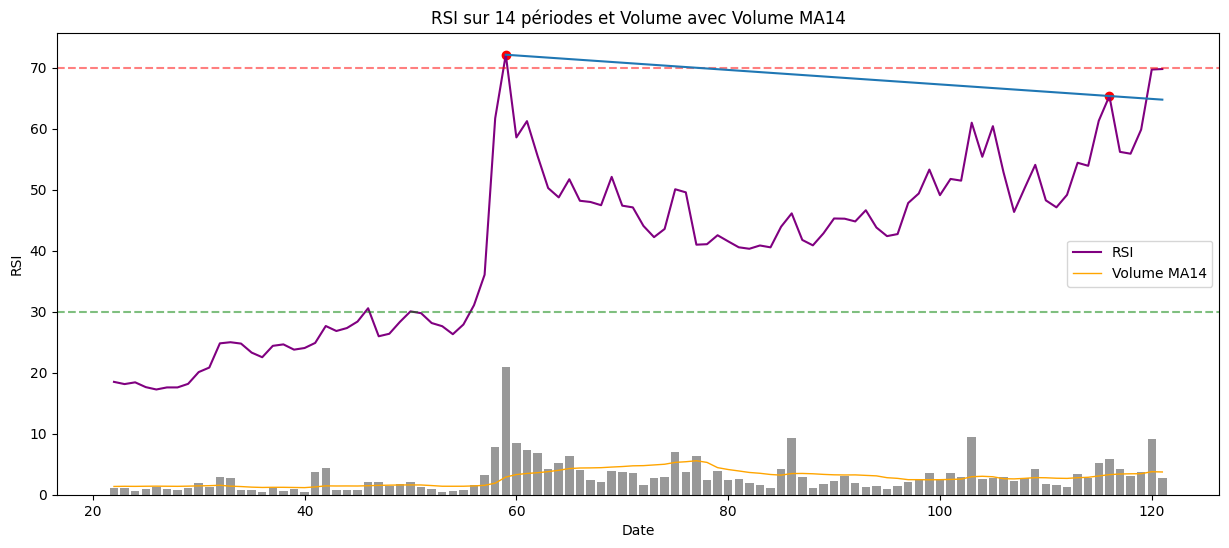

Asset: HIGHUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:HIGHUSDT&interval=1W


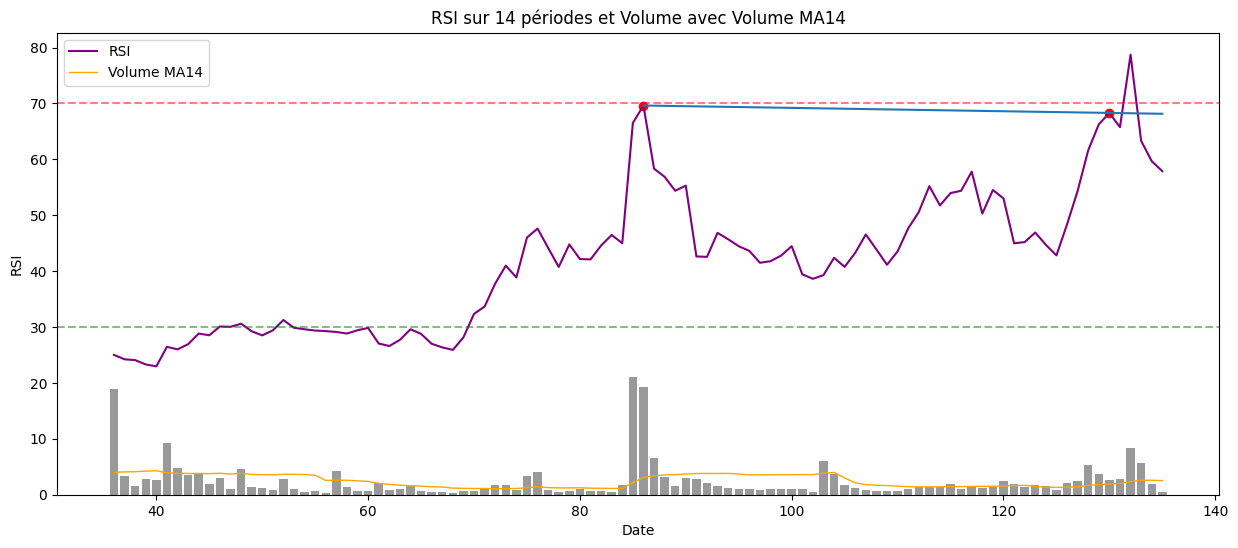

Asset: IDEXUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:IDEXUSDT&interval=1W


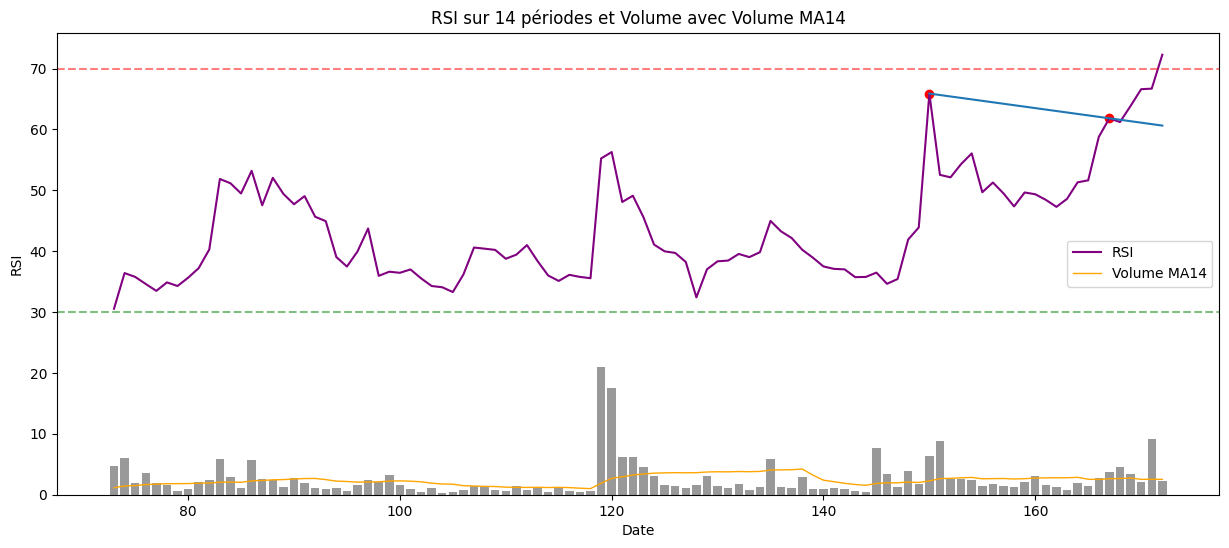

Asset: JUVUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:JUVUSDT&interval=1W


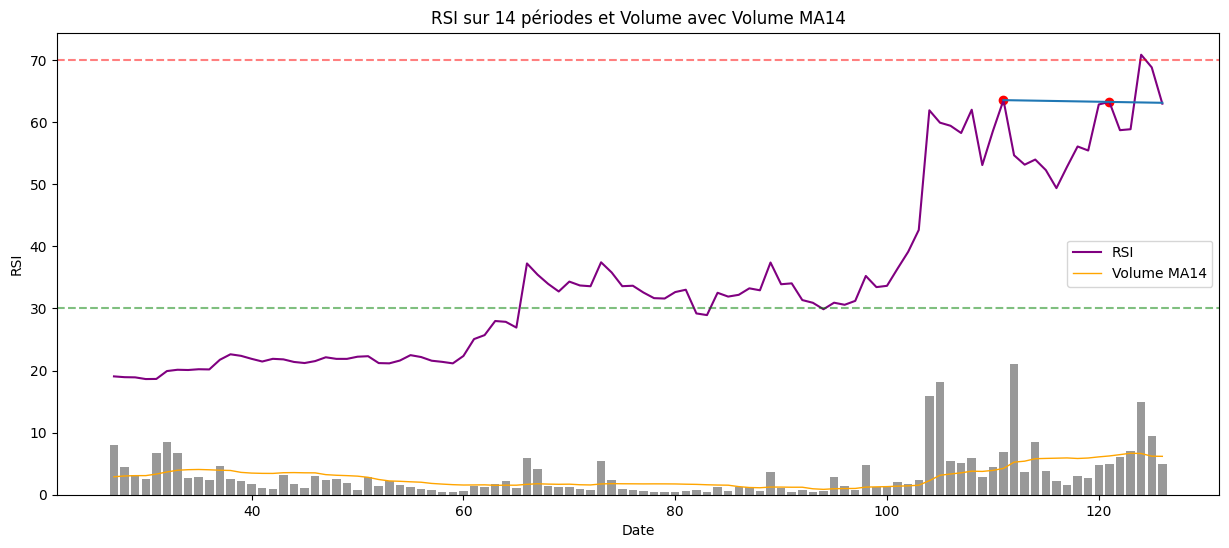

Asset: KP3RUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:KP3RUSDT&interval=1W


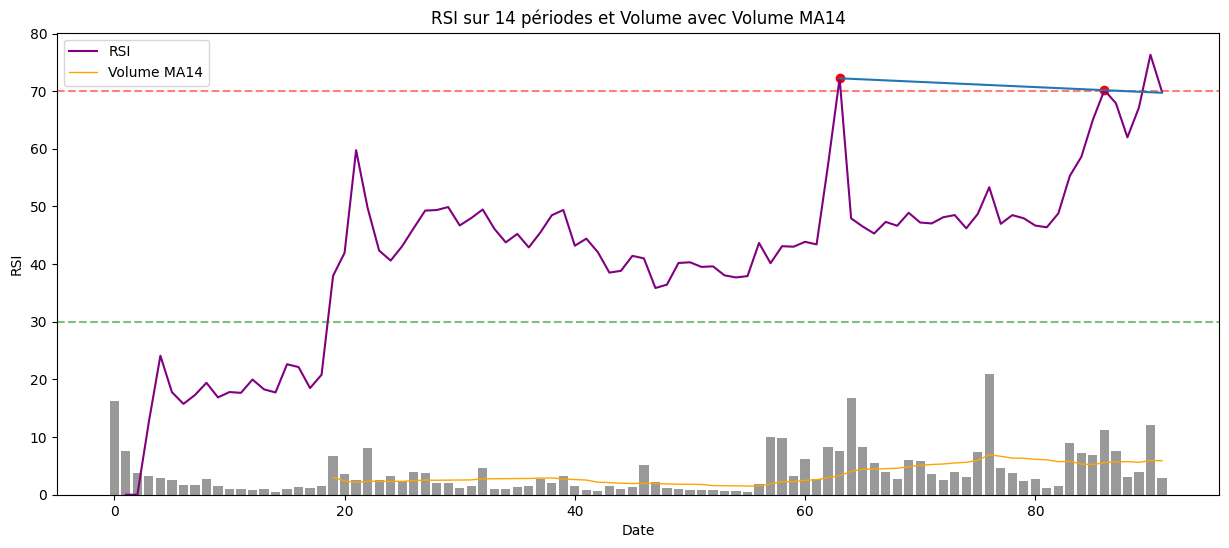

Asset: LEVERUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:LEVERUSDT&interval=1W


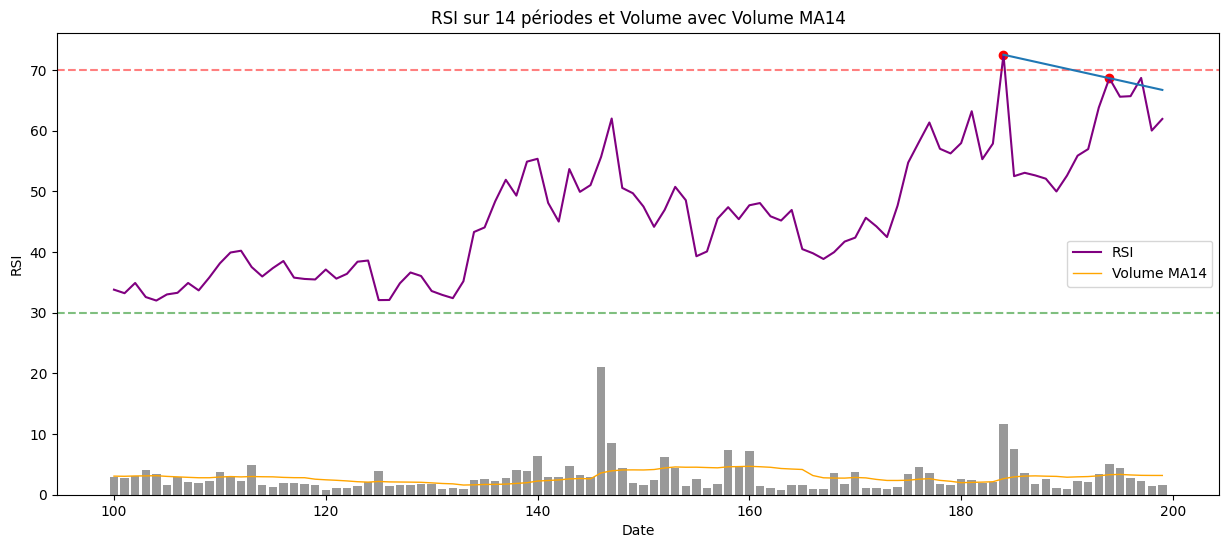

Asset: ONTUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:ONTUSDT&interval=1W


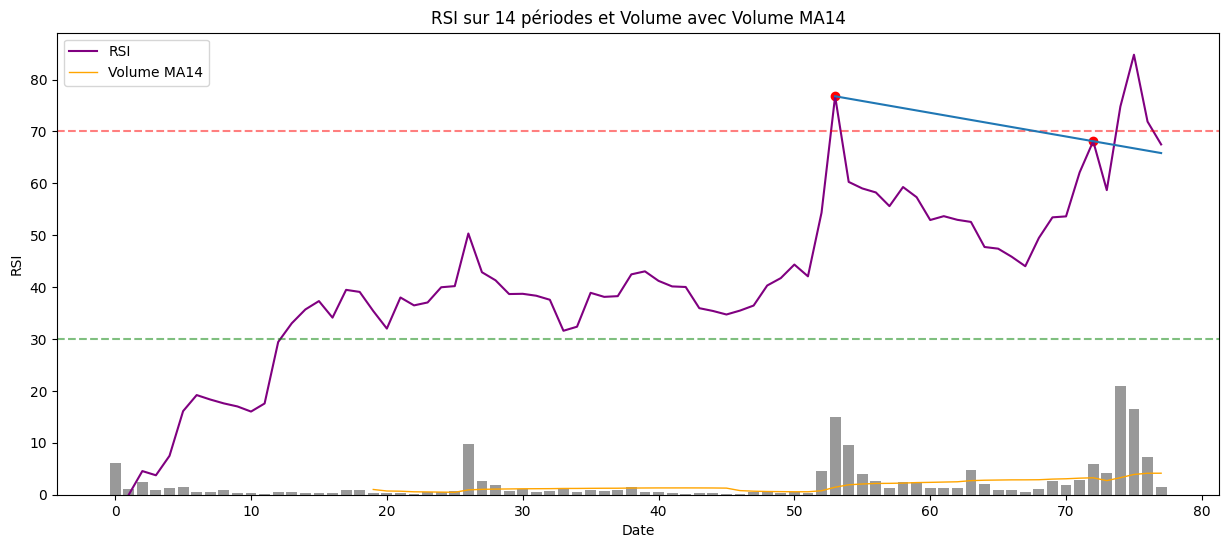

Asset: POLYXUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:POLYXUSDT&interval=1W


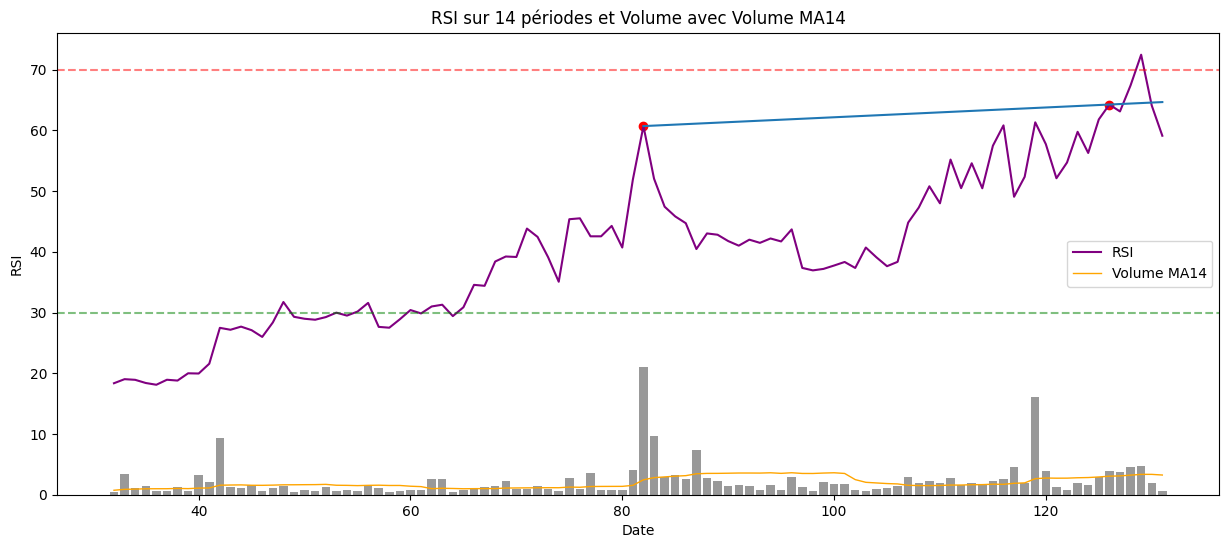

Asset: RADUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:RADUSDT&interval=1W


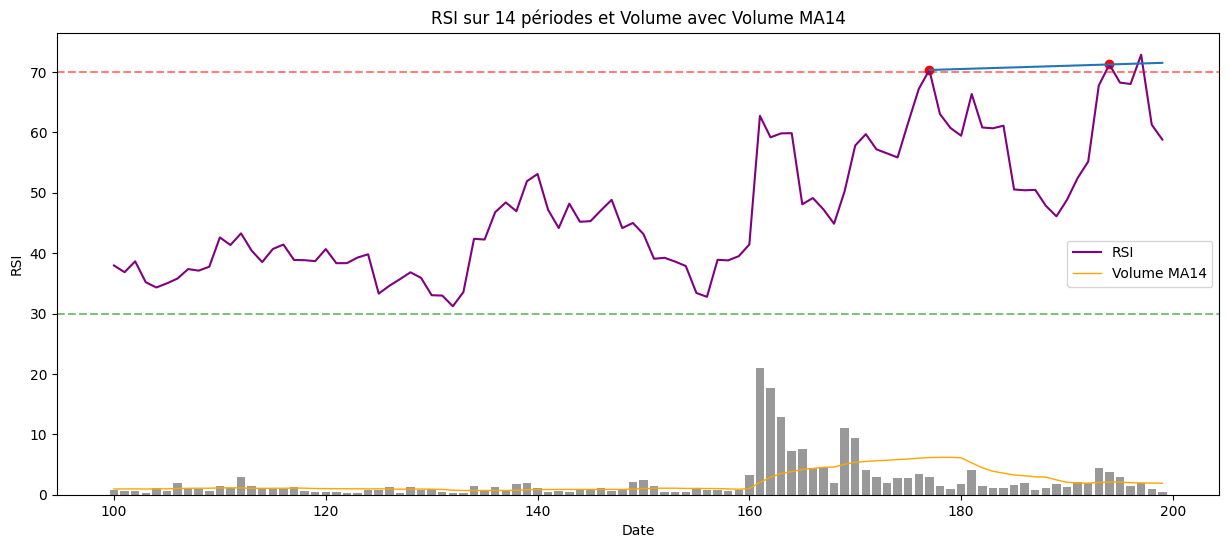

Asset: STMXUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:STMXUSDT&interval=1W


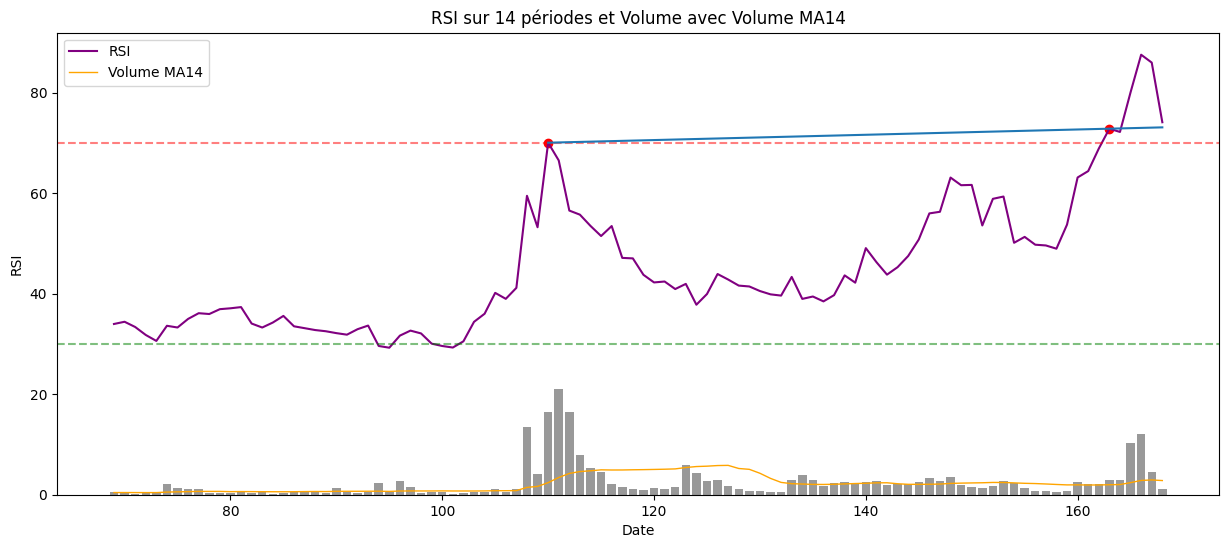

Asset: TRUUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:TRUUSDT&interval=1W


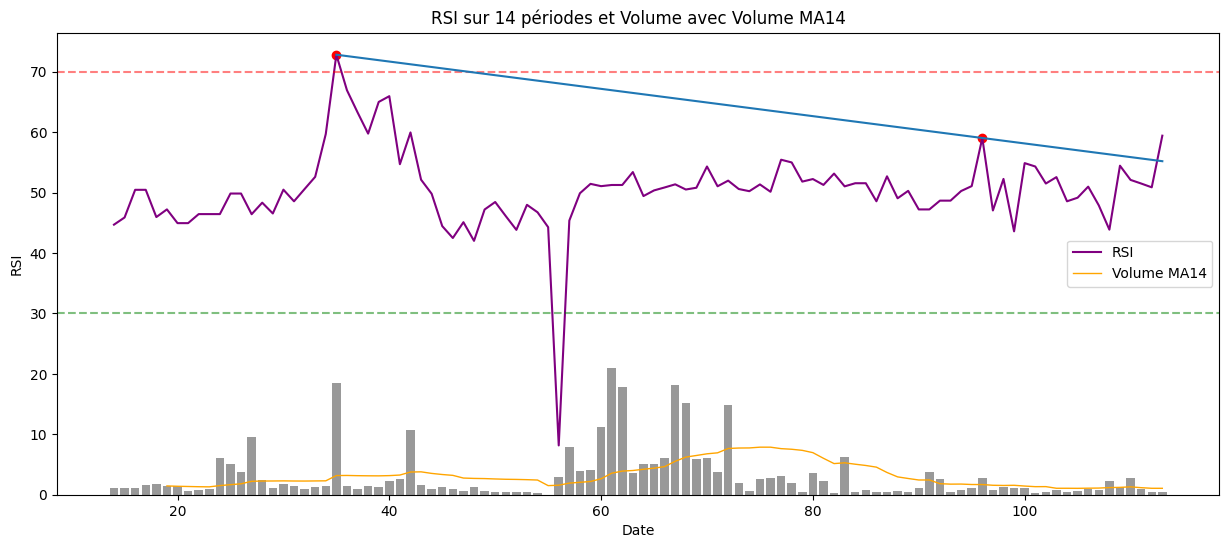

Asset: USDPUSDT, Score: 2, URL: https://www.tradingview.com/chart/?symbol=BINANCE:USDPUSDT&interval=1W


In [35]:
CRYPTO_NUMBER = 500

def display_crypto(best_lines, limit):
    for (line, pair, df_rsi) in best_lines:
        plot_rsi_with_line(line.x_1, line.x_2, line.y_1, line.y_2, df_rsi=df_rsi, limit=limit)
        print(f"Asset: {pair}, Score: {line.score}, URL: https://www.tradingview.com/chart/?symbol=BINANCE:{pair}&interval=1W")


def screen_best_asset(limit=100):
    pairs = get_spot_pairs()
    best_lines = list()

    for pair in pairs[:CRYPTO_NUMBER]:
        df = get_pair_df(pair=pair, limit=HISTORY_LIMIT, frequency="1w")
        get_best_valid_line(best_lines, pair, df, limit)

    best_lines.sort(key=lambda x: x[0].score, reverse=True)
    display_crypto(best_lines, limit)

screen_best_asset(limit=100)

## Stocks

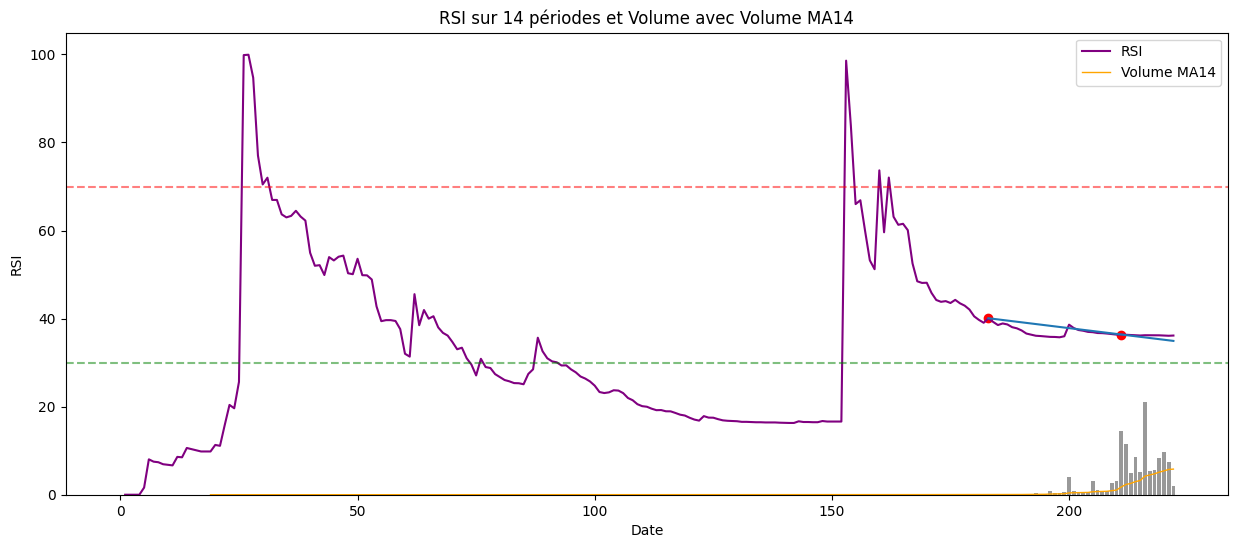

Asset: ALEUP.PA, Score: 13, URL: https://www.tradingview.com/chart/?symbol=ALEUP&interval=1W


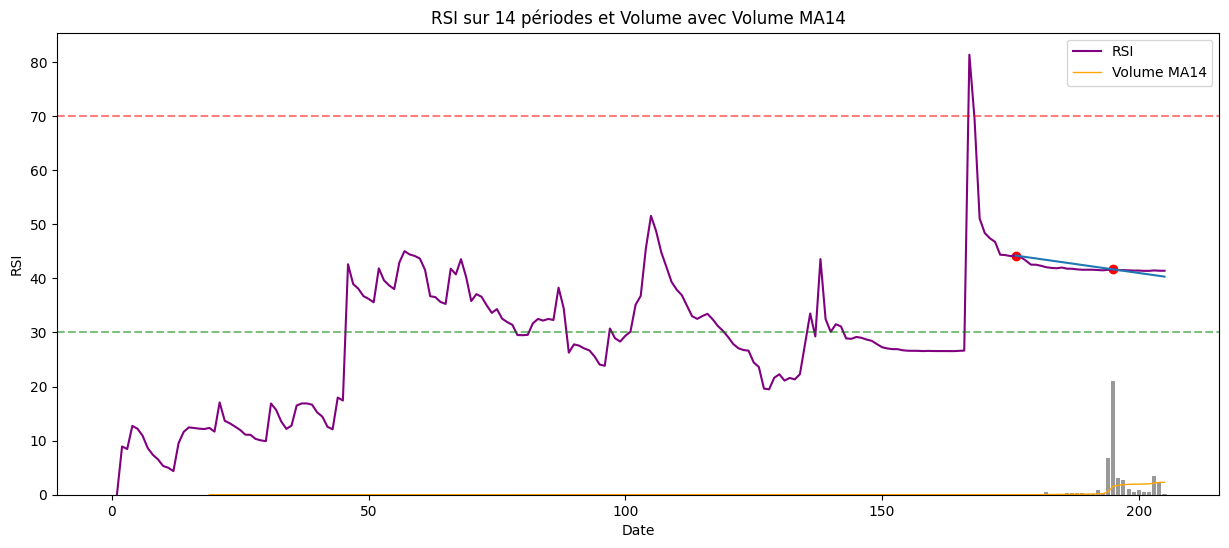

Asset: ALBOO.PA, Score: 12, URL: https://www.tradingview.com/chart/?symbol=ALBOO&interval=1W


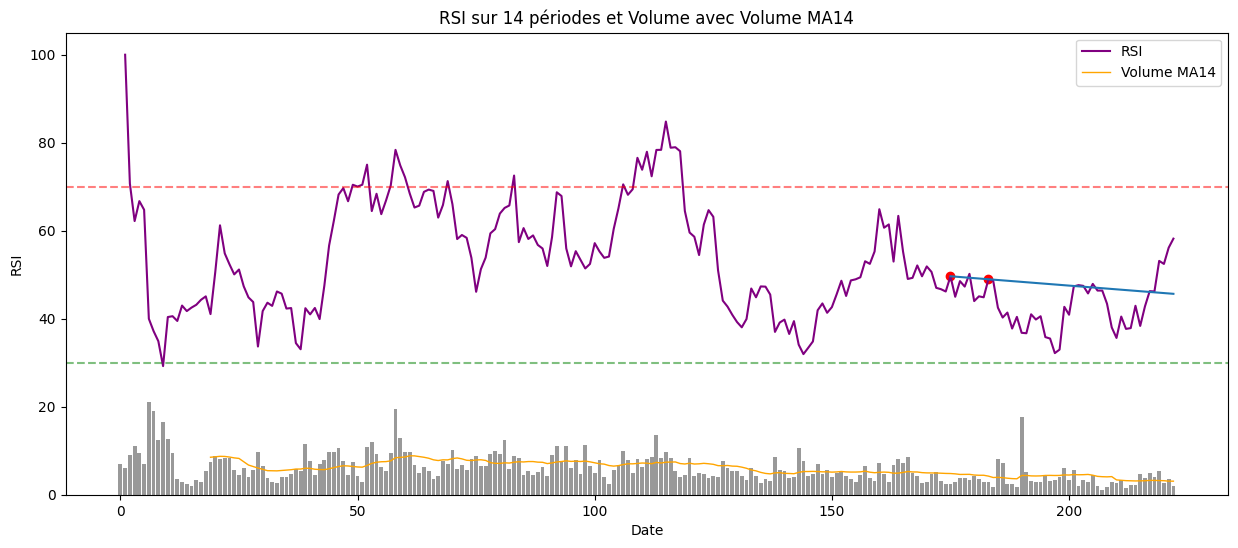

Asset: ERA.PA, Score: 9, URL: https://www.tradingview.com/chart/?symbol=ERA&interval=1W


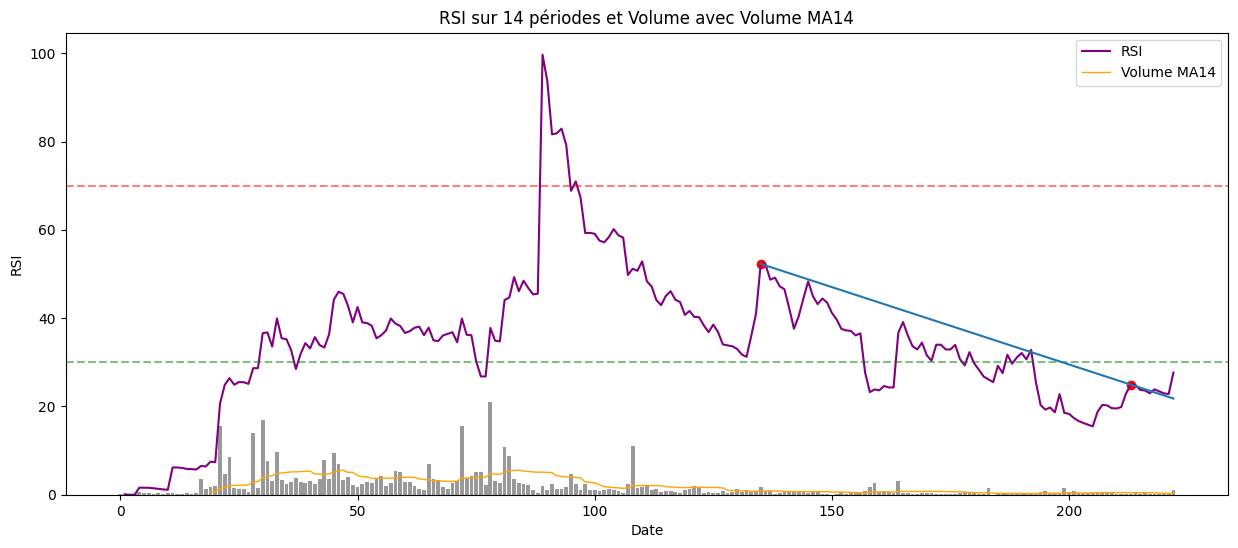

Asset: ALMND.PA, Score: 9, URL: https://www.tradingview.com/chart/?symbol=ALMND&interval=1W


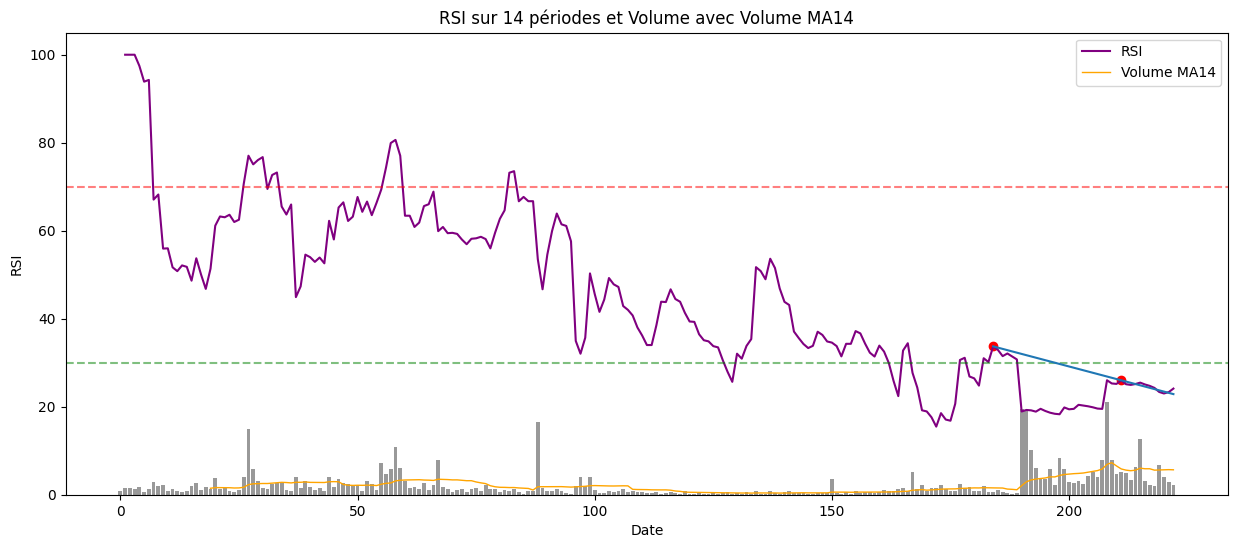

Asset: NHOA.PA, Score: 9, URL: https://www.tradingview.com/chart/?symbol=NHOA&interval=1W


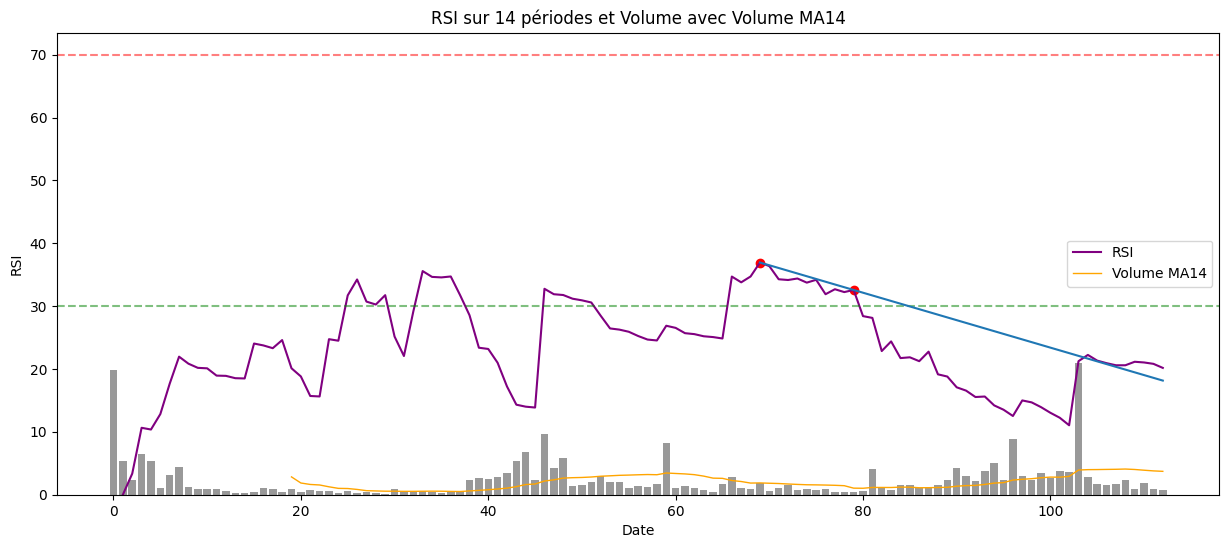

Asset: ALHAF.PA, Score: 8, URL: https://www.tradingview.com/chart/?symbol=ALHAF&interval=1W


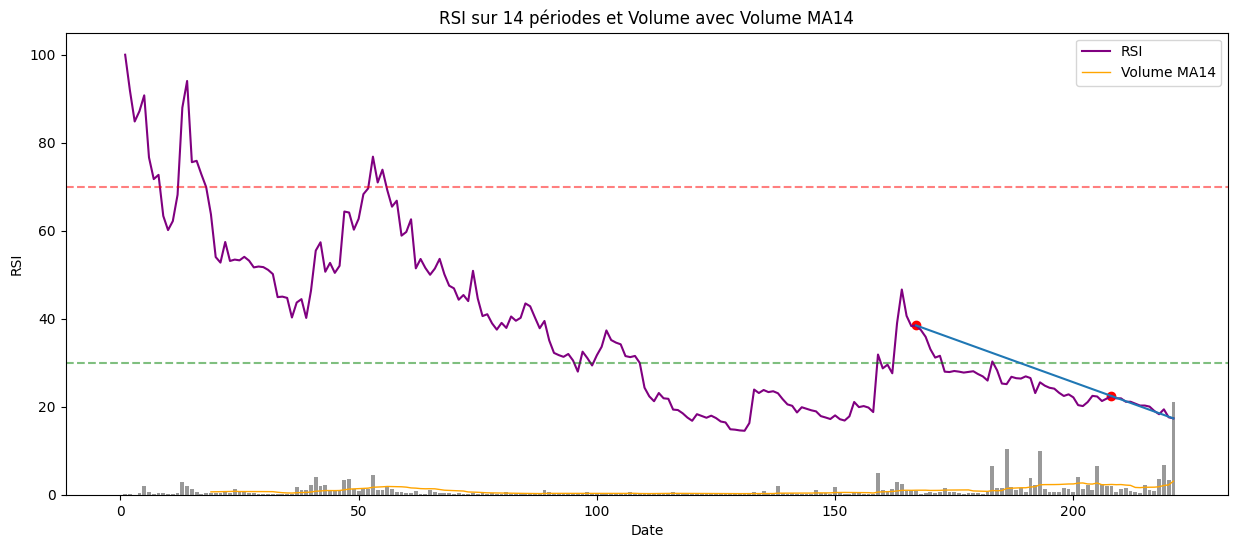

Asset: ALBPS.PA, Score: 7, URL: https://www.tradingview.com/chart/?symbol=ALBPS&interval=1W


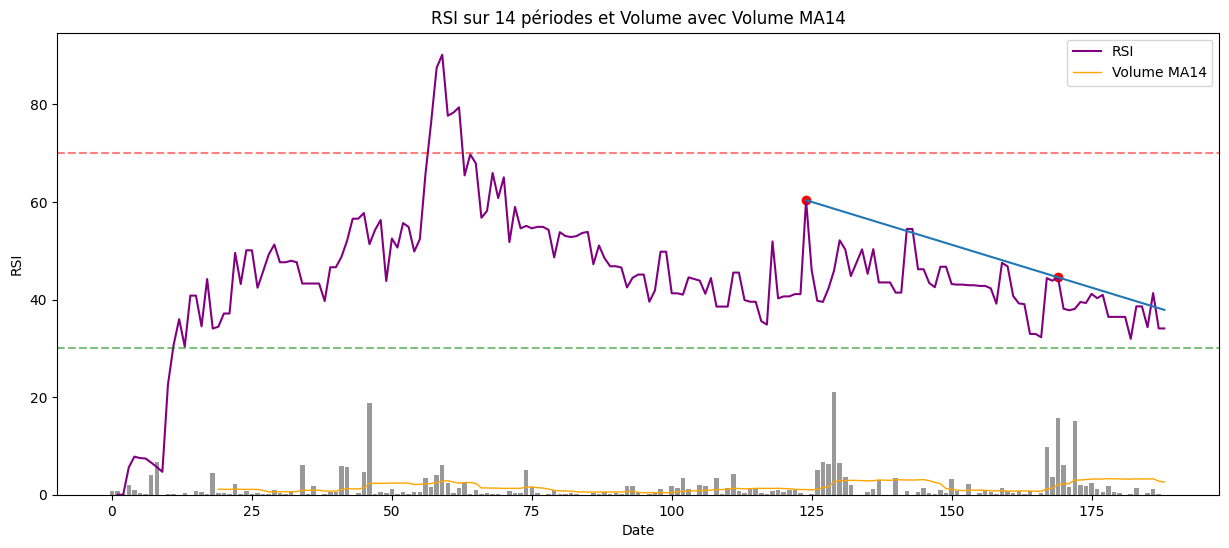

Asset: MLCLP.PA, Score: 7, URL: https://www.tradingview.com/chart/?symbol=MLCLP&interval=1W


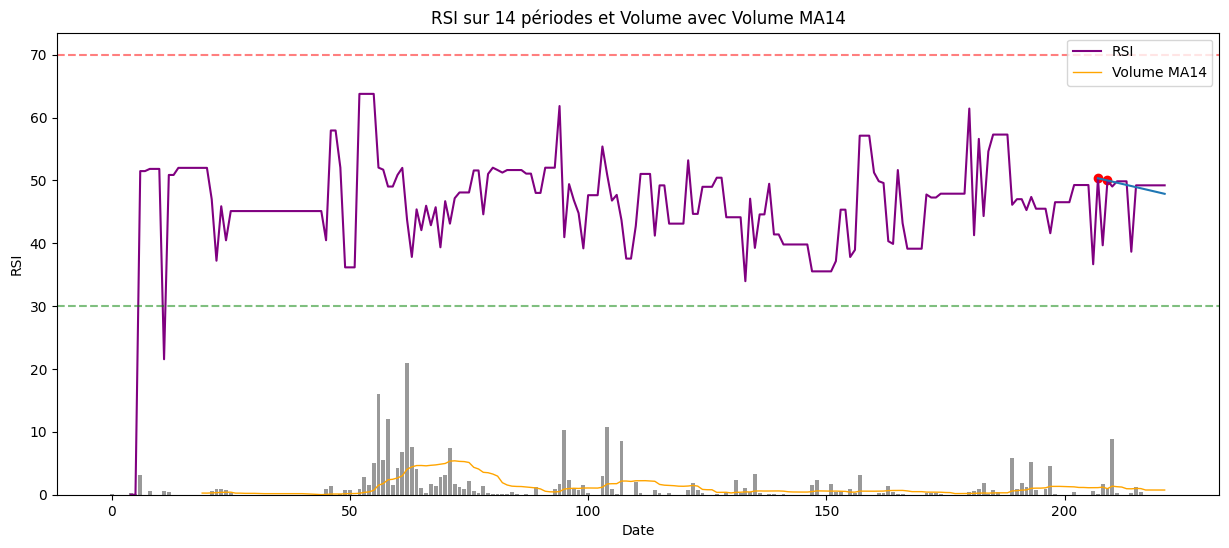

Asset: ALENR.PA, Score: 7, URL: https://www.tradingview.com/chart/?symbol=ALENR&interval=1W


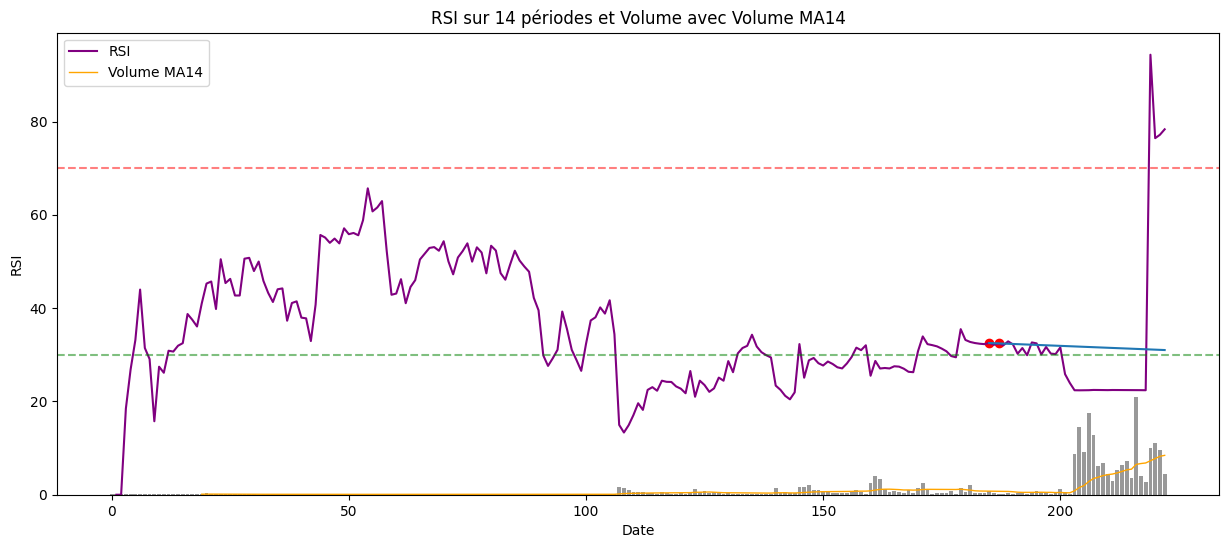

Asset: ORP.PA, Score: 7, URL: https://www.tradingview.com/chart/?symbol=ORP&interval=1W


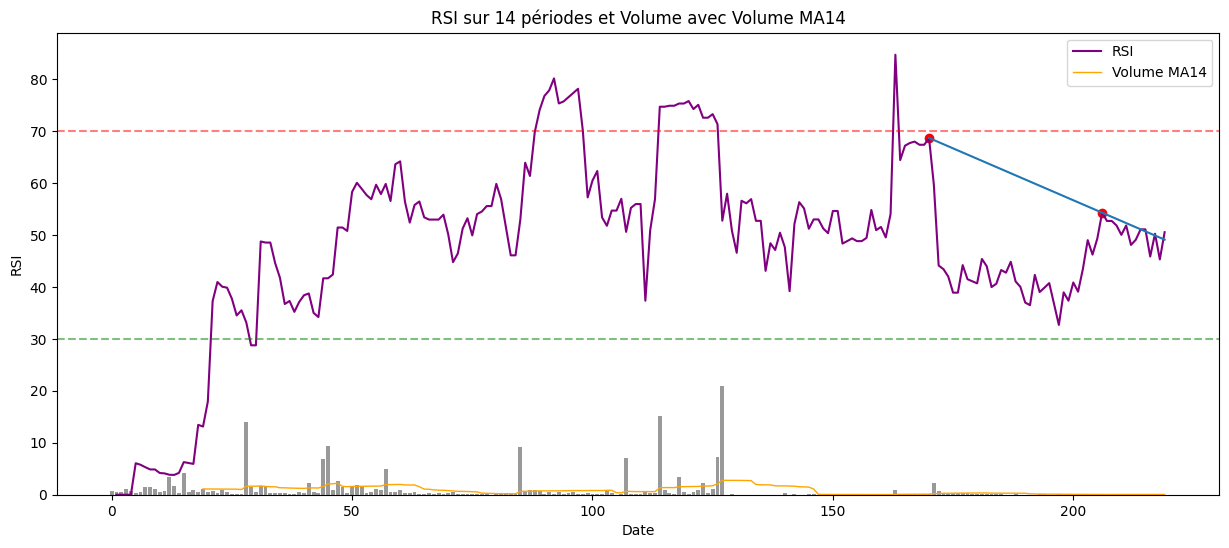

Asset: ALMIL.PA, Score: 6, URL: https://www.tradingview.com/chart/?symbol=ALMIL&interval=1W


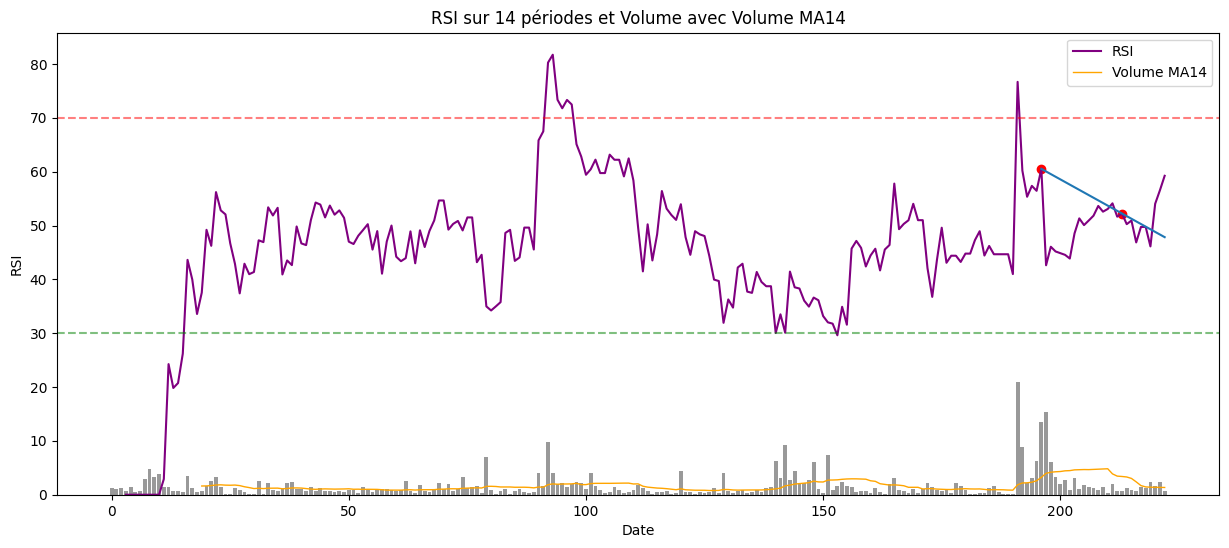

Asset: ACAN.PA, Score: 6, URL: https://www.tradingview.com/chart/?symbol=ACAN&interval=1W


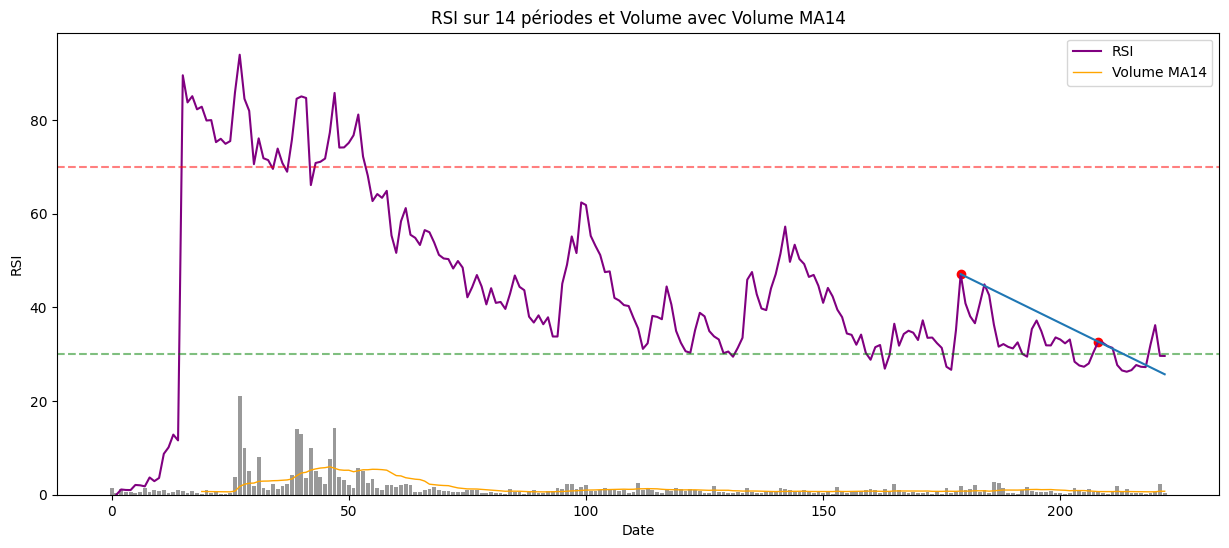

Asset: ALGAU.PA, Score: 6, URL: https://www.tradingview.com/chart/?symbol=ALGAU&interval=1W


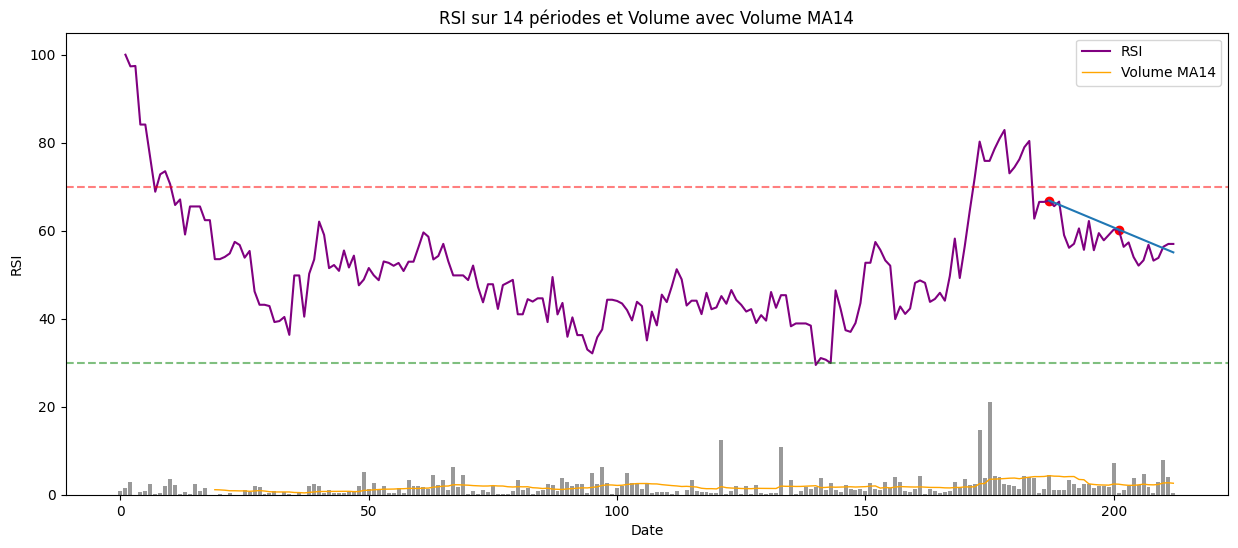

Asset: HDP.PA, Score: 6, URL: https://www.tradingview.com/chart/?symbol=HDP&interval=1W


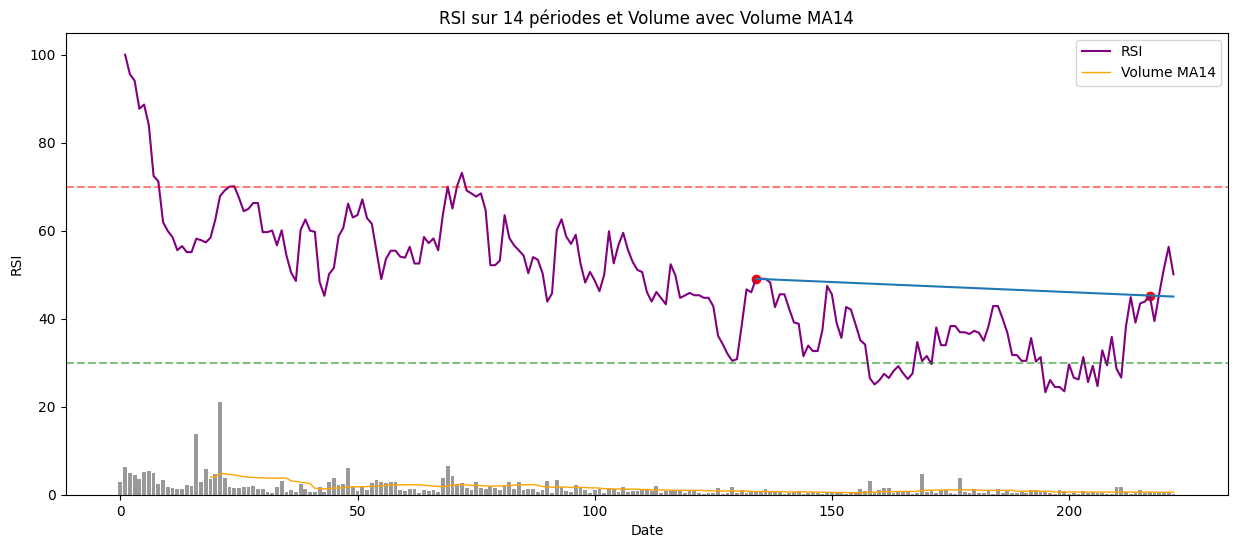

Asset: JBOG.PA, Score: 6, URL: https://www.tradingview.com/chart/?symbol=JBOG&interval=1W


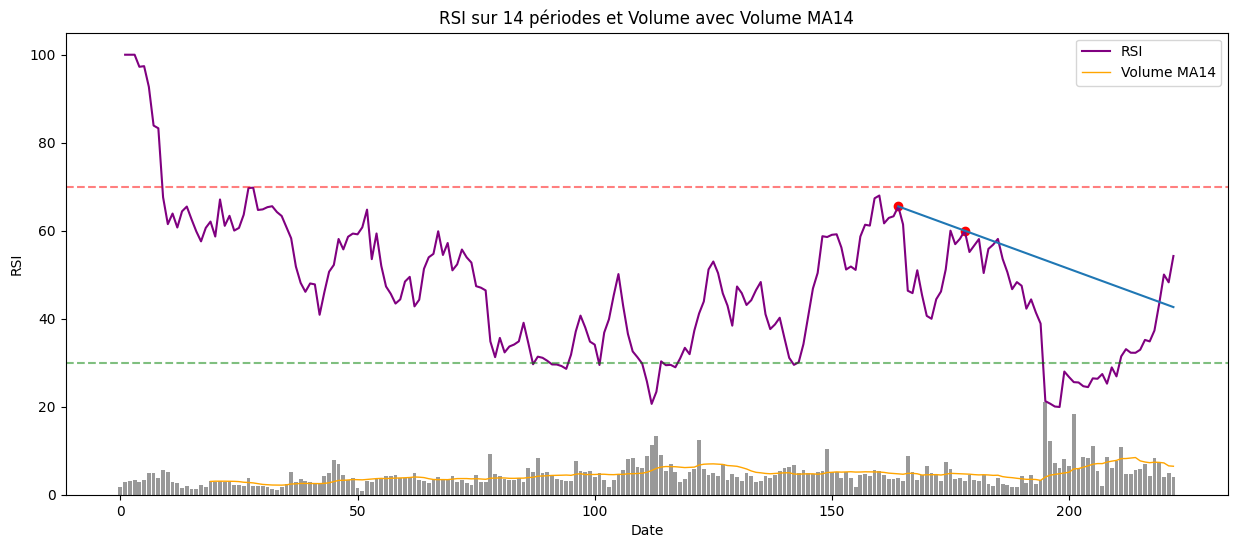

Asset: ALO.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=ALO&interval=1W


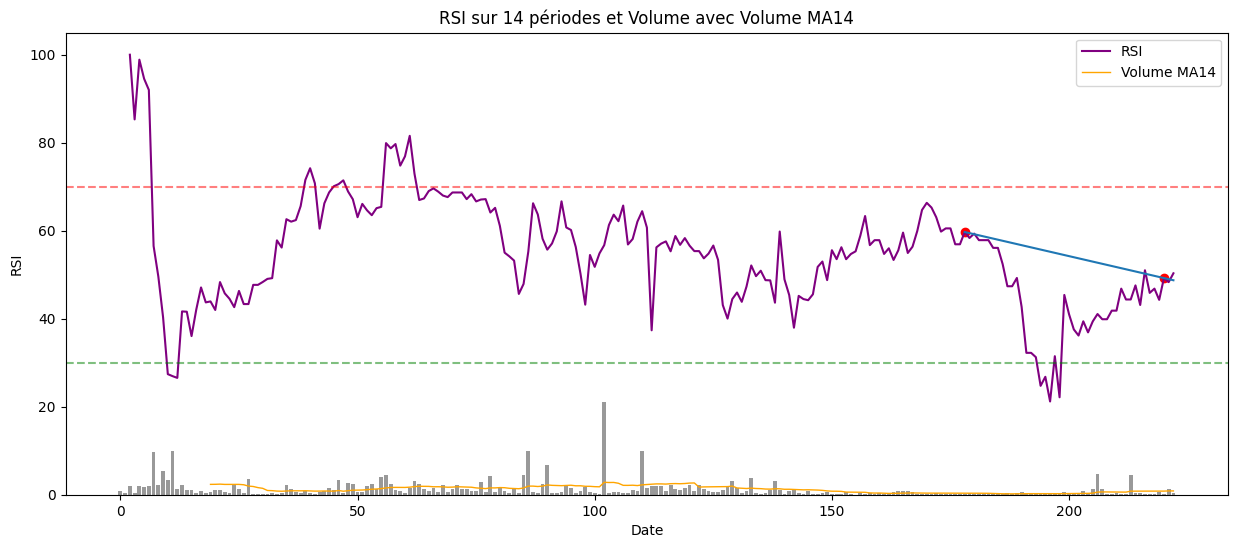

Asset: LTA.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=LTA&interval=1W


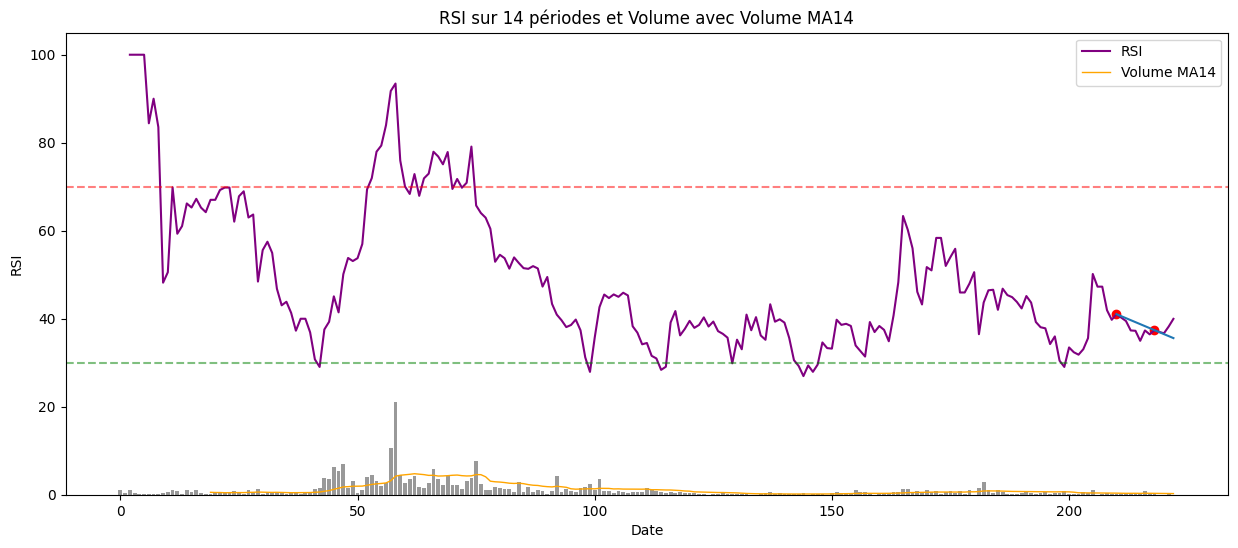

Asset: CNV.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=CNV&interval=1W


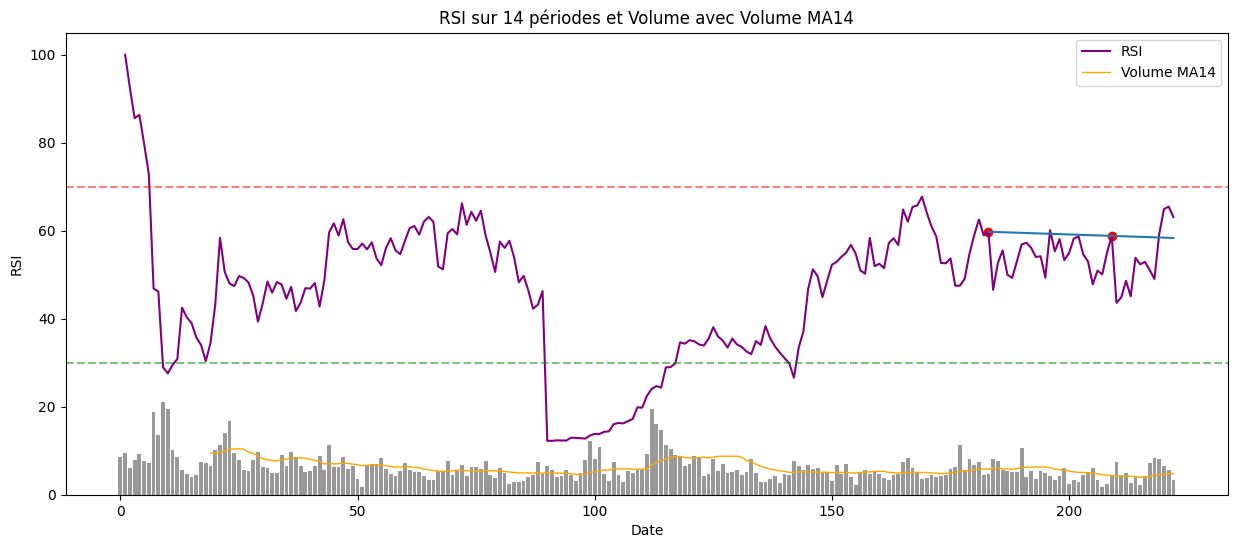

Asset: AM.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=AM&interval=1W


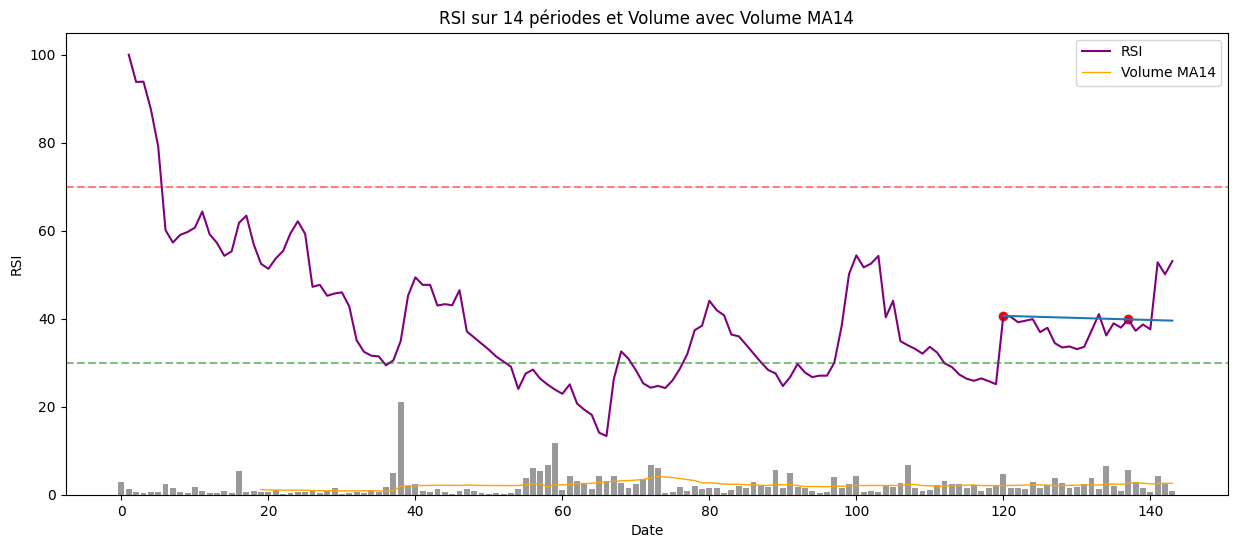

Asset: ALENO.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=ALENO&interval=1W


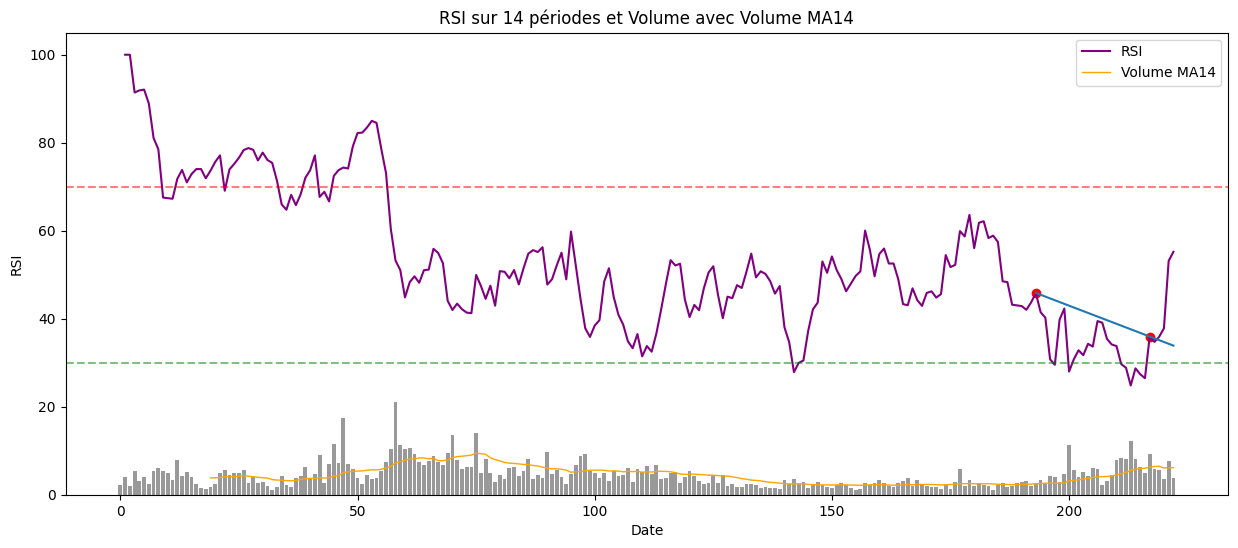

Asset: EQS.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=EQS&interval=1W


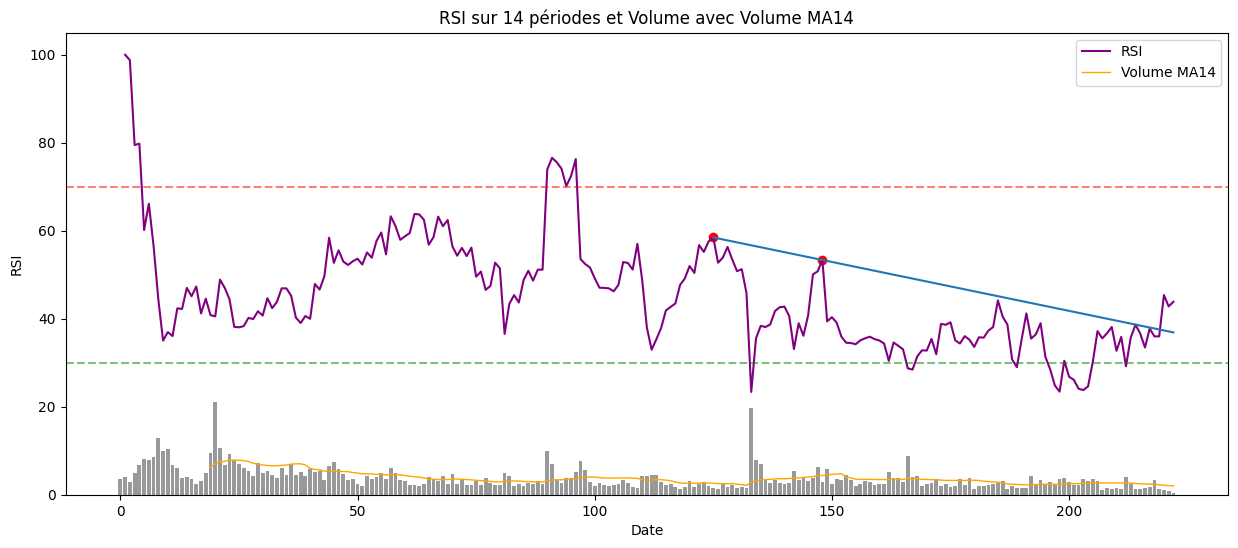

Asset: ETL.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=ETL&interval=1W


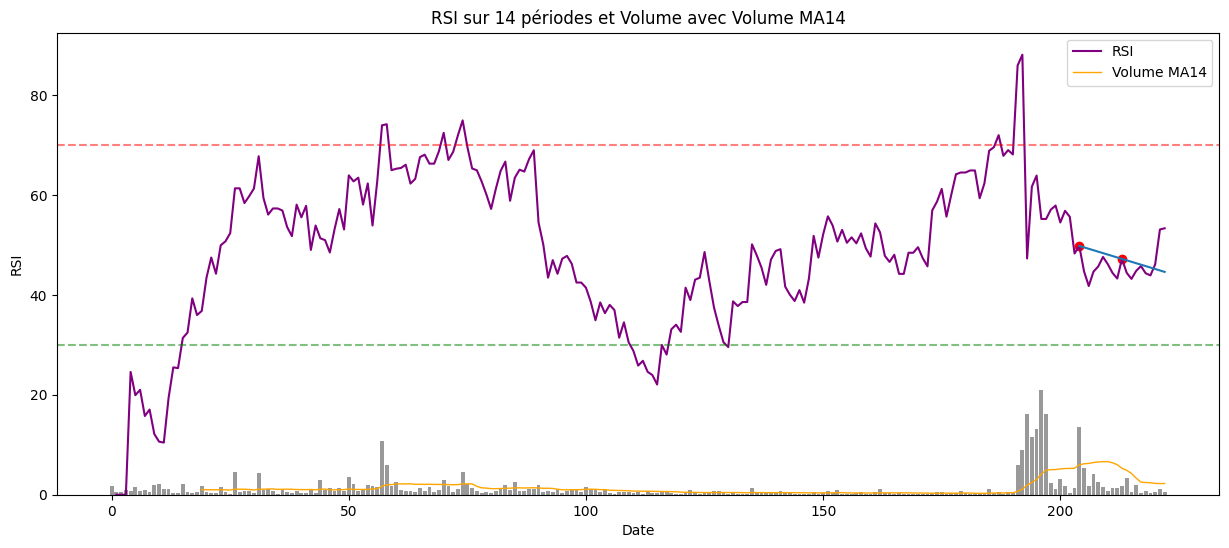

Asset: ALINN.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=ALINN&interval=1W


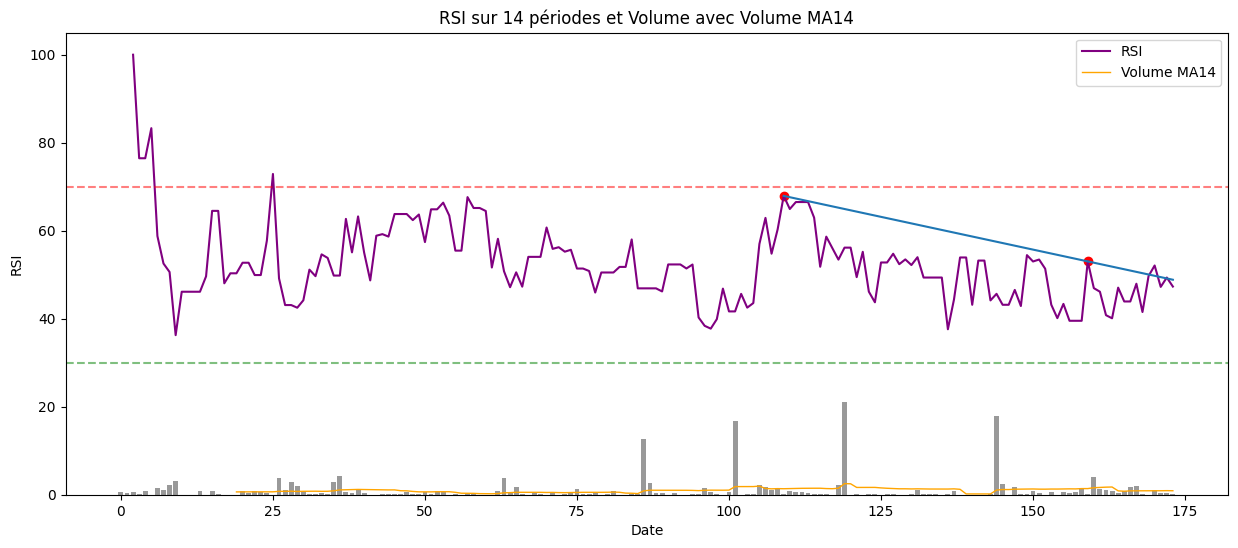

Asset: MLMAD.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=MLMAD&interval=1W


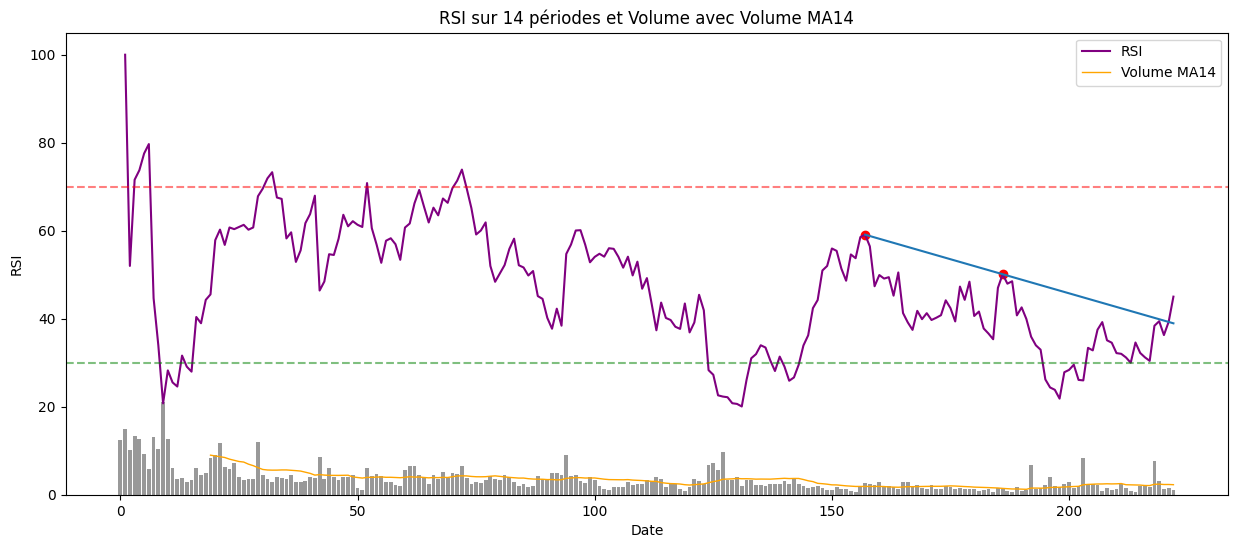

Asset: MDM.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=MDM&interval=1W


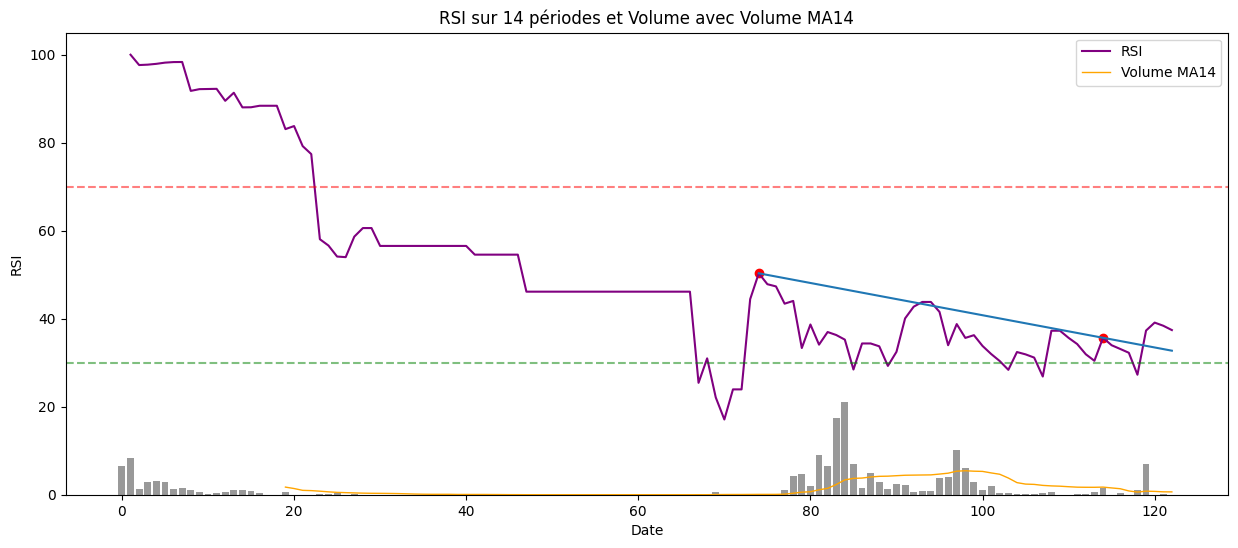

Asset: ALMEX.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=ALMEX&interval=1W


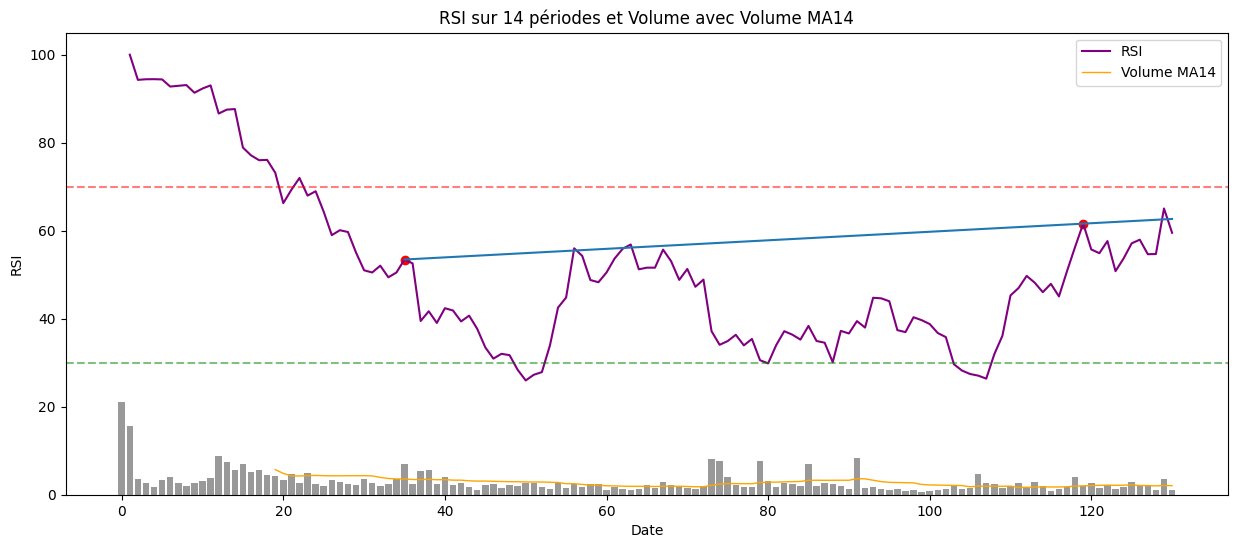

Asset: OVH.PA, Score: 5, URL: https://www.tradingview.com/chart/?symbol=OVH&interval=1W


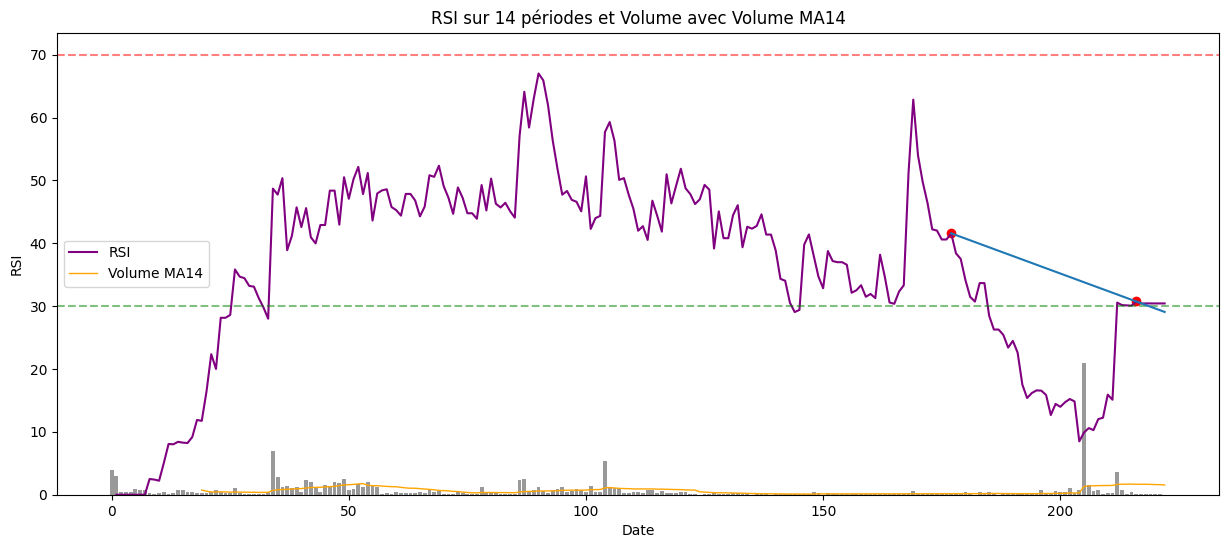

Asset: ALARF.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=ALARF&interval=1W


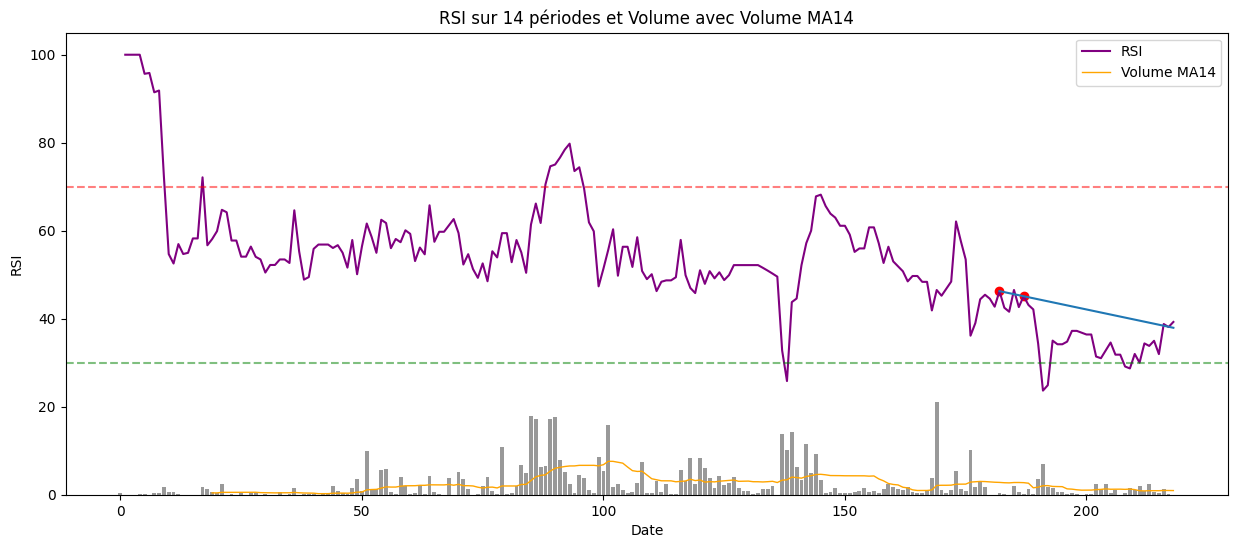

Asset: ARTE.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=ARTE&interval=1W


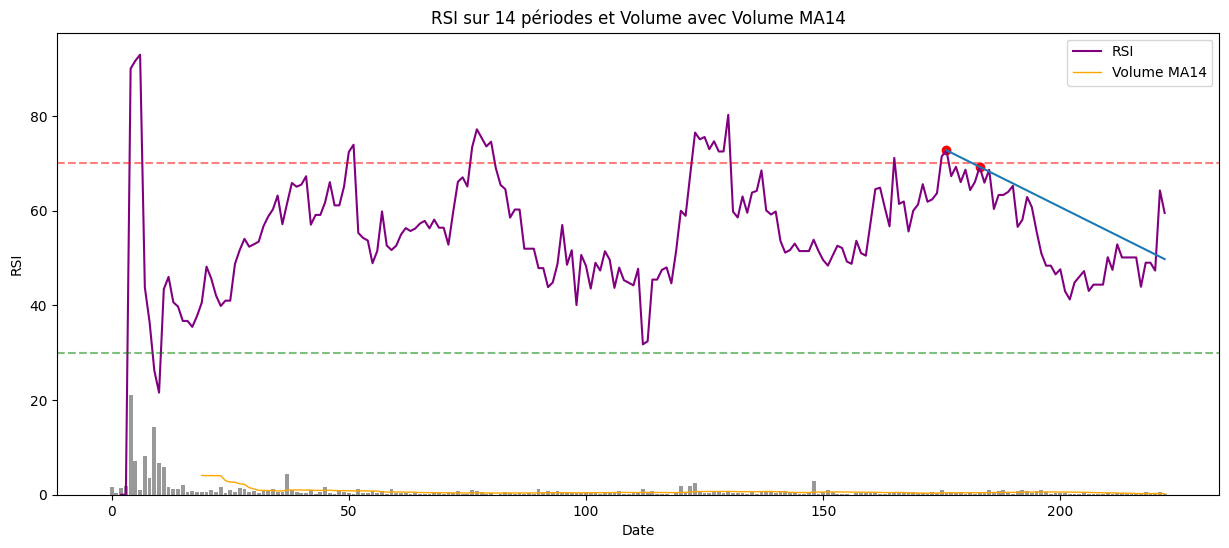

Asset: BAIN.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=BAIN&interval=1W


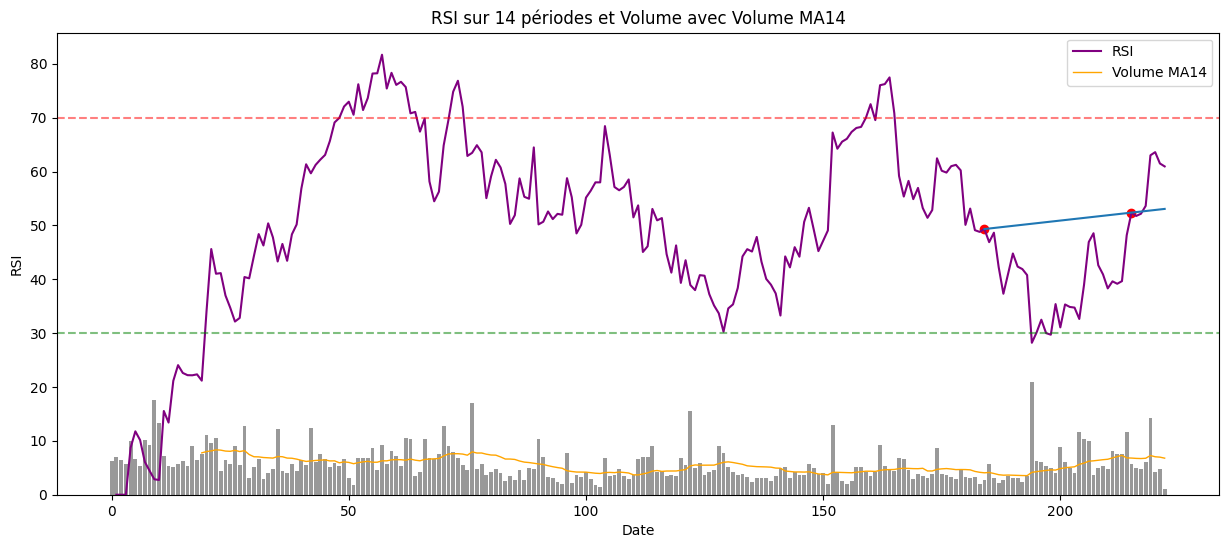

Asset: BEN.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=BEN&interval=1W


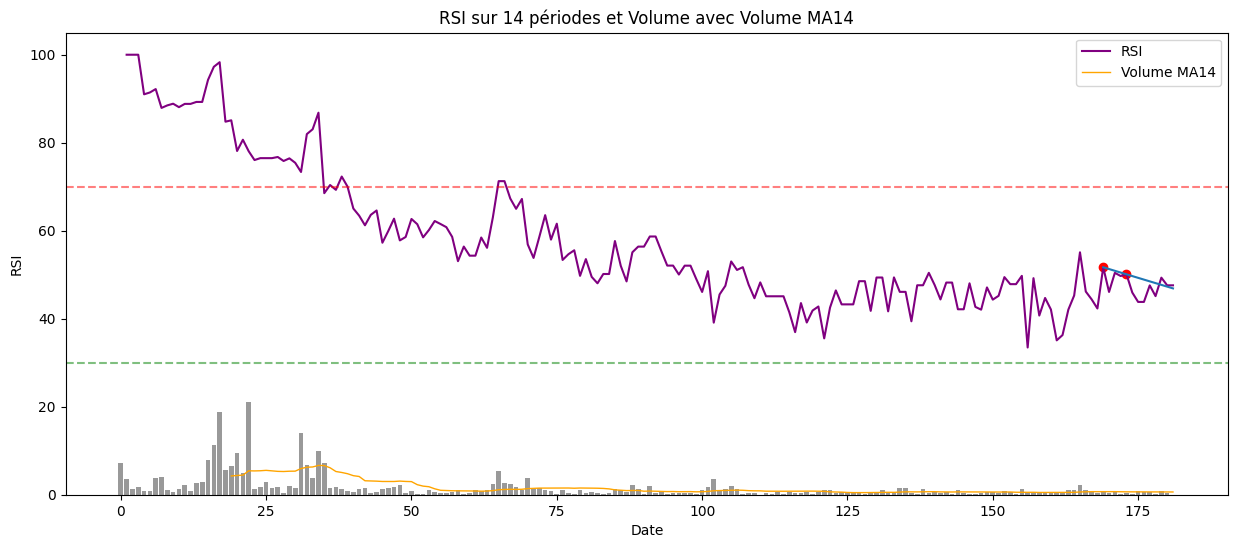

Asset: MLLCB.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=MLLCB&interval=1W


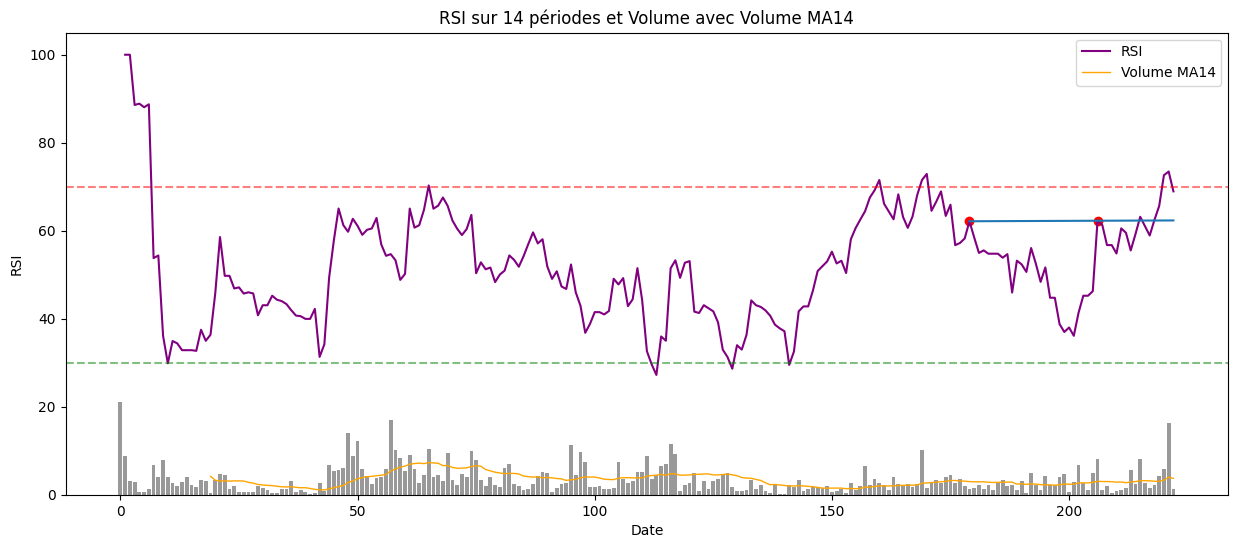

Asset: ALDLS.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=ALDLS&interval=1W


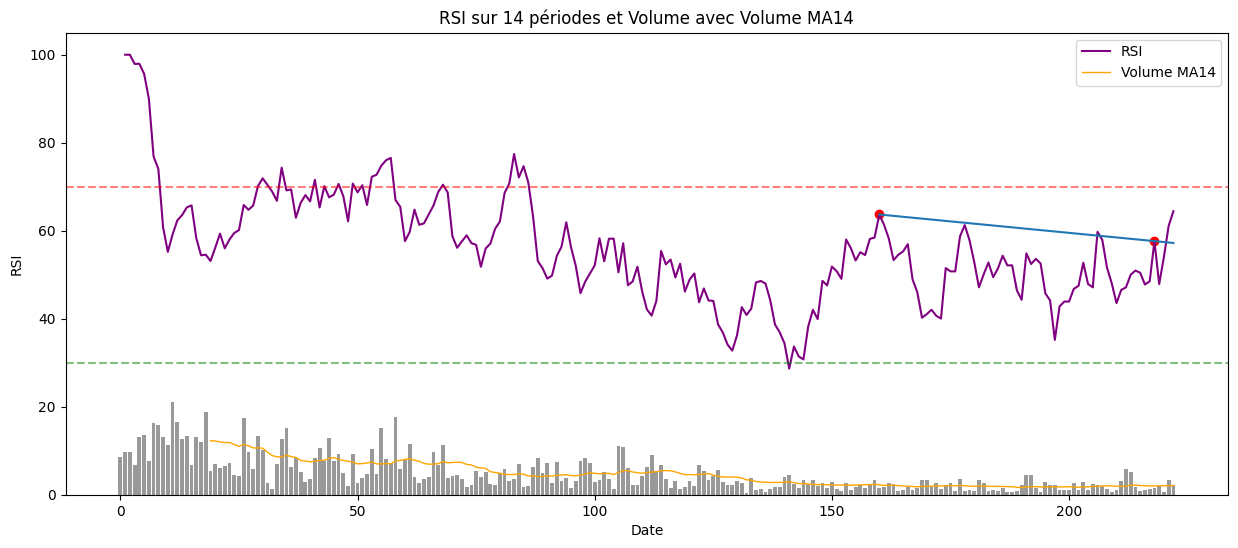

Asset: ALDLT.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=ALDLT&interval=1W


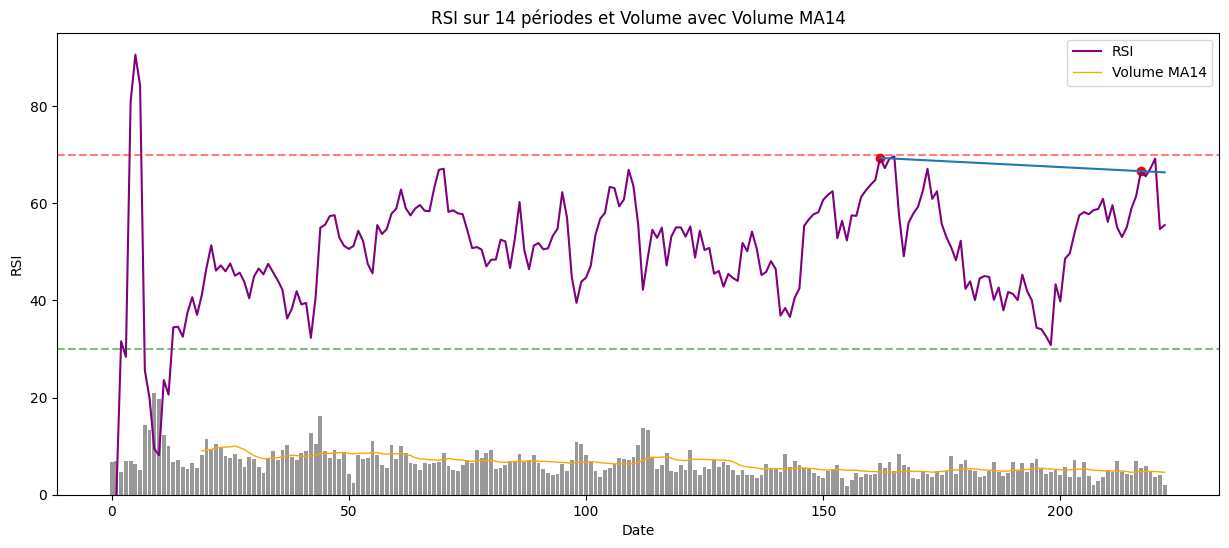

Asset: FGR.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=FGR&interval=1W


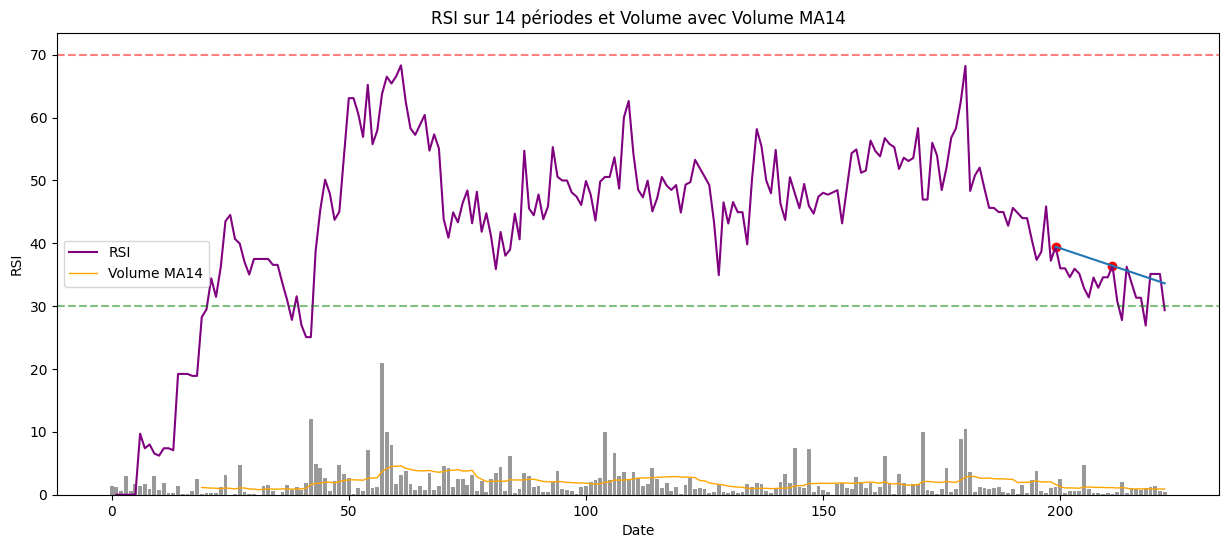

Asset: ALDUB.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=ALDUB&interval=1W


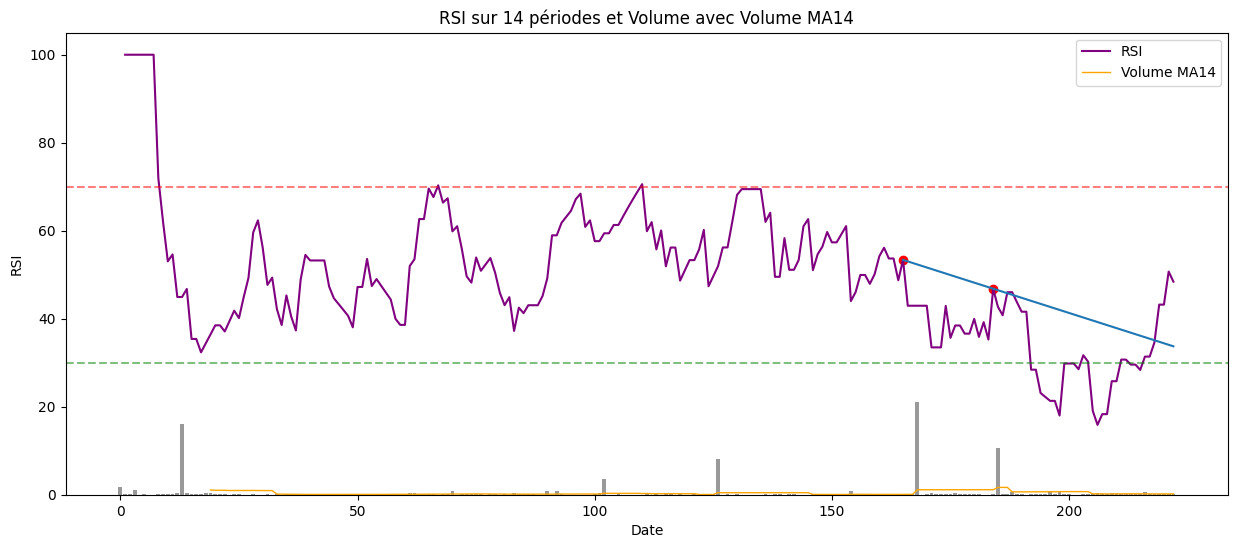

Asset: FREY.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=FREY&interval=1W


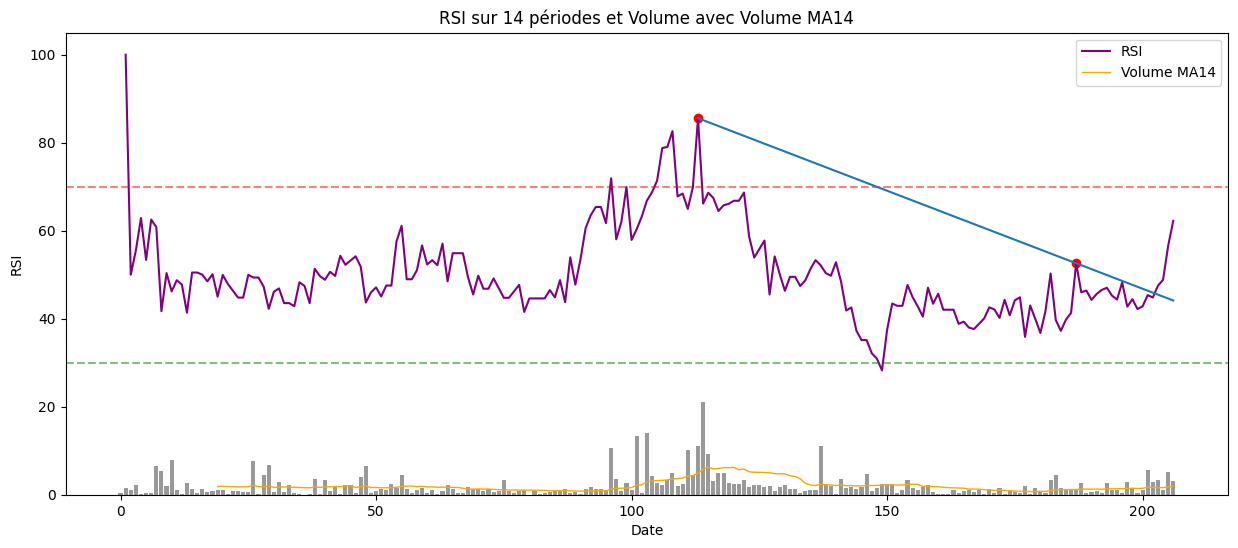

Asset: ALGLD.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=ALGLD&interval=1W


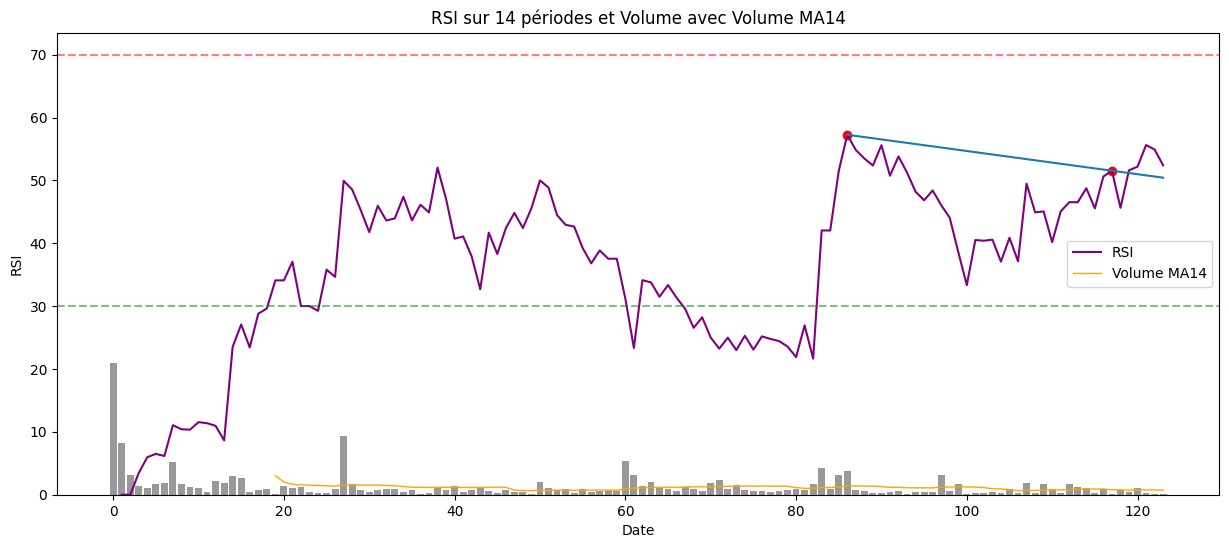

Asset: ALGRO.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=ALGRO&interval=1W


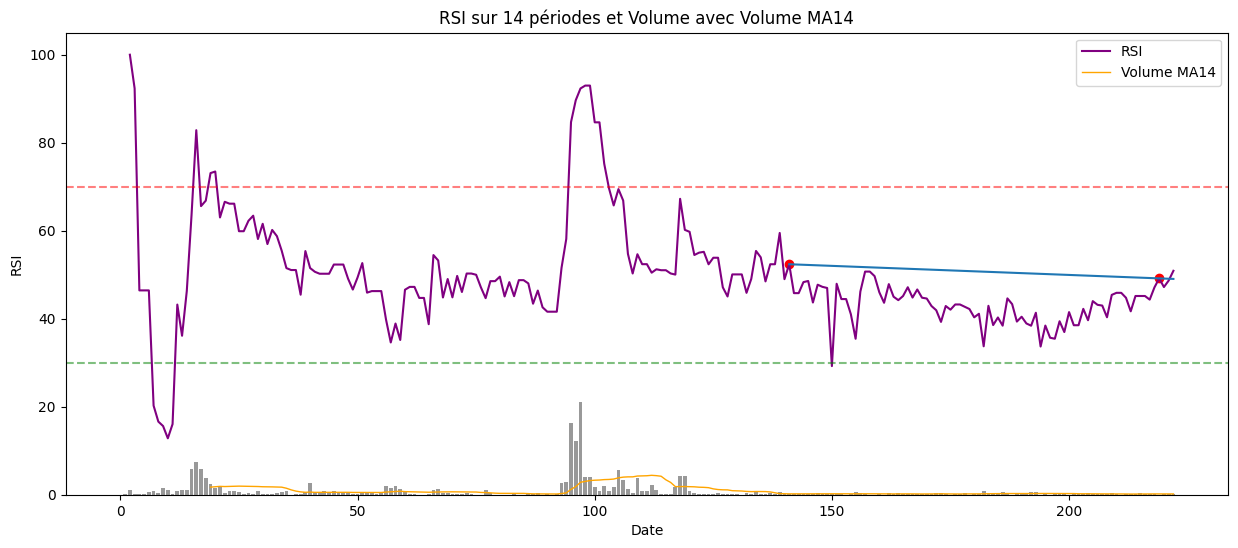

Asset: ALIMR.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=ALIMR&interval=1W


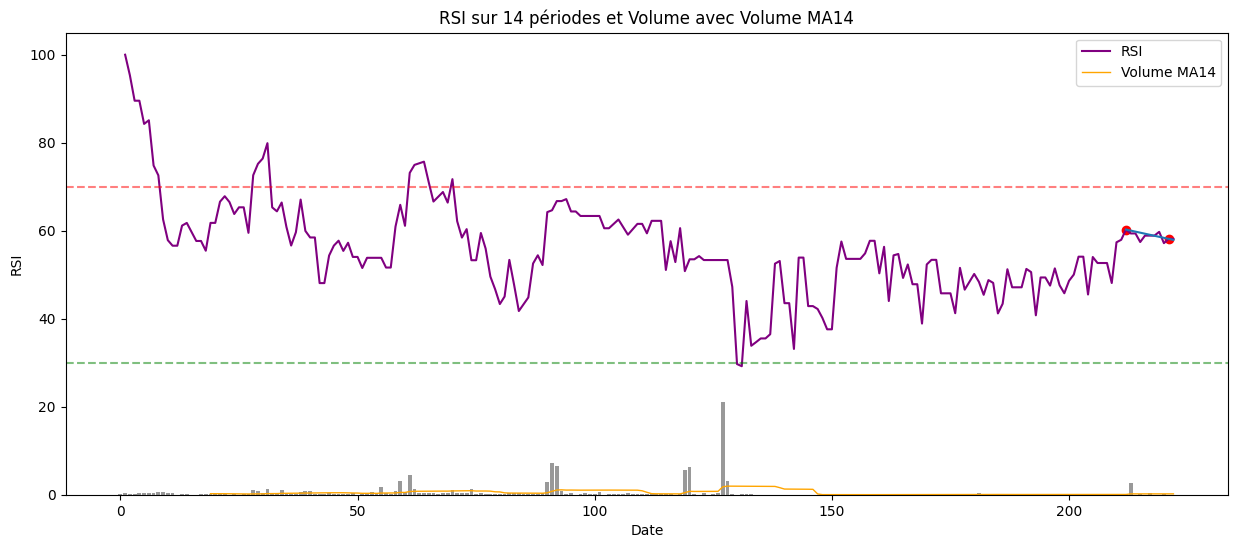

Asset: ITE.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=ITE&interval=1W


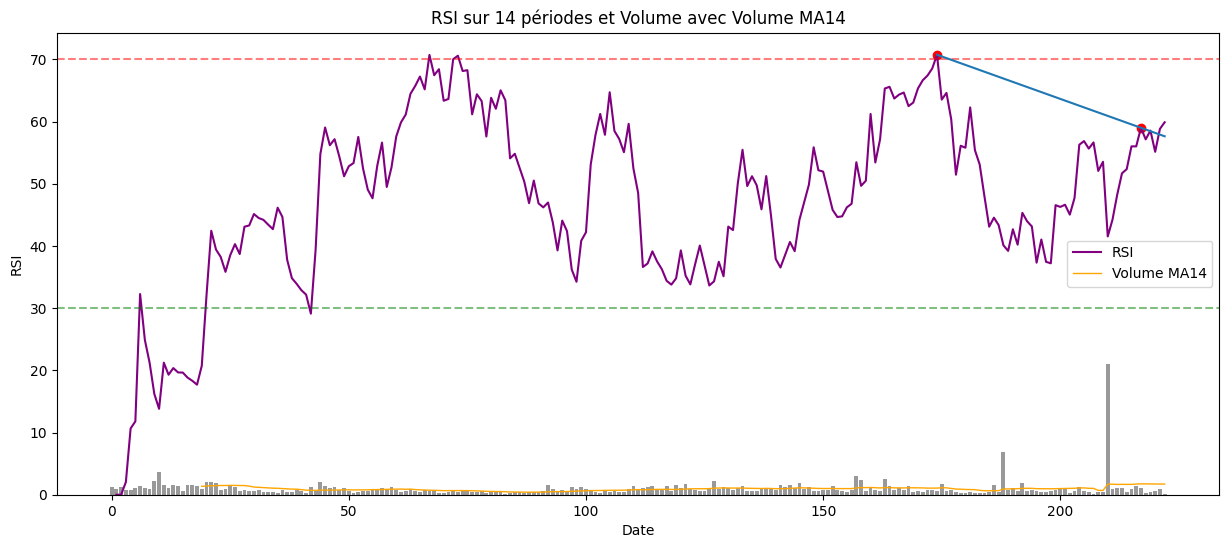

Asset: FII.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=FII&interval=1W


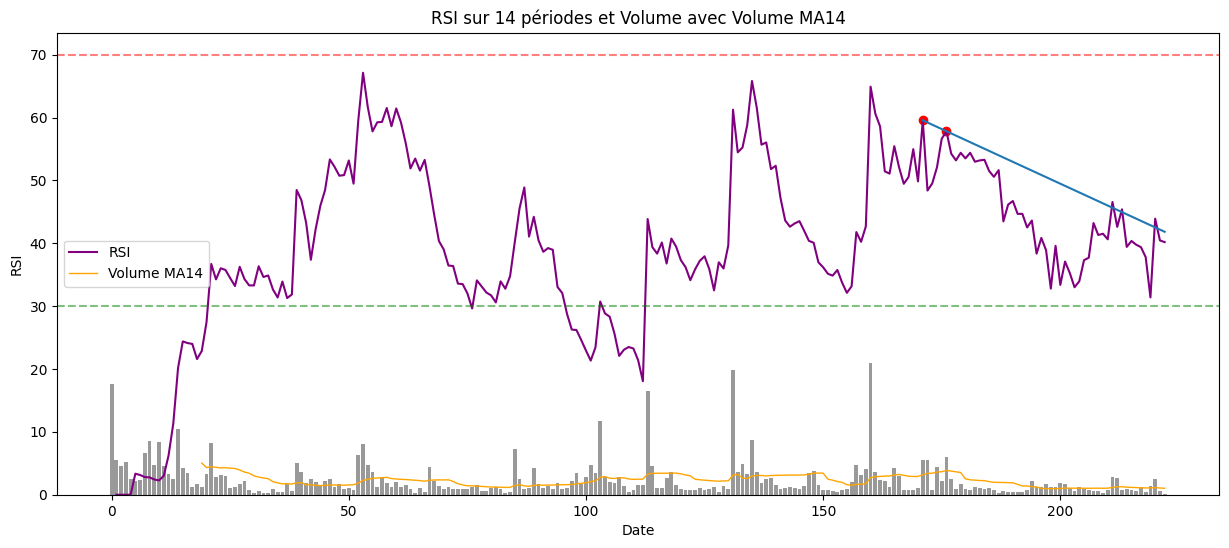

Asset: ALMKT.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=ALMKT&interval=1W


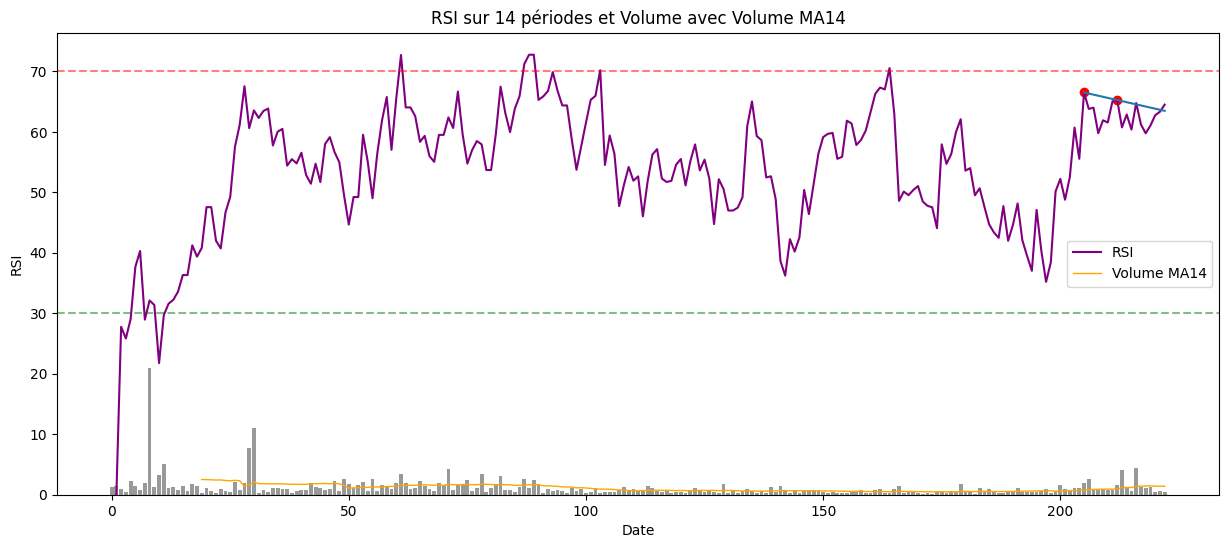

Asset: NRO.PA, Score: 4, URL: https://www.tradingview.com/chart/?symbol=NRO&interval=1W


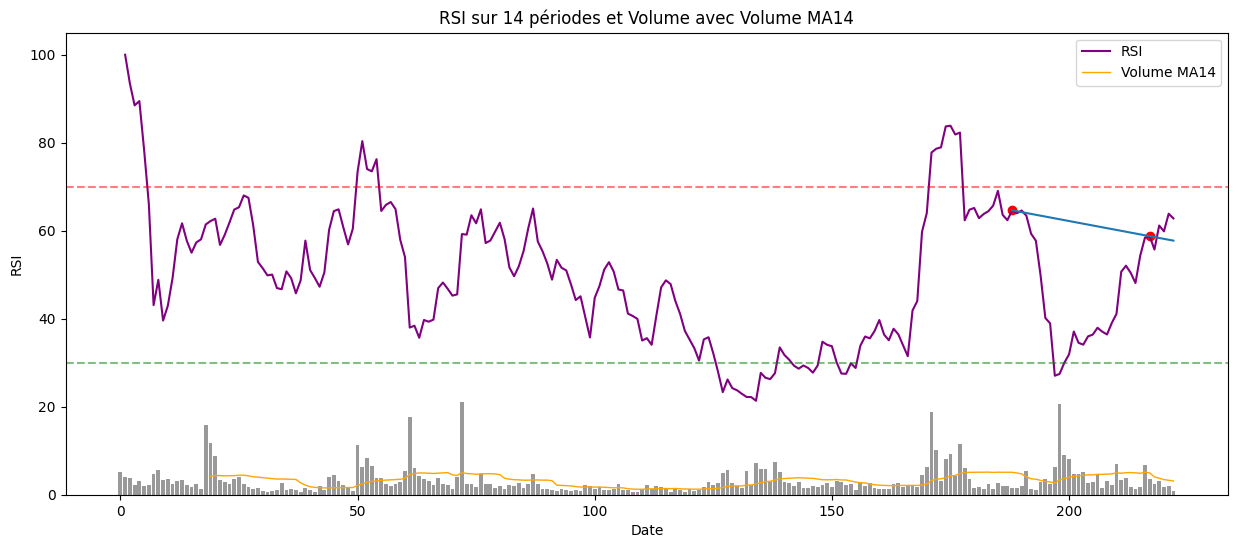

Asset: ABVX.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ABVX&interval=1W


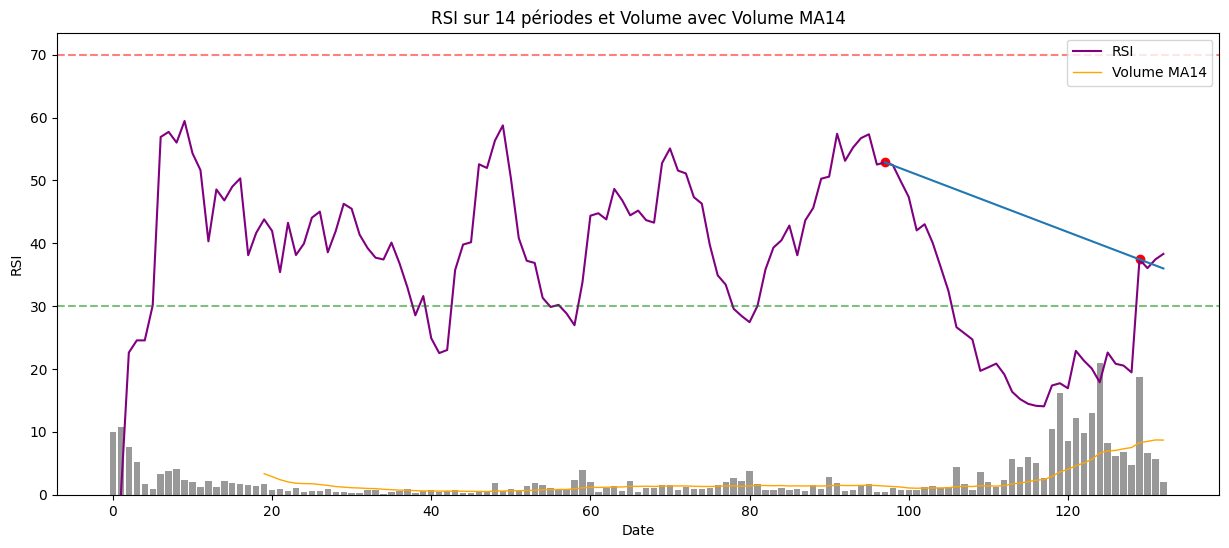

Asset: ALAFY.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ALAFY&interval=1W


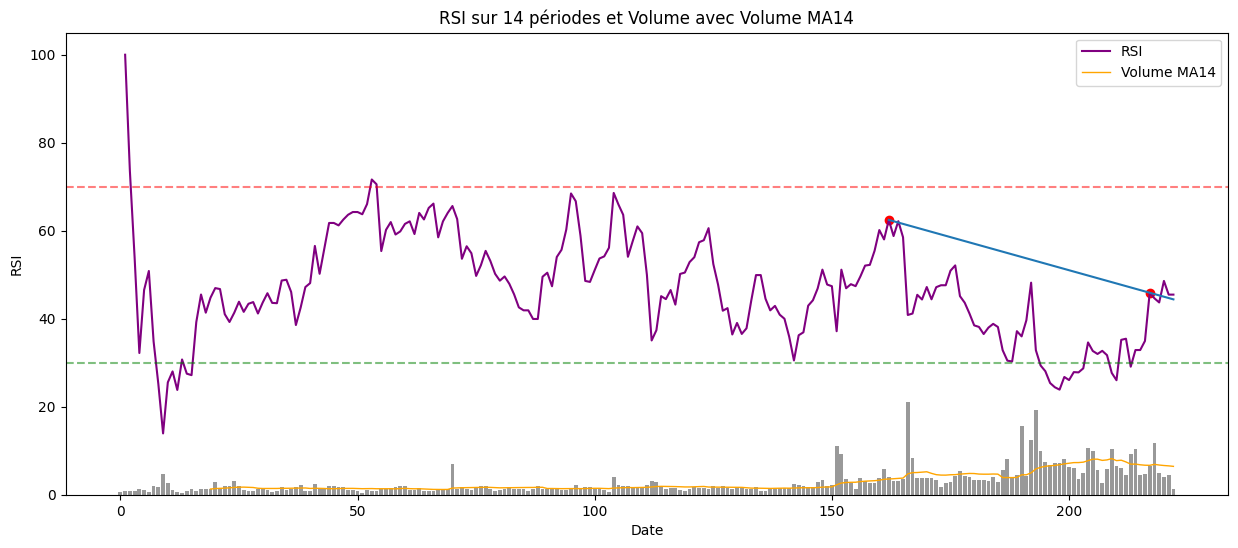

Asset: ALD.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ALD&interval=1W


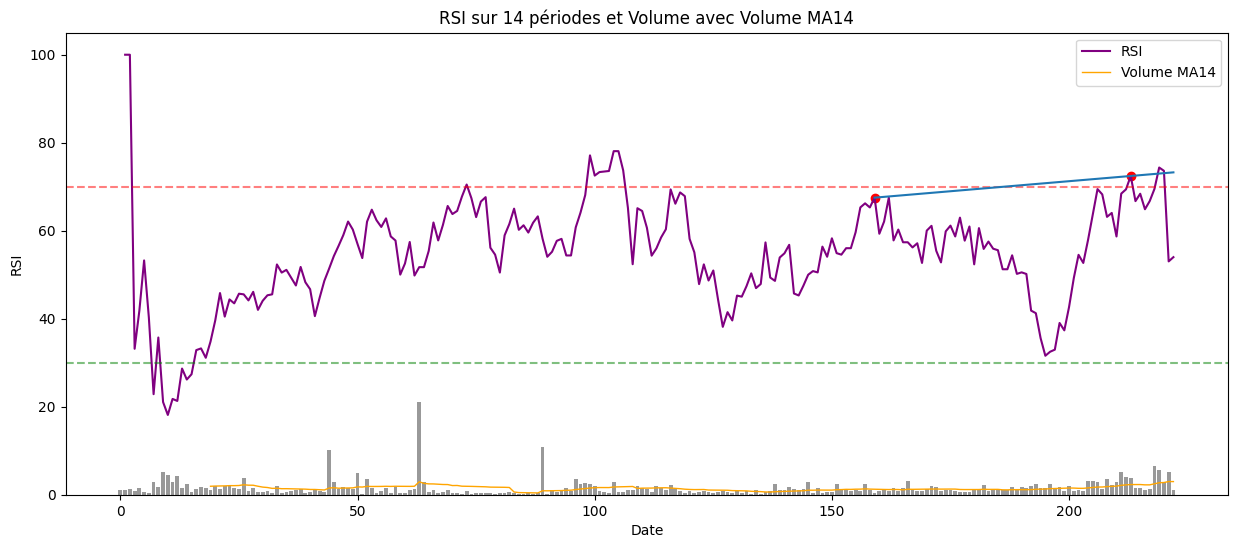

Asset: ASY.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ASY&interval=1W


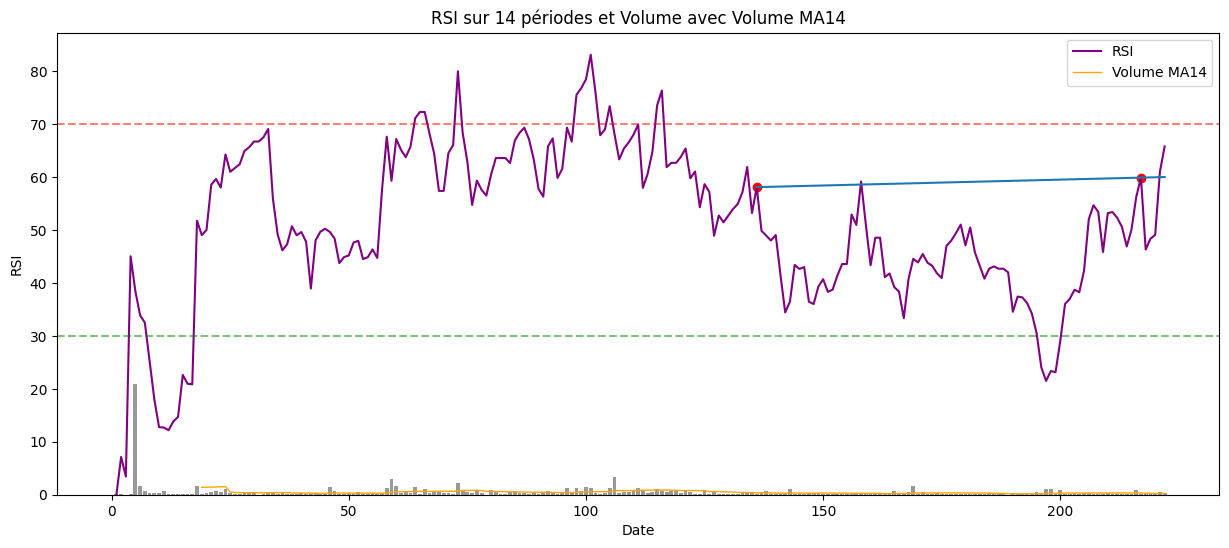

Asset: ALBLD.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ALBLD&interval=1W


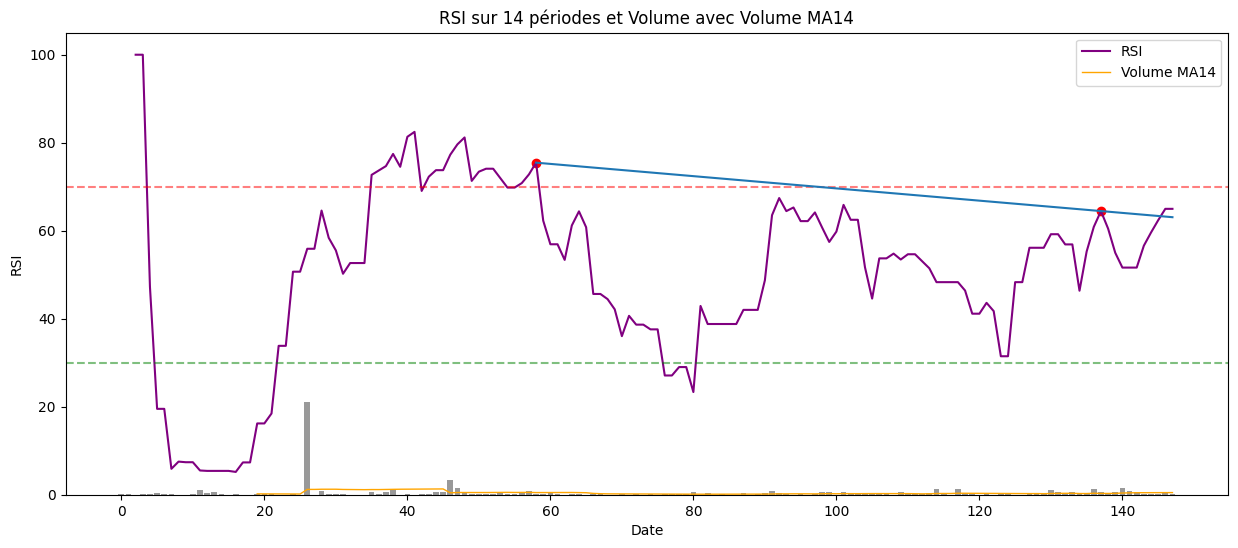

Asset: CBDG.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=CBDG&interval=1W


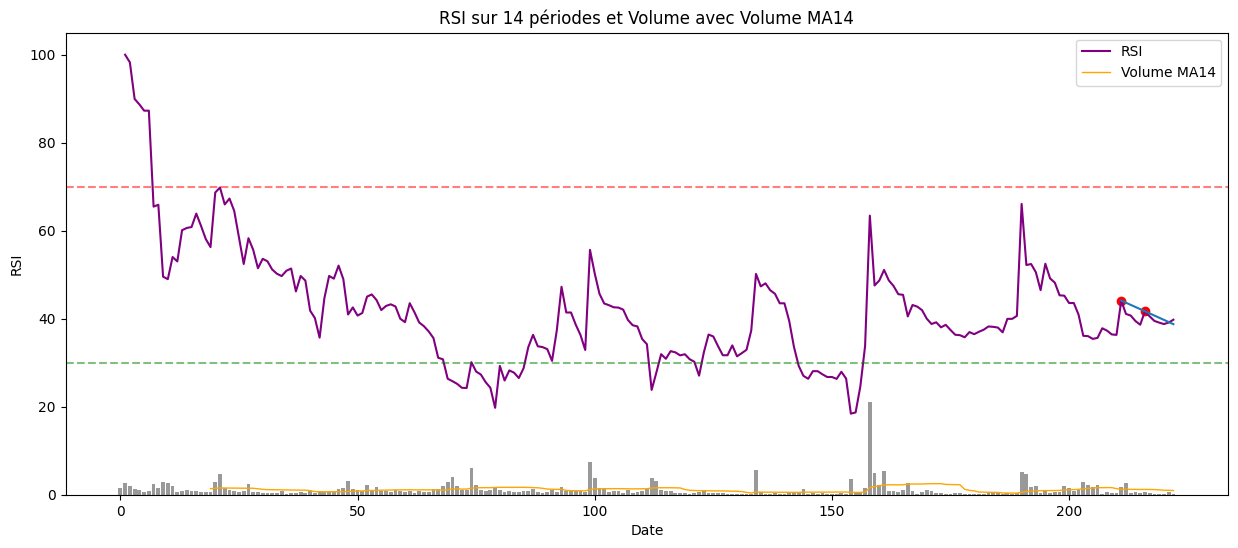

Asset: CYAD.BR, Score: 3, URL: https://www.tradingview.com/chart/?symbol=CYAD&interval=1W


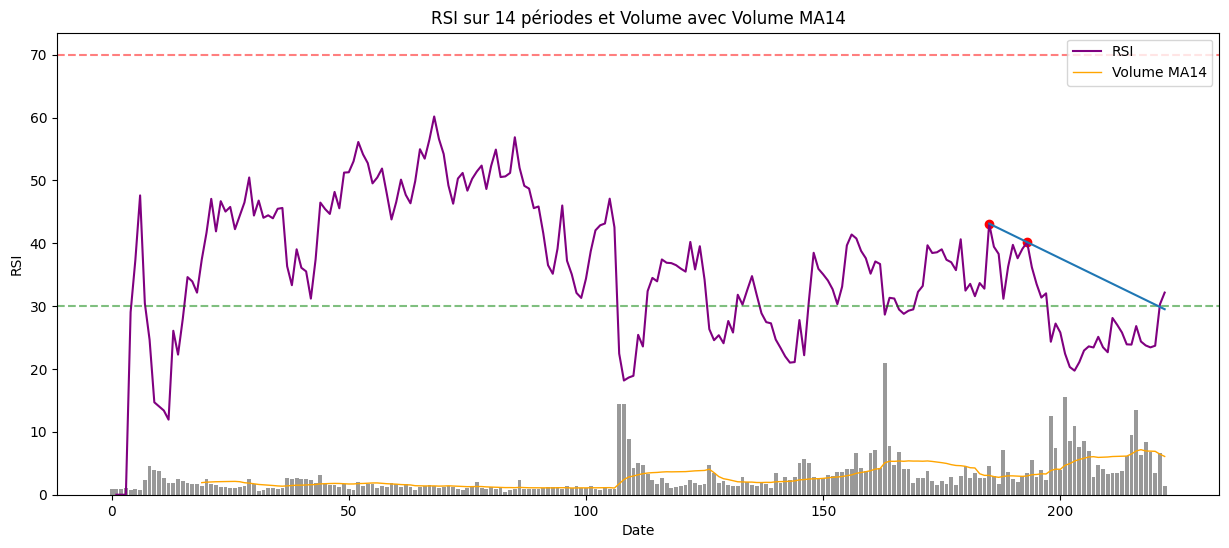

Asset: CLARI.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=CLARI&interval=1W


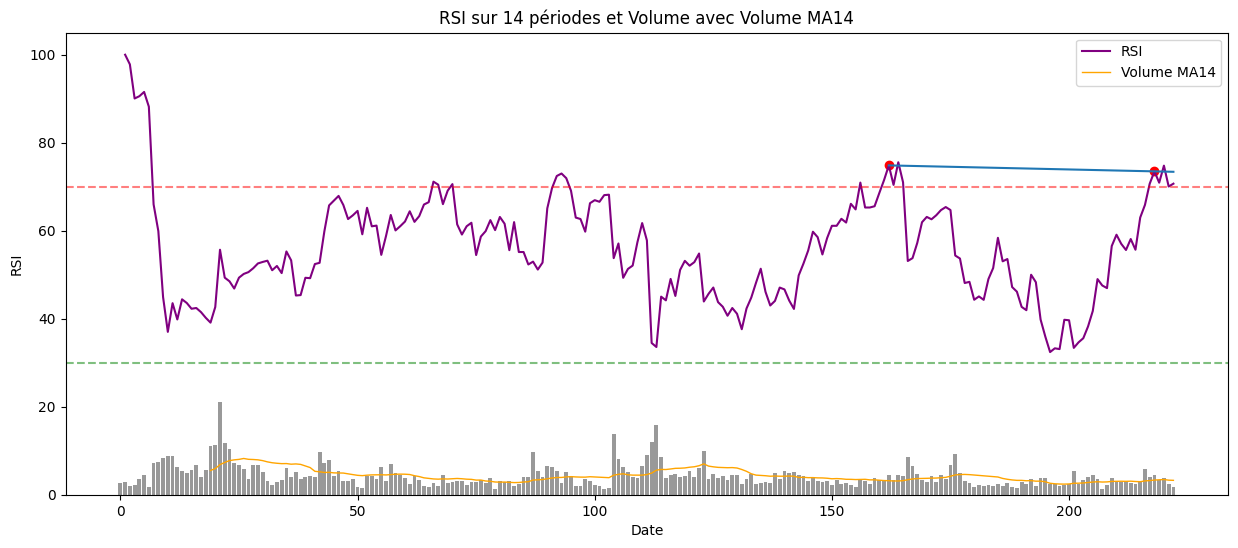

Asset: COFA.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=COFA&interval=1W


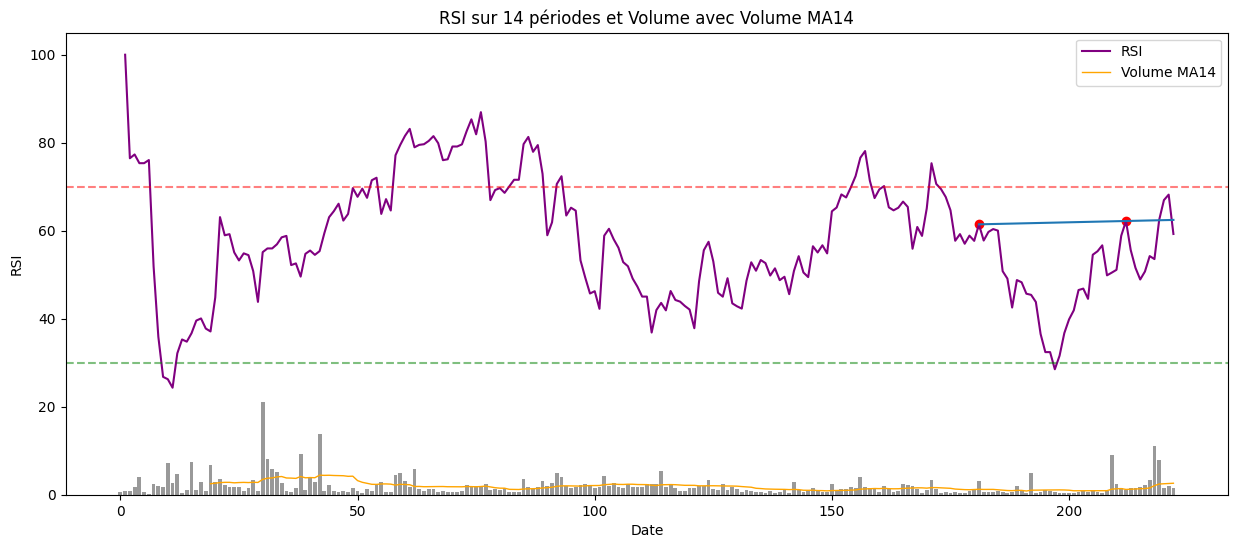

Asset: ODET.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ODET&interval=1W


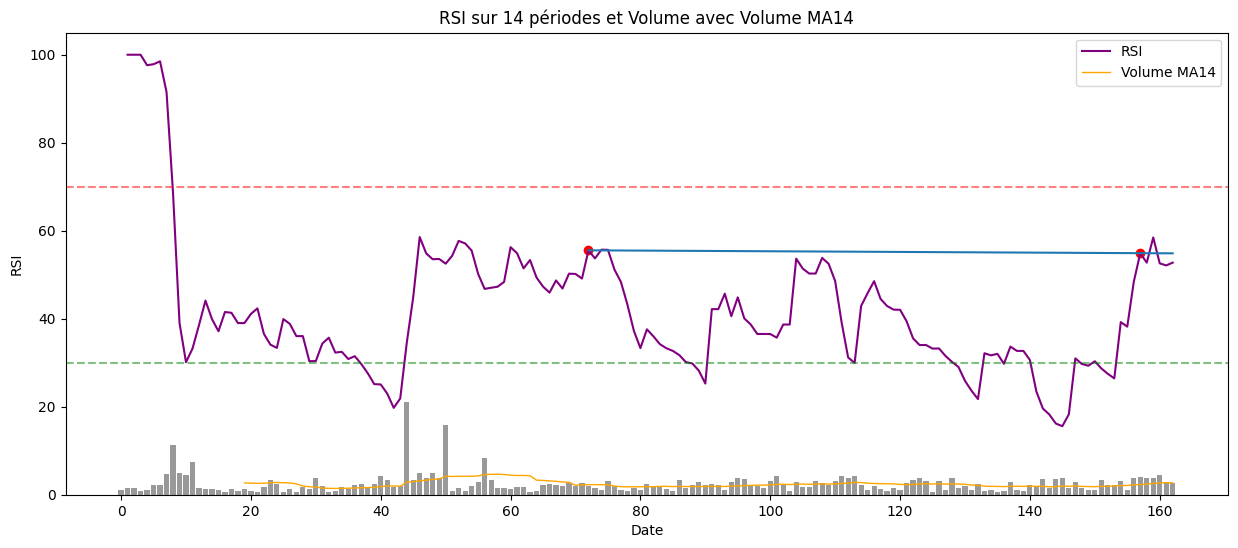

Asset: CCN.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=CCN&interval=1W


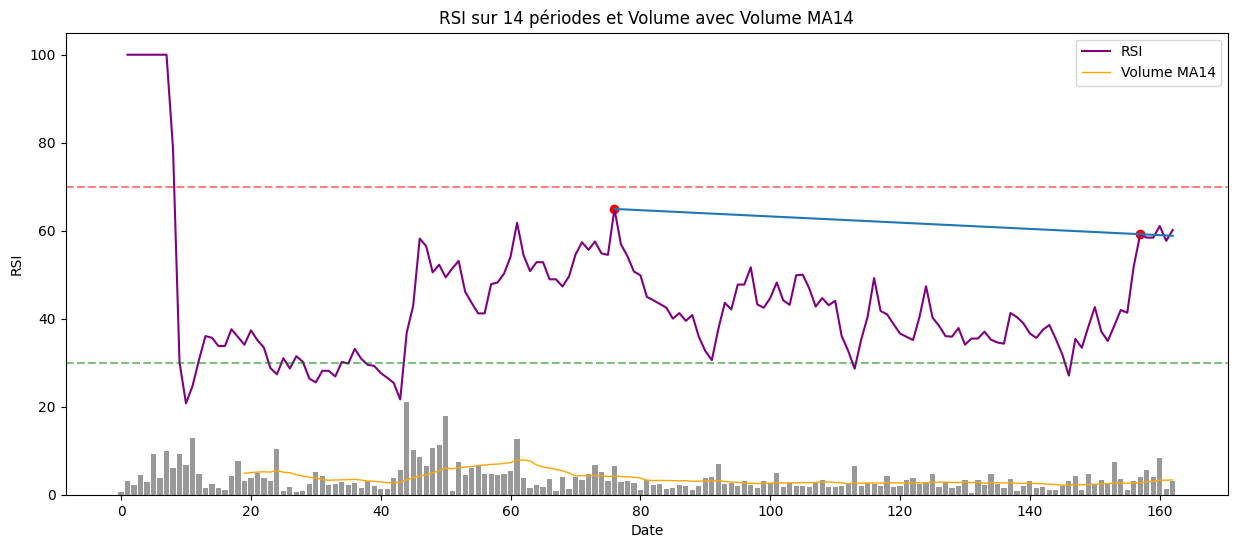

Asset: CRSU.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=CRSU&interval=1W


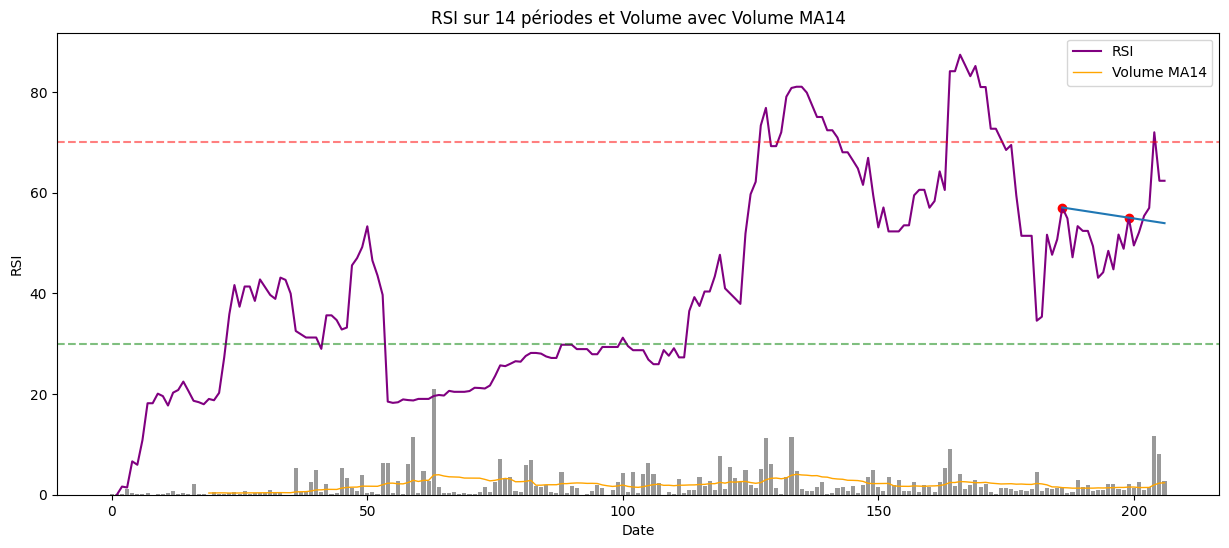

Asset: EXPL.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=EXPL&interval=1W


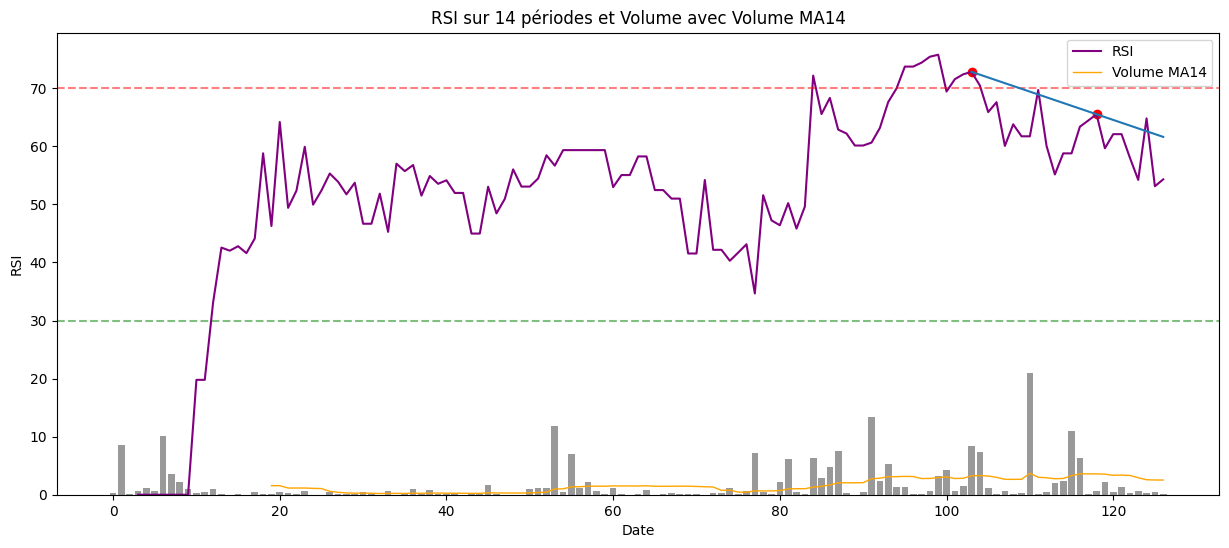

Asset: BERR.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=BERR&interval=1W


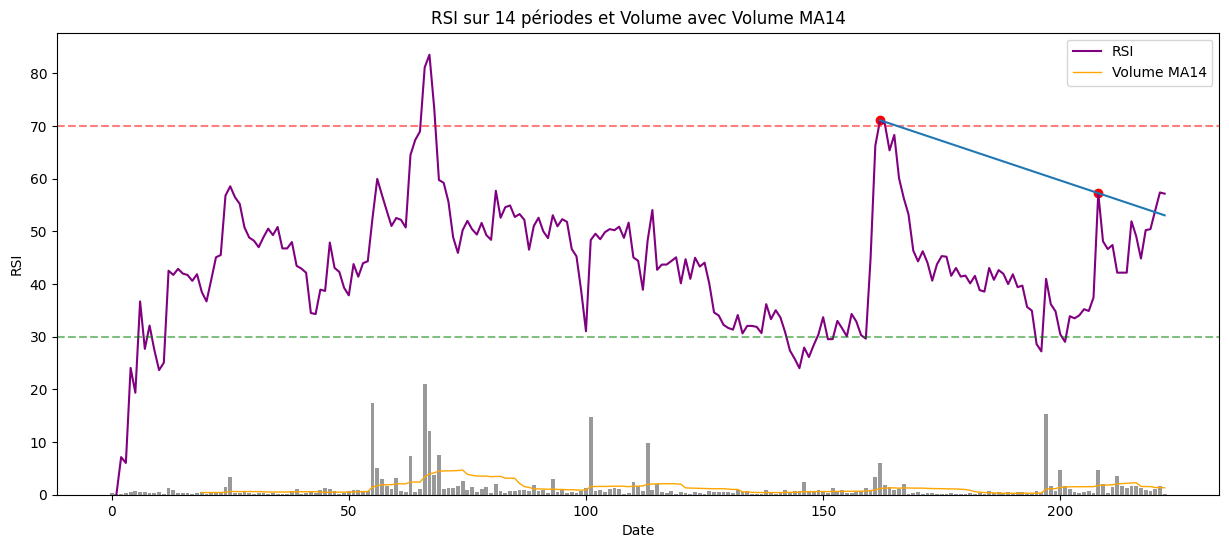

Asset: GNRO.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=GNRO&interval=1W


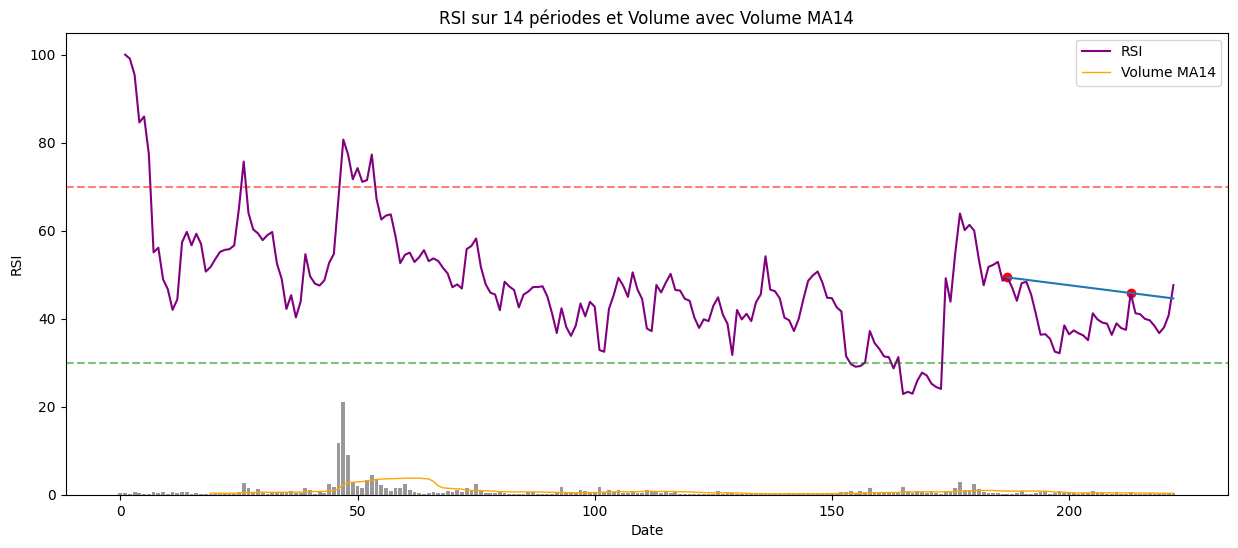

Asset: ALGBE.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ALGBE&interval=1W


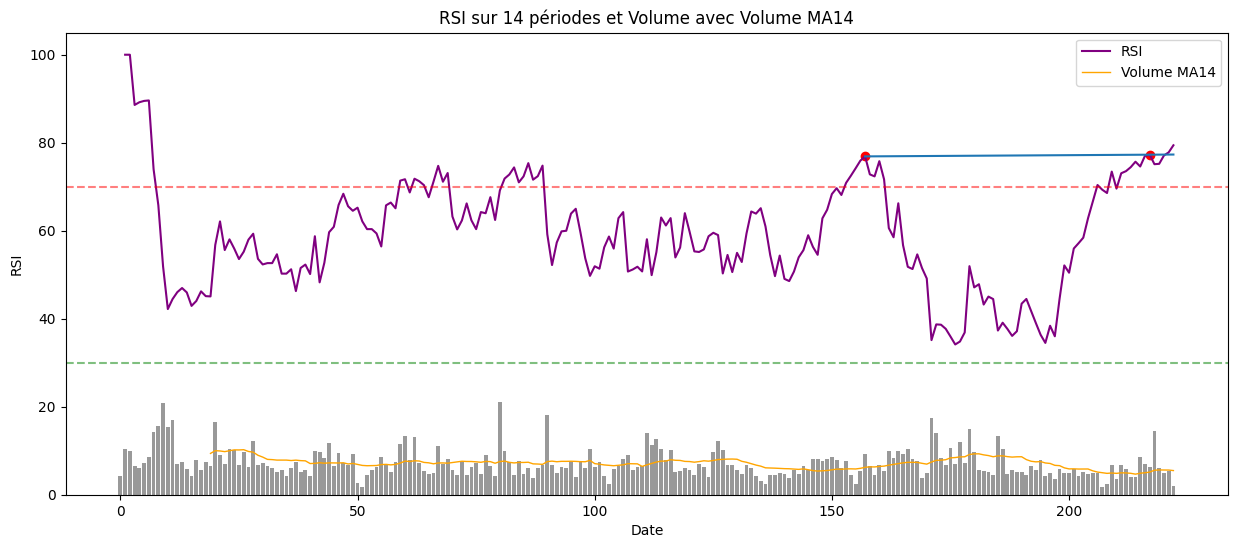

Asset: IPS.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=IPS&interval=1W


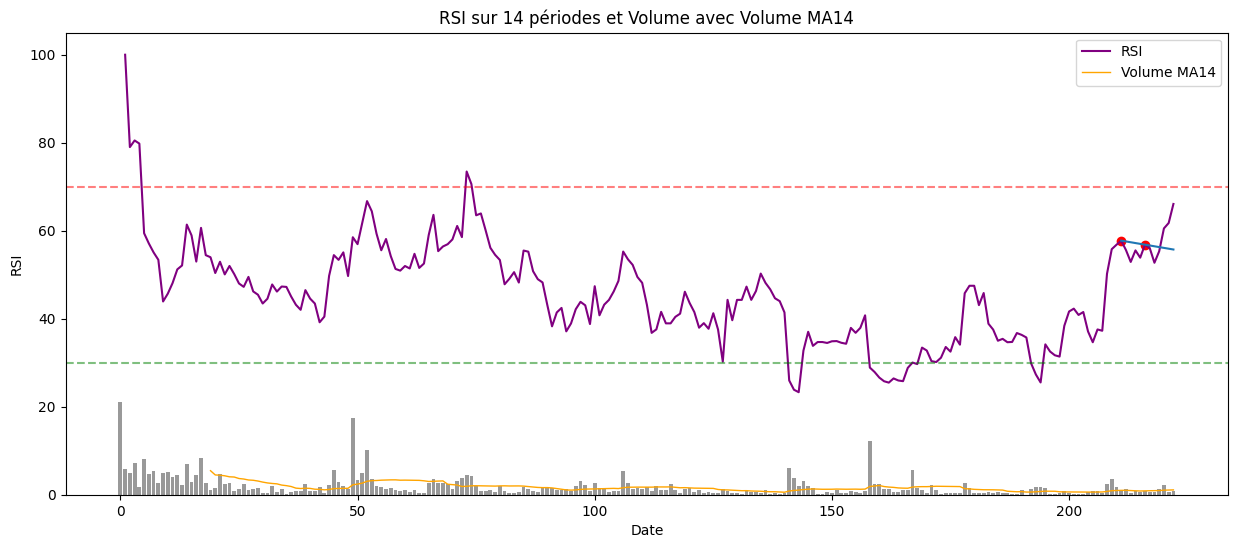

Asset: ALKLK.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ALKLK&interval=1W


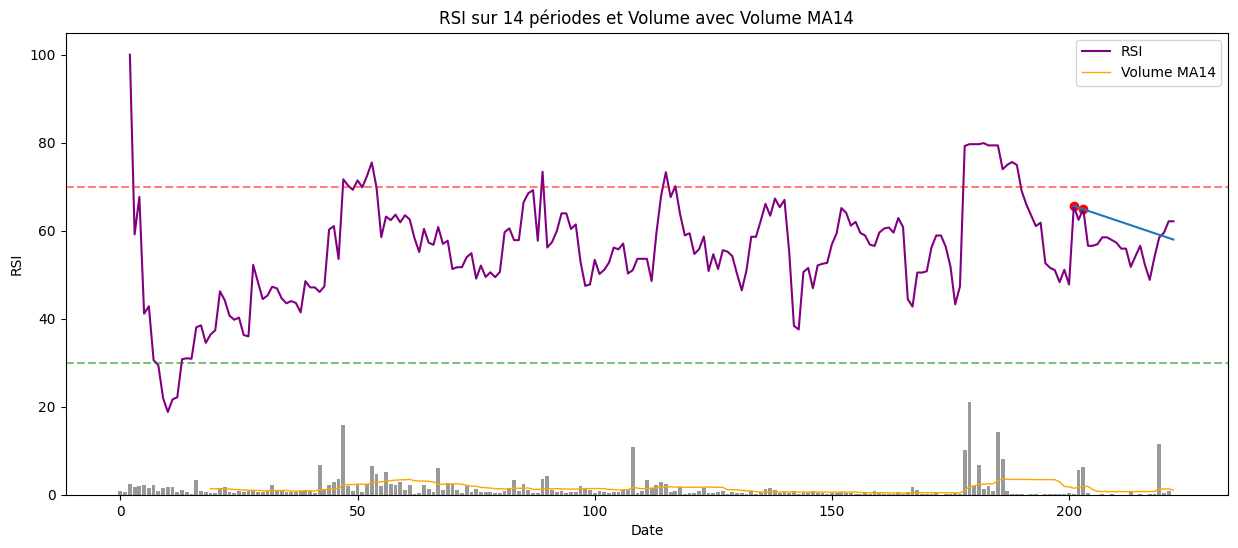

Asset: ALKEY.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ALKEY&interval=1W


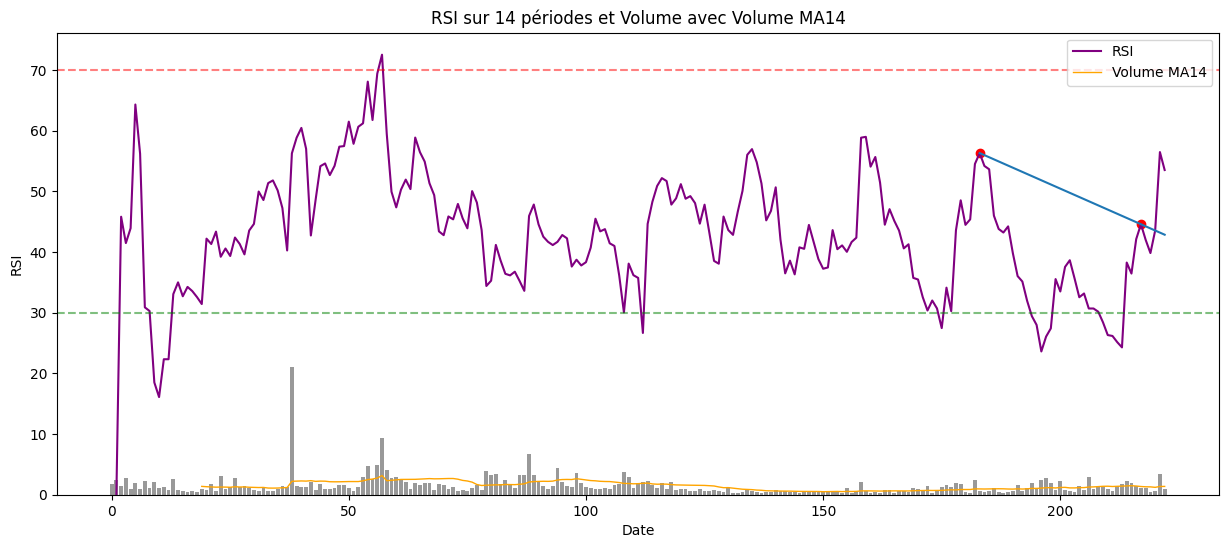

Asset: ALMDG.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ALMDG&interval=1W


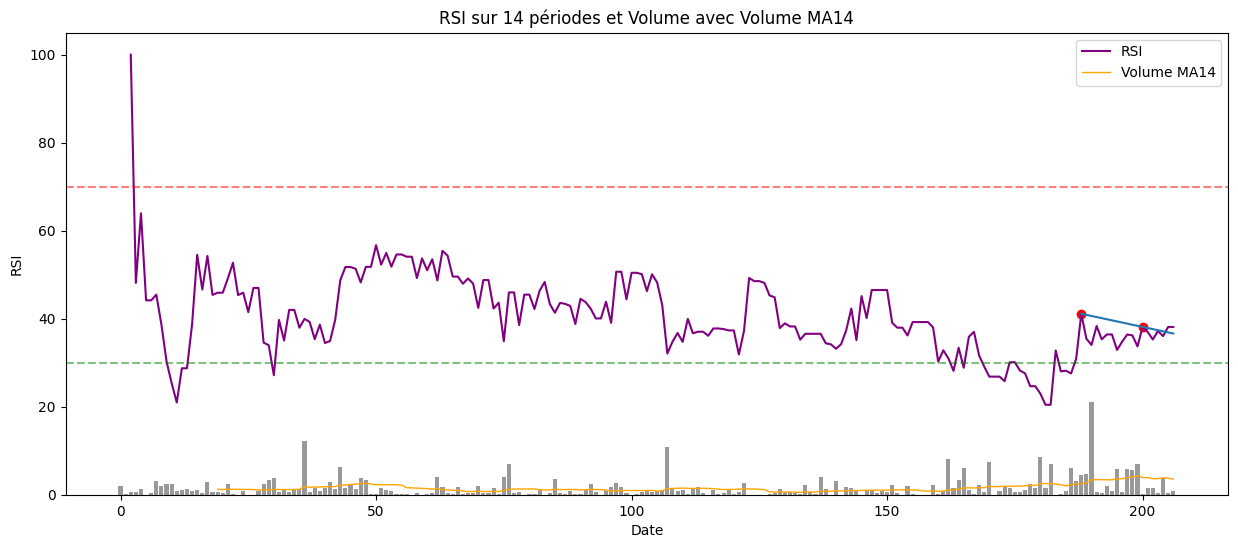

Asset: MLNMA.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=MLNMA&interval=1W


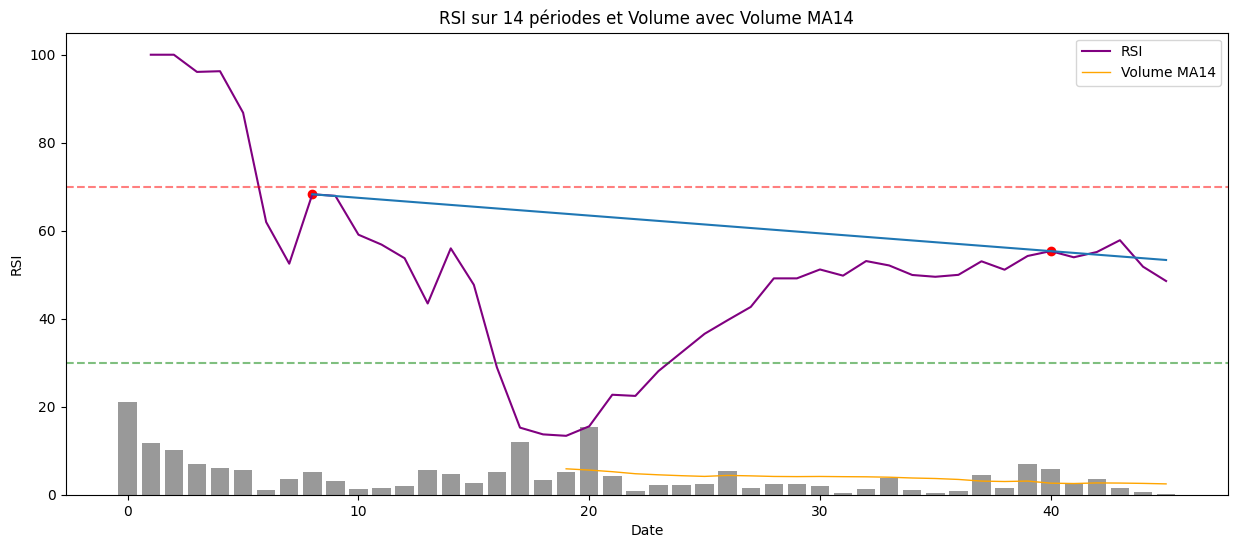

Asset: ALMCE.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ALMCE&interval=1W


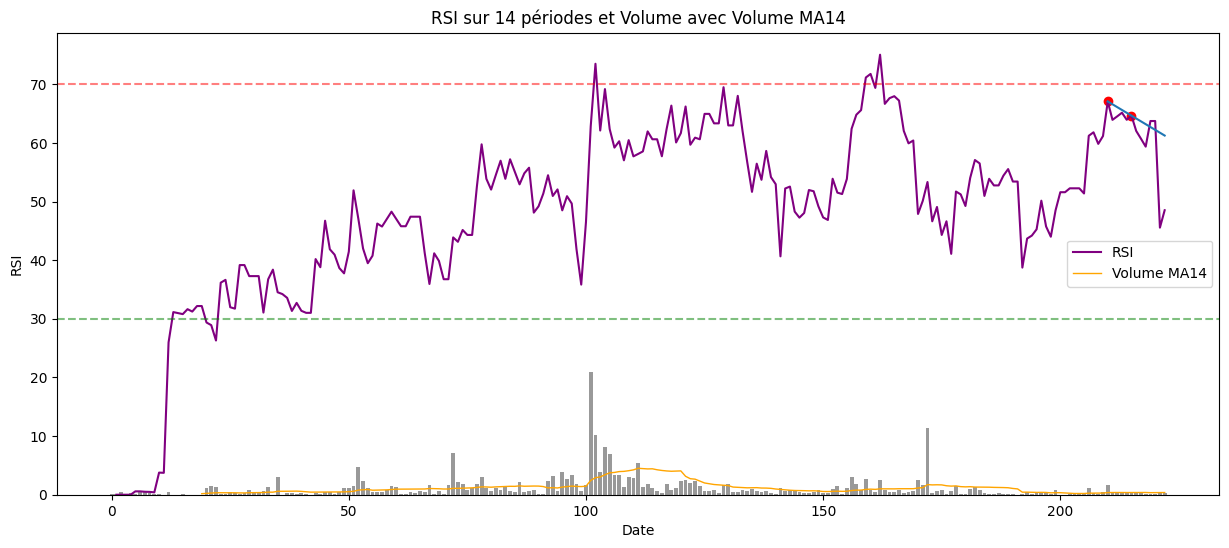

Asset: ALOSM.PA, Score: 3, URL: https://www.tradingview.com/chart/?symbol=ALOSM&interval=1W


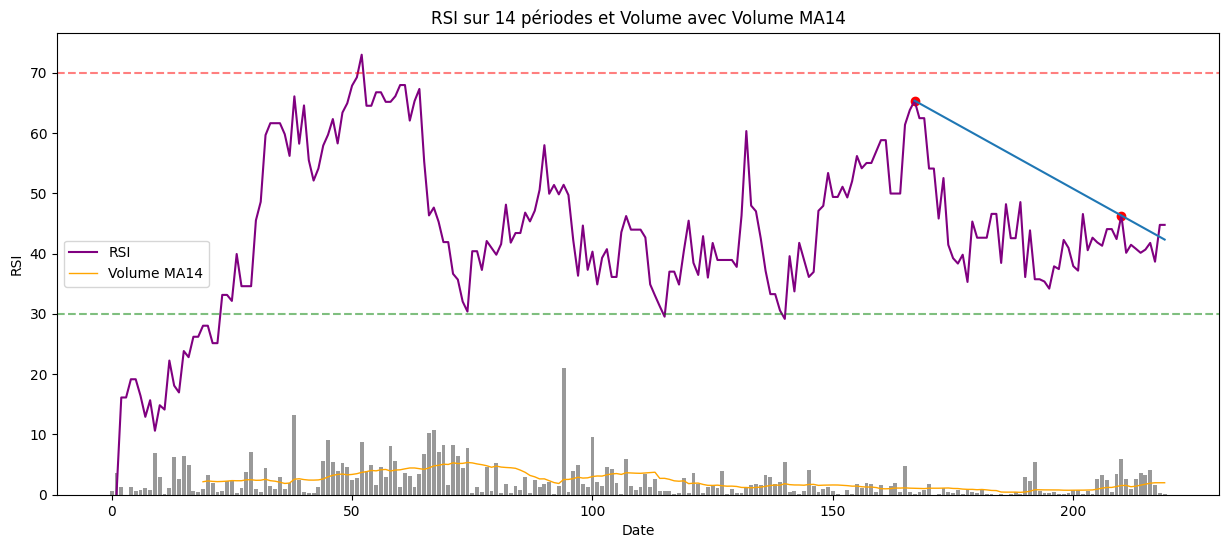

Asset: ALAQU.PA, Score: 2, URL: https://www.tradingview.com/chart/?symbol=ALAQU&interval=1W


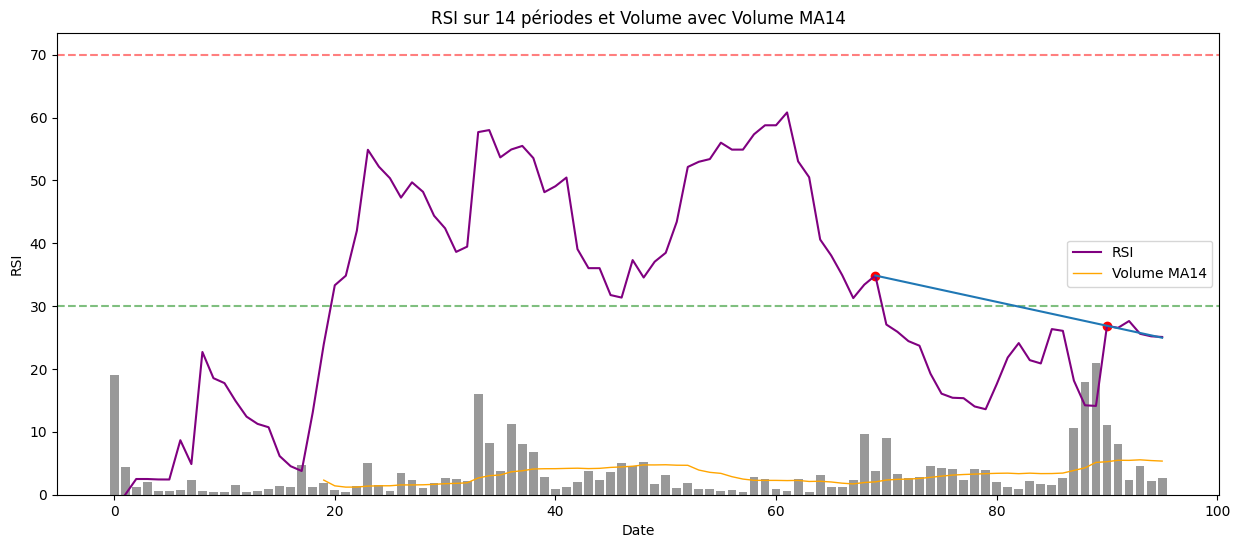

Asset: ALBPK.PA, Score: 2, URL: https://www.tradingview.com/chart/?symbol=ALBPK&interval=1W


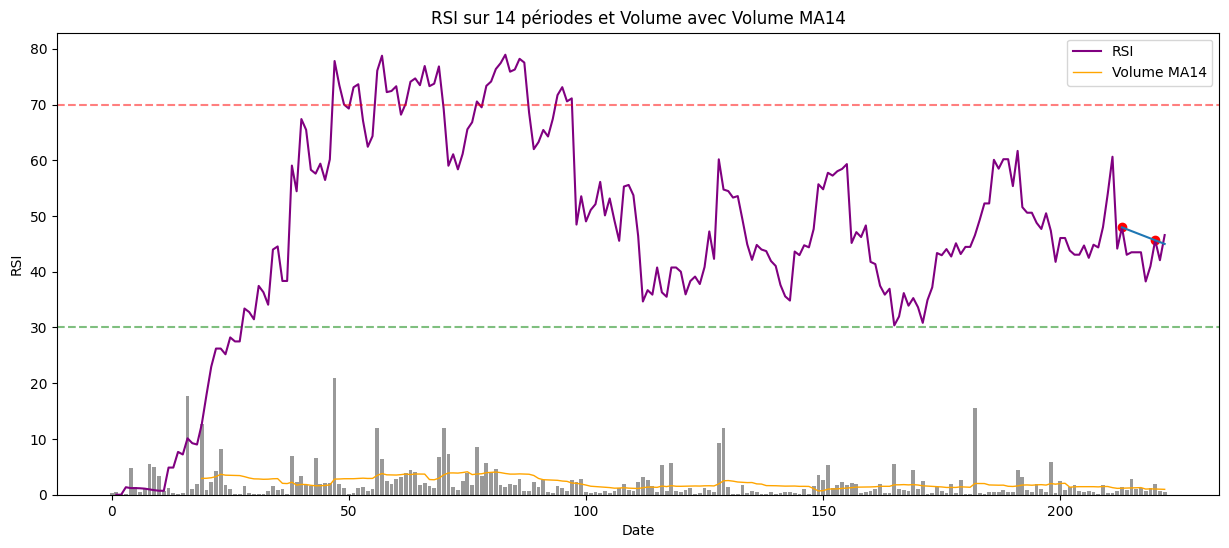

Asset: CAFO.PA, Score: 2, URL: https://www.tradingview.com/chart/?symbol=CAFO&interval=1W


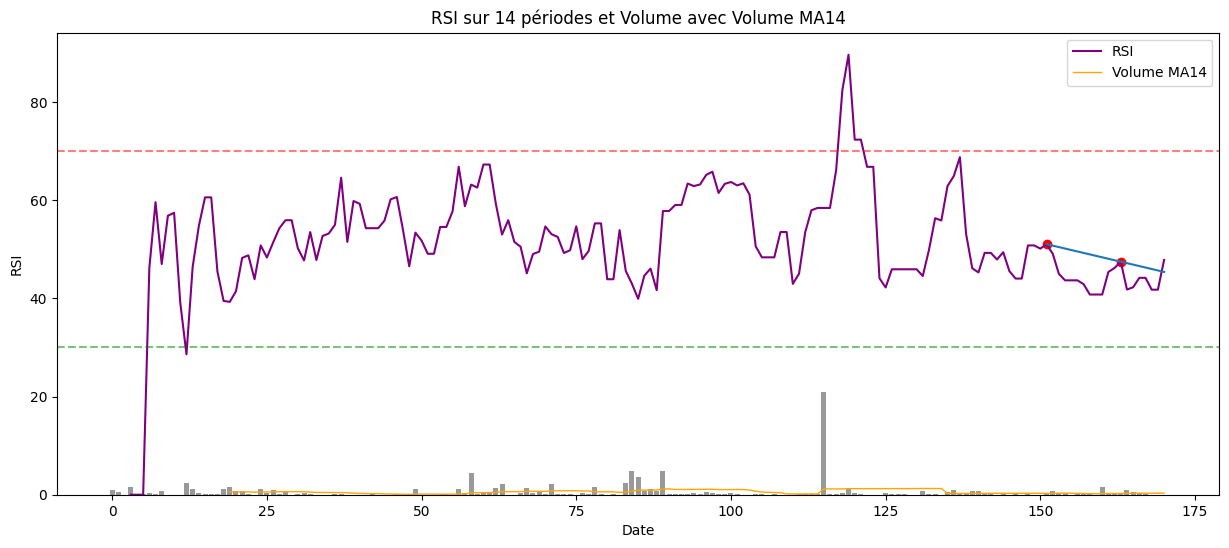

Asset: CROS.PA, Score: 2, URL: https://www.tradingview.com/chart/?symbol=CROS&interval=1W


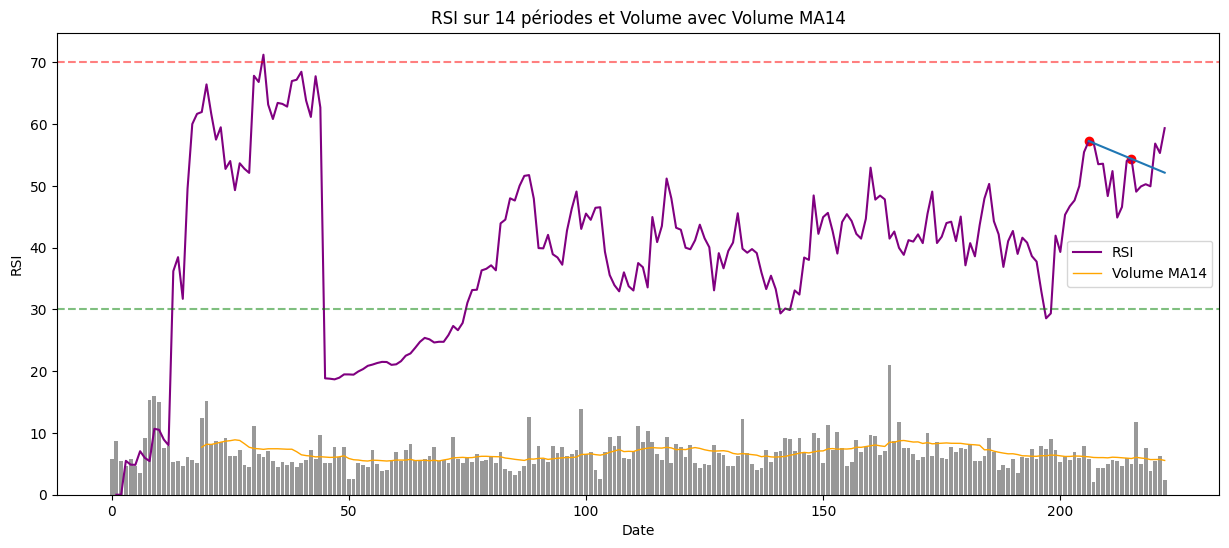

Asset: ERF.PA, Score: 2, URL: https://www.tradingview.com/chart/?symbol=ERF&interval=1W


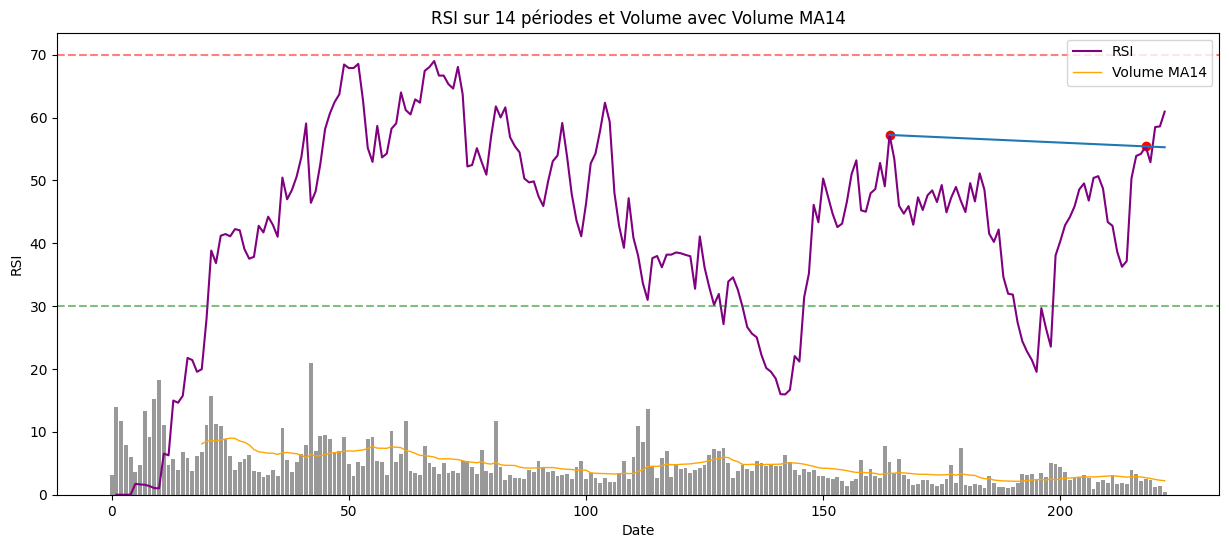

Asset: FNAC.PA, Score: 2, URL: https://www.tradingview.com/chart/?symbol=FNAC&interval=1W


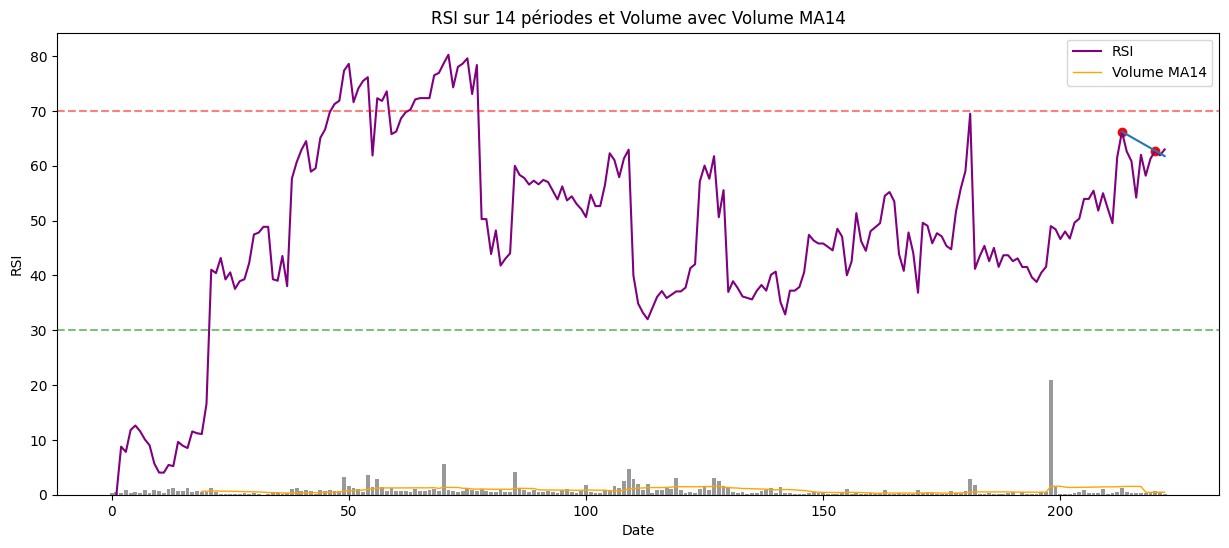

Asset: ALHF.PA, Score: 2, URL: https://www.tradingview.com/chart/?symbol=ALHF&interval=1W


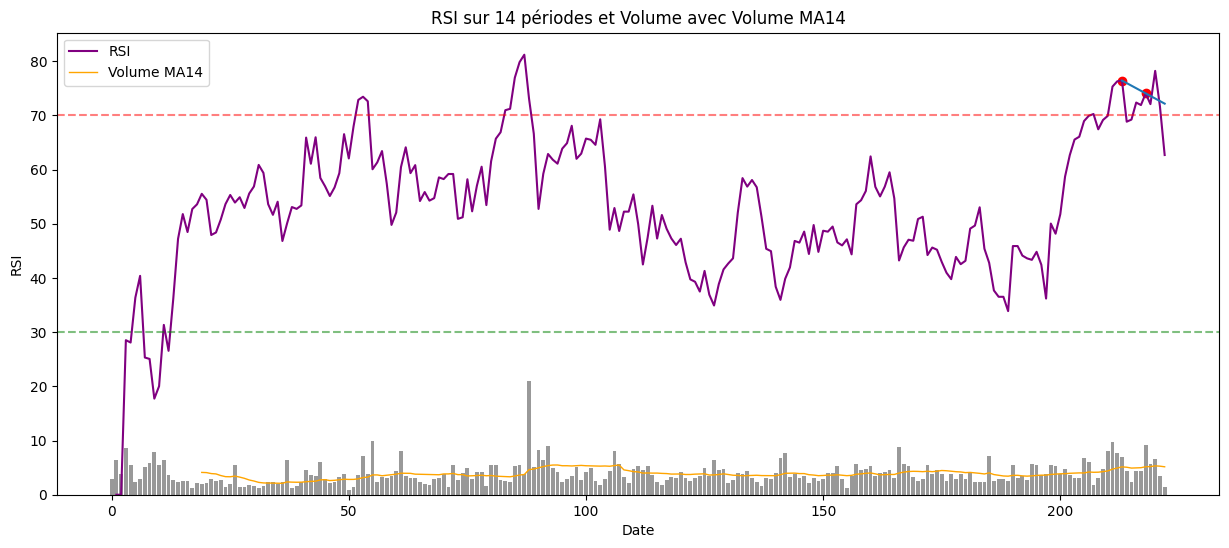

Asset: IDL.PA, Score: 2, URL: https://www.tradingview.com/chart/?symbol=IDL&interval=1W


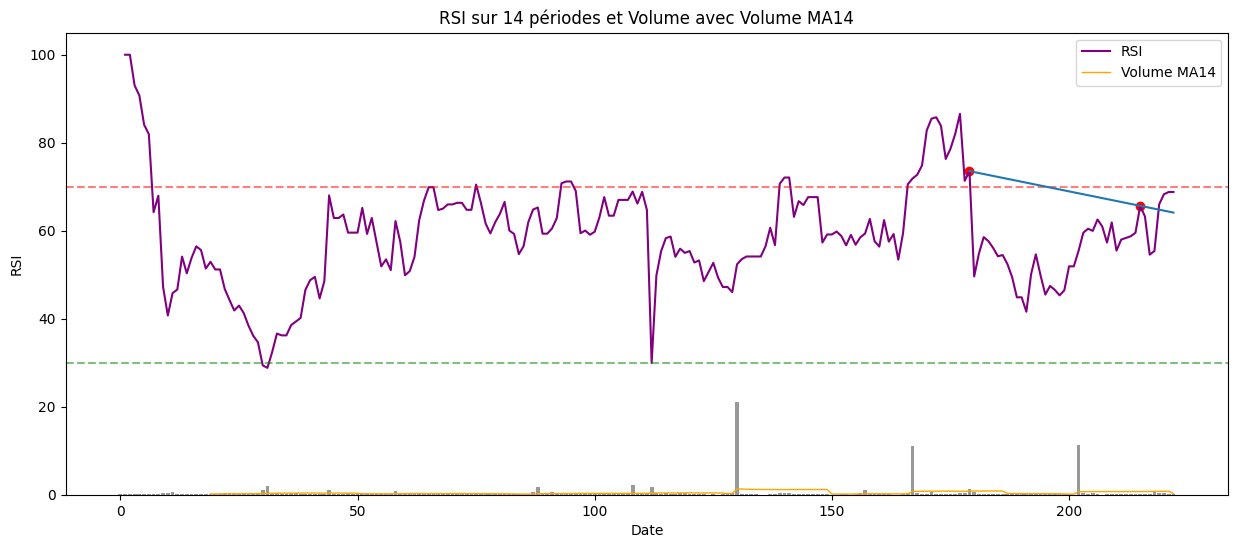

Asset: ALLAN.PA, Score: 2, URL: https://www.tradingview.com/chart/?symbol=ALLAN&interval=1W


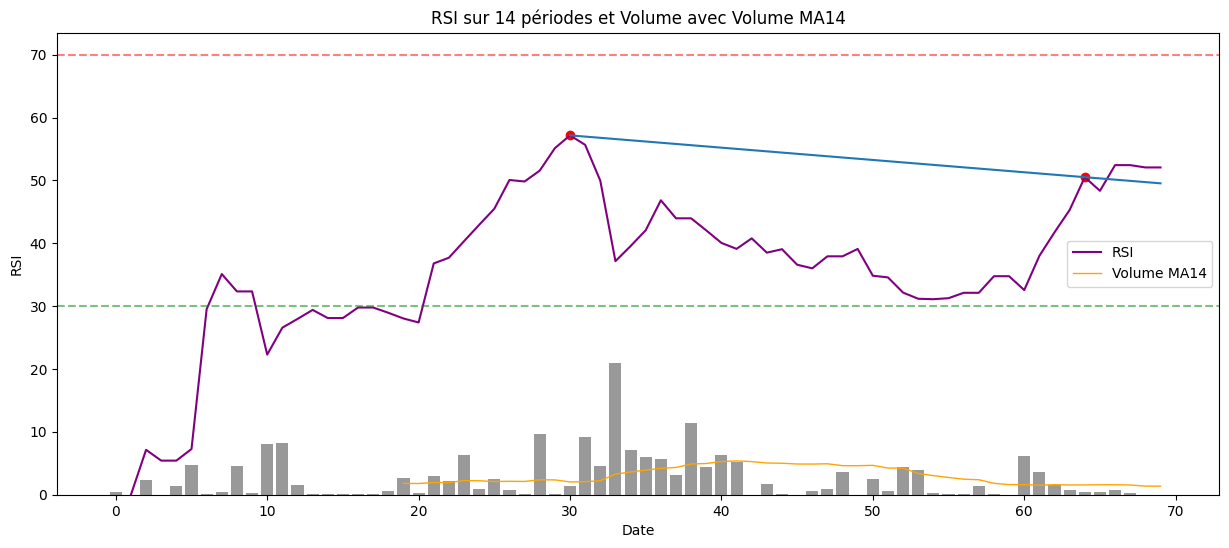

Asset: MLLAB.PA, Score: 2, URL: https://www.tradingview.com/chart/?symbol=MLLAB&interval=1W


In [36]:
STOCK_NUMBER = 600 

def display_stock(limit, best_lines):
    for (line, stock, df_rsi) in best_lines:
        plot_rsi_with_line(line.x_1, line.x_2, line.y_1, line.y_2, df_rsi=df_rsi, limit=limit)
        print(f"Asset: {stock}, Score: {line.score}, URL: https://www.tradingview.com/chart/?symbol={stock[:-3]}&interval=1W")

def screen_best_stocks(limit=100):
    stocks = get_ticker_names() 
    best_lines = list()

    for stock in stocks[:STOCK_NUMBER]:
        df = get_stock_data(stock)
        get_best_valid_line(best_lines, stock, df, limit)

    best_lines.sort(key=lambda x: x[0].score, reverse=True)
    display_stock(limit, best_lines)

screen_best_stocks(limit=400)